# VISUALIZATION

## Import Libraries and seed
Import the necessary libraries for data processing, model building, training, and evaluation. Adding a seed ensures reproducibility by making sure that the random number generation is consistent across different runs.

In [10]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import seaborn as sns
import warnings

from scipy.stats import zscore

# import wandb

def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    return seed

# Set seed for reproducibility
seed = set_seed(42)


In [11]:
def load_data_from_directory(input_path):
    data_frames = []
    for file in os.listdir(input_path):
        if file.endswith('.csv'):
            df = pd.read_csv(os.path.join(input_path, file), delimiter=';', header=0)
            data_frames.append(df)
    data = pd.concat(data_frames, ignore_index=True)

    return data

## Preprocessing Data - Dispersion
Define a function to preprocess the data. This includes encoding categorical labels and standardizing the features.

In [12]:
def calculate_averages_and_dispersion(df, data_percentage):

    results = []
    for (sample, freq), group in df.groupby(['Sample', 'Frequency (GHz)']):
        window_size = max(1, int(len(group) * data_percentage / 100))
        # print(f"Processing sample: {sample}, frequency: {freq} with window size: {window_size}")
        for start in range(0, len(group), window_size):
            window_data = group.iloc[start:start + window_size]
            mean_values = window_data[['LG (mV)', 'HG (mV)']].mean()
            std_deviation_values = window_data[['LG (mV)', 'HG (mV)']].std()
            results.append({
                'Frequency (GHz)': freq,
                'LG (mV) mean': mean_values['LG (mV)'],
                'HG (mV) mean': mean_values['HG (mV)'],
                'LG (mV) std deviation': std_deviation_values['LG (mV)'],
                'HG (mV) std deviation': std_deviation_values['HG (mV)'],
                # 'Thickness (mm)': window_data['Thickness (mm)'].iloc[0], ## COMMENT
                'Sample': sample,
            })
    results_df = pd.DataFrame(results)

    return results_df

## Pivoting Frequency values to columns

In [13]:
def freq_as_variable(df, data_percentage):
    '''Modify df to have Frequency values (100,110,120 and so on) as input variables in the columns'''

    # Remove Thickness column
    if 'Thickness (mm)' in df.columns:
        df = df.drop(columns=['Thickness (mm)'])

    if data_percentage > 0:
        # 1s window_size 100/27s = 3.7% of the data is used for each window
        df_window = calculate_averages_and_dispersion(df, data_percentage) 

        # Add a unique identifier column to avoid duplicate entries in the index
        df_window['unique_id'] = df_window.groupby(['Sample', 'Frequency (GHz)']).cumcount()

        # Pivot the DataFrame to wide format
        df_pivot = df_window.pivot(index=['Sample', 'unique_id'], columns='Frequency (GHz)')

        # Flatten the MultiIndex columns - Ordered by Frequency + (HG mean, HG std deviation, LG mean, LG std deviation)
        df_pivot.columns = [' '.join([str(col[1]), str(col[0])]) for col in df_pivot.columns]

        # Drop columns with all NaN values
        df_pivot = df_pivot.dropna(axis=1, how='all')

        # Reset index to make 'Sample' and 'unique_id' columns again
        df_pivot = df_pivot.reset_index()

        # Remove 'unique_id' column
        df_pivot = df_pivot.drop(columns=['unique_id'])
    else:
        # If data_percentage is 0, do not calculate mean and std deviation, use the original data
        df['unique_id'] = df.groupby(['Sample', 'Frequency (GHz)']).cumcount()
        df_pivot = df.pivot(index=['Sample', 'unique_id'], columns='Frequency (GHz)')
        df_pivot.columns = [' '.join([str(col[1]), str(col[0])]) for col in df_pivot.columns]
        df_pivot = df_pivot.dropna(axis=1, how='all')
        df_pivot = df_pivot.reset_index()
        df_pivot = df_pivot.drop(columns=['unique_id'])

    # Optional - Sort the columns if needed
    df_pivot = df_pivot.reindex(sorted(df_pivot.columns), axis=1)

    return df_pivot

In [14]:
# Load the data from the directory
# input_path = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_2_plastics/processed/test/repeatibility/'
# input_path = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_3_repeatibility/processed/'
input_path = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_4_plastics/processed/'

# input_path = 'C:/Users/Dani - TUF/Documents/GitHub/PIC-PAPER-01/data/experiment_4_plastics/processed/'

df = load_data_from_directory(input_path)

df = pd.concat([df[['Frequency (GHz)', 'LG (mV)', 'HG (mV)']], df[['Sample']]], axis=1)

df.head()

# show random rows
df.sample(15)



Frequency (GHz)    LG (mV)     HG (mV) Sample
62258             290.0   1.861800   -0.549370   B1_5
313317            350.0   0.732511  711.695772   E3_6
64632             340.0   0.915639    0.427306   B1_5
311084            310.0   2.777439   -0.152612   E3_6
246638            150.0  64.949334   -0.274706  E3_13
264402            450.0  -0.610426  126.266645  E3_13
109039            130.0  36.411915    0.335747  C1_11
152423            410.0   0.305213  225.186180  C1_14
250090            210.0   5.799048    0.335729  E3_13
283870            320.0   1.922842  718.318909   E3_3
235227            450.0   0.061043  120.314990  E3_10
322614            510.0   0.091564   67.055304   E3_6
246850            150.0  63.484311    0.518841  E3_13
174012            290.0   2.685875   -0.366235   C1_4
245485            120.0  31.192773    0.518841  E3_13

## Balance Dataset

C:\Users\Danim\AppData\Local\Temp\ipykernel_20648\1209927551.py:5: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


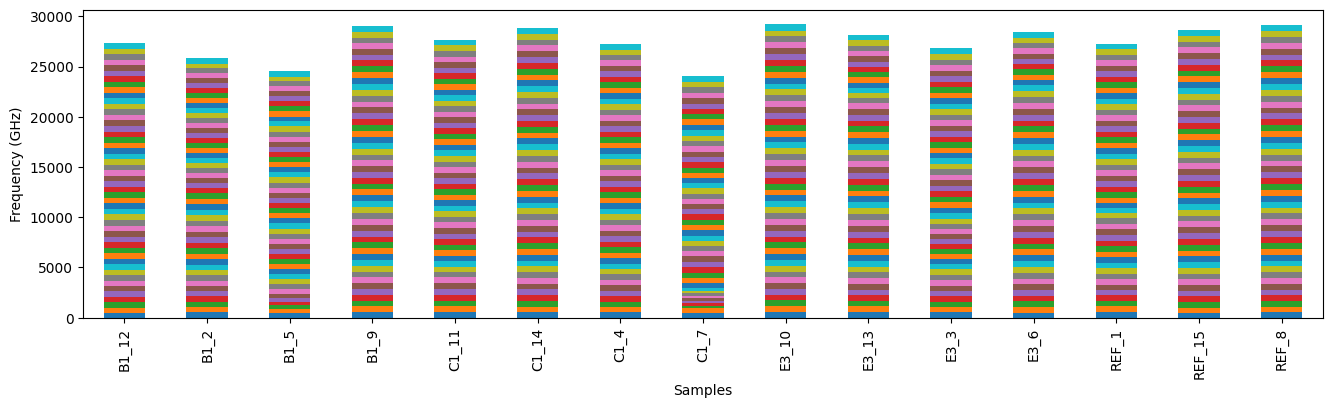

Mode value: 548


C:\Users\Danim\AppData\Local\Temp\ipykernel_20648\1209927551.py:34: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


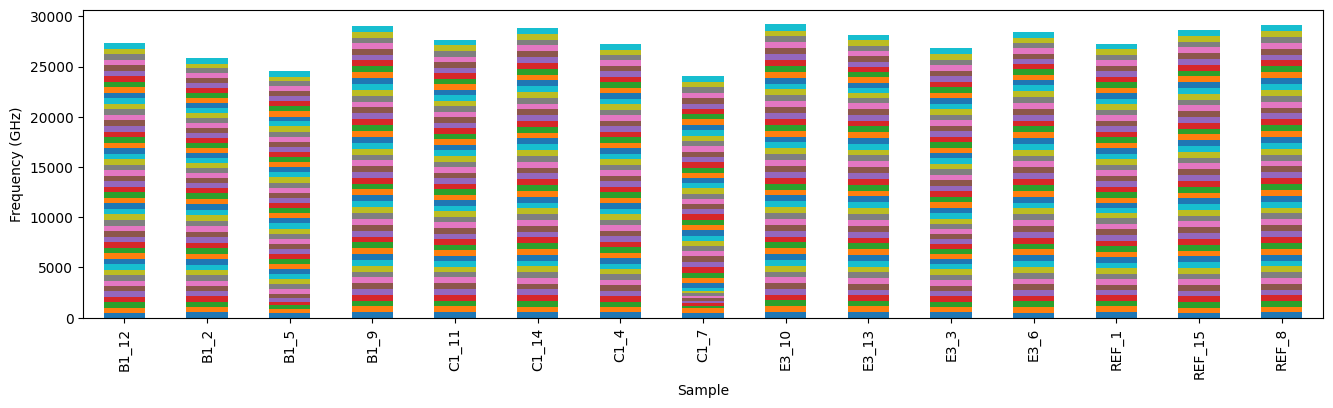

In [15]:
# Number of samples per frequency and Sample
bx = df.groupby(['Sample', 'Frequency (GHz)']).size().unstack().plot.bar(figsize=(16, 4), stacked=True)
bx.set_xlabel('Samples')
bx.set_ylabel('Frequency (GHz)')
plt.tight_layout()
#no legend
bx.get_legend().remove()
plt.show()

# Balance the data by taking the mode of samples per frequency
mode = df.groupby(['Sample', 'Frequency (GHz)']).size().mode()[0]
print(f'Mode value: {mode}')
mode = 2350

# Function to reduce samples to the mode value
def reduce_to_mode(df, sample, frequency, mode):
    # Filter the DataFrame for the specific sample and frequency
    freq_df = df[(df['Sample'] == sample) & (df['Frequency (GHz)'] == frequency)]
    # If the number of samples is greater than the mode, sample down to the mode
    if len(freq_df) > mode:
        return freq_df.sample(n=mode, random_state=42)
    return freq_df

# Apply the function to reduce samples for each combination of Sample and Frequency (GHz)
balanced_data = []
for (sample, frequency), group in df.groupby(['Sample', 'Frequency (GHz)']):
    balanced_data.append(reduce_to_mode(df, sample, frequency, mode))

# Combine the balanced samples into a single DataFrame
df_balanced = pd.concat(balanced_data)

bx = df_balanced.groupby(['Sample', 'Frequency (GHz)']).size().unstack().plot.bar(figsize=(16, 4), stacked=True)
bx.set_ylabel('Frequency (GHz)')
plt.tight_layout()
# legend small
bx.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
#remove legend
bx.get_legend().remove()
plt.show()

## Sample a test set

In [16]:
# train_set, test_set = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Sample']) 
test_percentage = 0.25
# train_set, test_set = train_test_split(df, test_size=test_percentage, random_state=42) 
# Shuffle the data
df_balanced = df_balanced.sample(frac=1, random_state=42)
# train_set, test_set = train_test_split(df_balanced, test_size=test_percentage, random_state=42) 

# stratify=df['Sample'] to keep the same proportion of samples in the train and test set


## Spectrogram

In [17]:

from scipy.signal import spectrogram

def plot_spectrograms(df, signal_column='HG (mV)', freq_column='Frequency (GHz)', 
                      nperseg=256, noverlap=128, figsize=(10,6), 
                      cmap='viridis'):
    """
    Plot spectrograms for each unique sample in the DataFrame.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the signal data
    signal_column : str, default='HG (mV)'
        Name of the column containing signal values
    freq_column : str, default='Frequency (GHz)' 
        Name of the column containing frequency values
    nperseg : int, default=256
        Length of each segment for spectrogram
    noverlap : int, default=128
        Number of points to overlap between segments
    figsize : tuple, default=(10,6)
        Figure size in inches
    save_path : str, optional
        Path to save the plots. If None, plots are displayed only
    cmap : str, default='viridis'
        Colormap for the spectrogram
    """
    
    # Input validation
    if df.empty:
        raise ValueError("DataFrame is empty")
        
    required_cols = ['Sample', signal_column, freq_column]
    if not all(col in df.columns for col in required_cols):
        raise ValueError(f"DataFrame must contain columns: {required_cols}")
        
    samples = df['Sample'].unique()
    
    for sample in samples:
        sample_df = df[df['Sample'] == sample]
        
        if len(sample_df) < nperseg:
            print(f"Warning: Sample {sample} has fewer points than nperseg. Skipping.")
            continue
            
        # Generate frequency sweep
        min_freq = sample_df[freq_column].min()
        max_freq = sample_df[freq_column].max()
        sweep = np.linspace(min_freq, max_freq, len(sample_df))
        
        try:
            # Generate spectrogram
            f, t, Sxx = spectrogram(sample_df[signal_column], fs=sweep, 
                                   nperseg=nperseg, noverlap=noverlap)
            
            # Plot
            plt.figure(figsize=figsize)
            plt.pcolormesh(t, f, 10 * np.log10(np.maximum(Sxx, 1e-10)), 
                          shading='gouraud', cmap=cmap)
            plt.colorbar(label='Intensity [dB]')
            plt.ylabel('Frequency [GHz]')
            plt.xlabel('Time [s]')
            plt.title(f'Spectrogram for Sample {sample}')
            
            plt.show()
            plt.close()
            
        except Exception as e:
            print(f"Error processing sample {sample}: {str(e)}")
            continue

# Example usage:
plot_spectrograms(df_balanced)

Error processing sample B1_5: operands could not be broadcast together with shapes (129,) (24516,) 
Error processing sample E3_6: operands could not be broadcast together with shapes (129,) (28430,) 
Error processing sample E3_13: operands could not be broadcast together with shapes (129,) (28158,) 
Error processing sample C1_11: operands could not be broadcast together with shapes (129,) (27679,) 
Error processing sample C1_14: operands could not be broadcast together with shapes (129,) (28864,) 
Error processing sample E3_3: operands could not be broadcast together with shapes (129,) (26819,) 
Error processing sample E3_10: operands could not be broadcast together with shapes (129,) (29196,) 
Error processing sample C1_4: operands could not be broadcast together with shapes (129,) (27272,) 
Error processing sample B1_9: operands could not be broadcast together with shapes (129,) (29080,) 
Error processing sample REF_1: operands could not be broadcast together with shapes (129,) (2728

## Data Distribution per frequency and Sample

        Frequency (GHz)    LG (mV)     HG (mV) Sample
62258             290.0   1.861800   -0.549370   B1_5
313317            350.0   0.732511  711.695772   E3_6
64632             340.0   0.915639    0.427306   B1_5
311084            310.0   2.777439   -0.152612   E3_6
246638            150.0  64.949334   -0.274706  E3_13


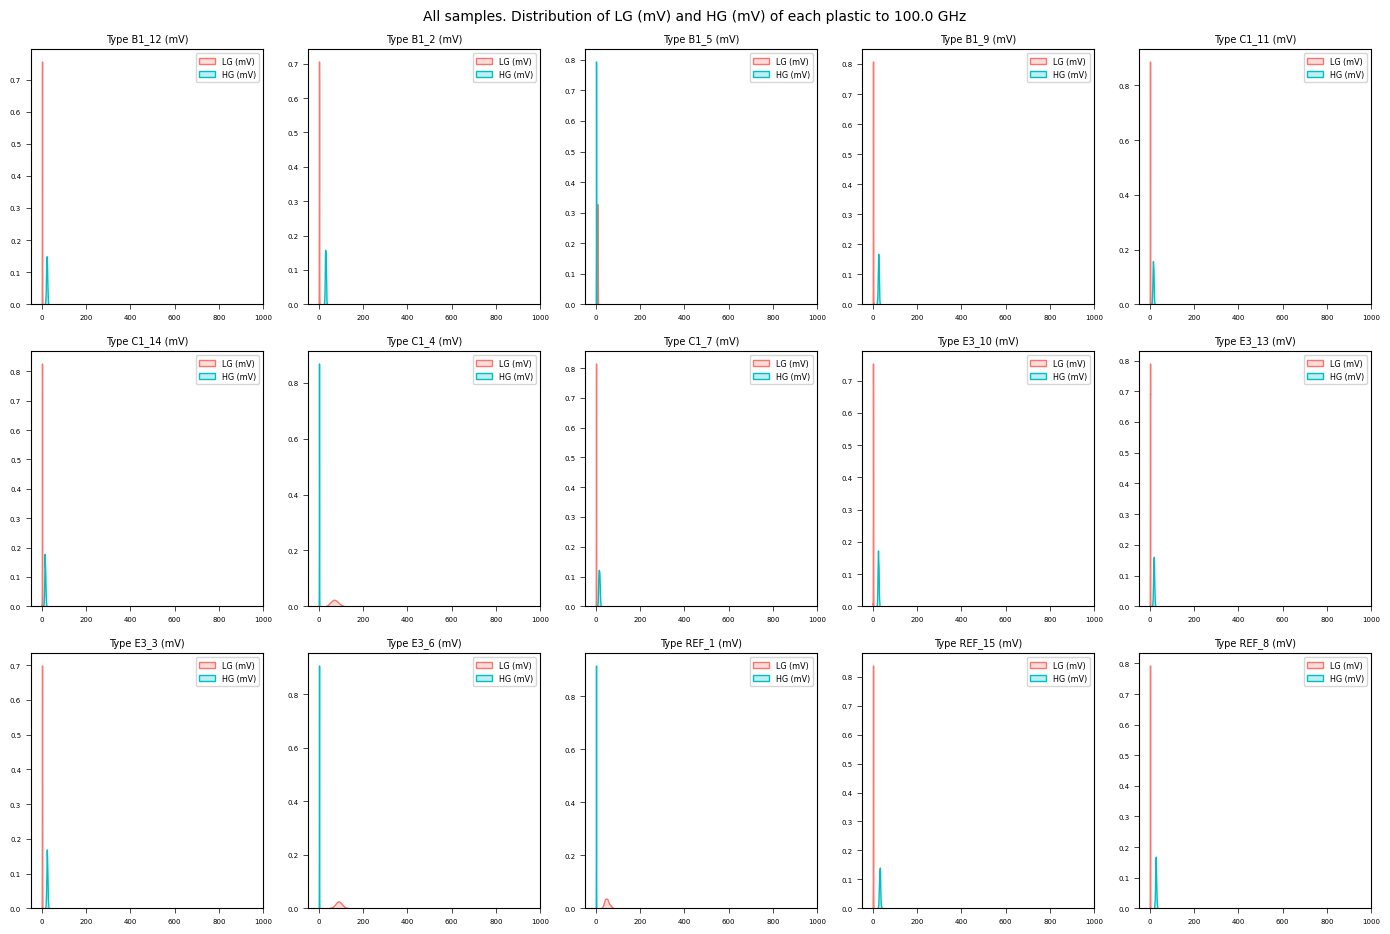

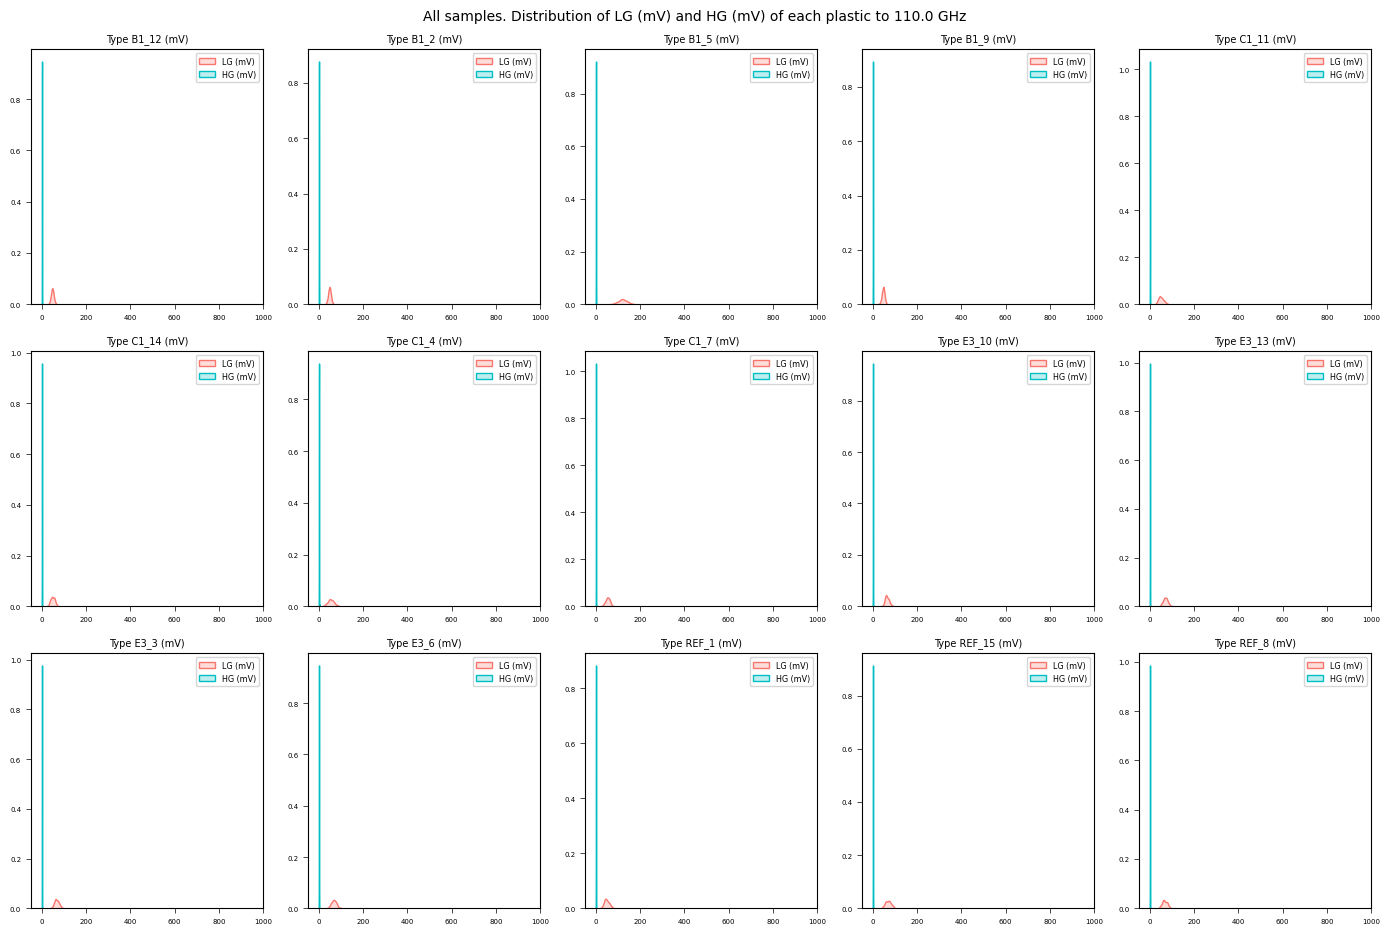

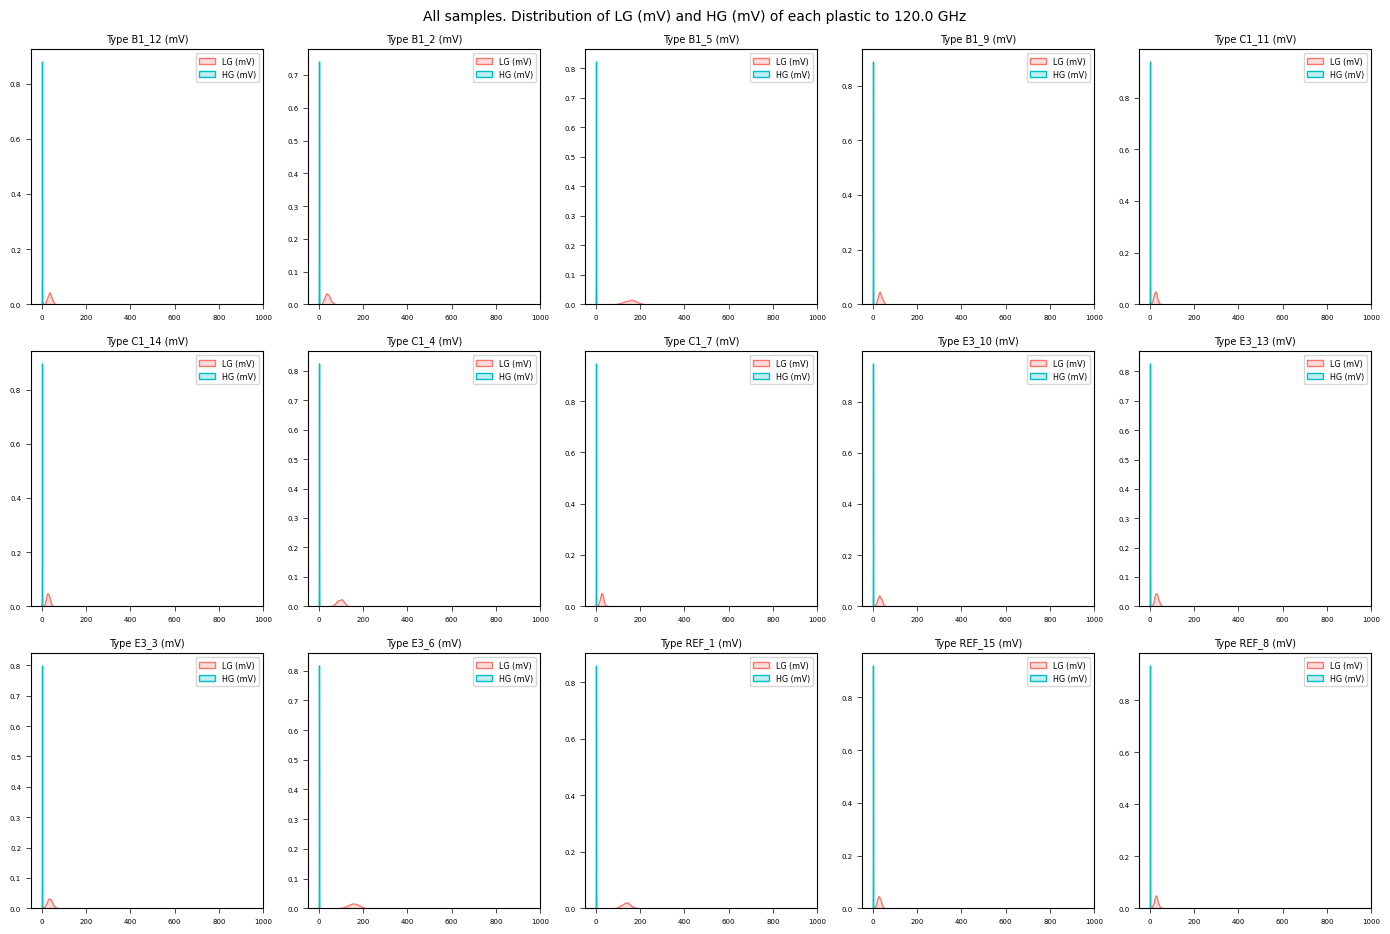

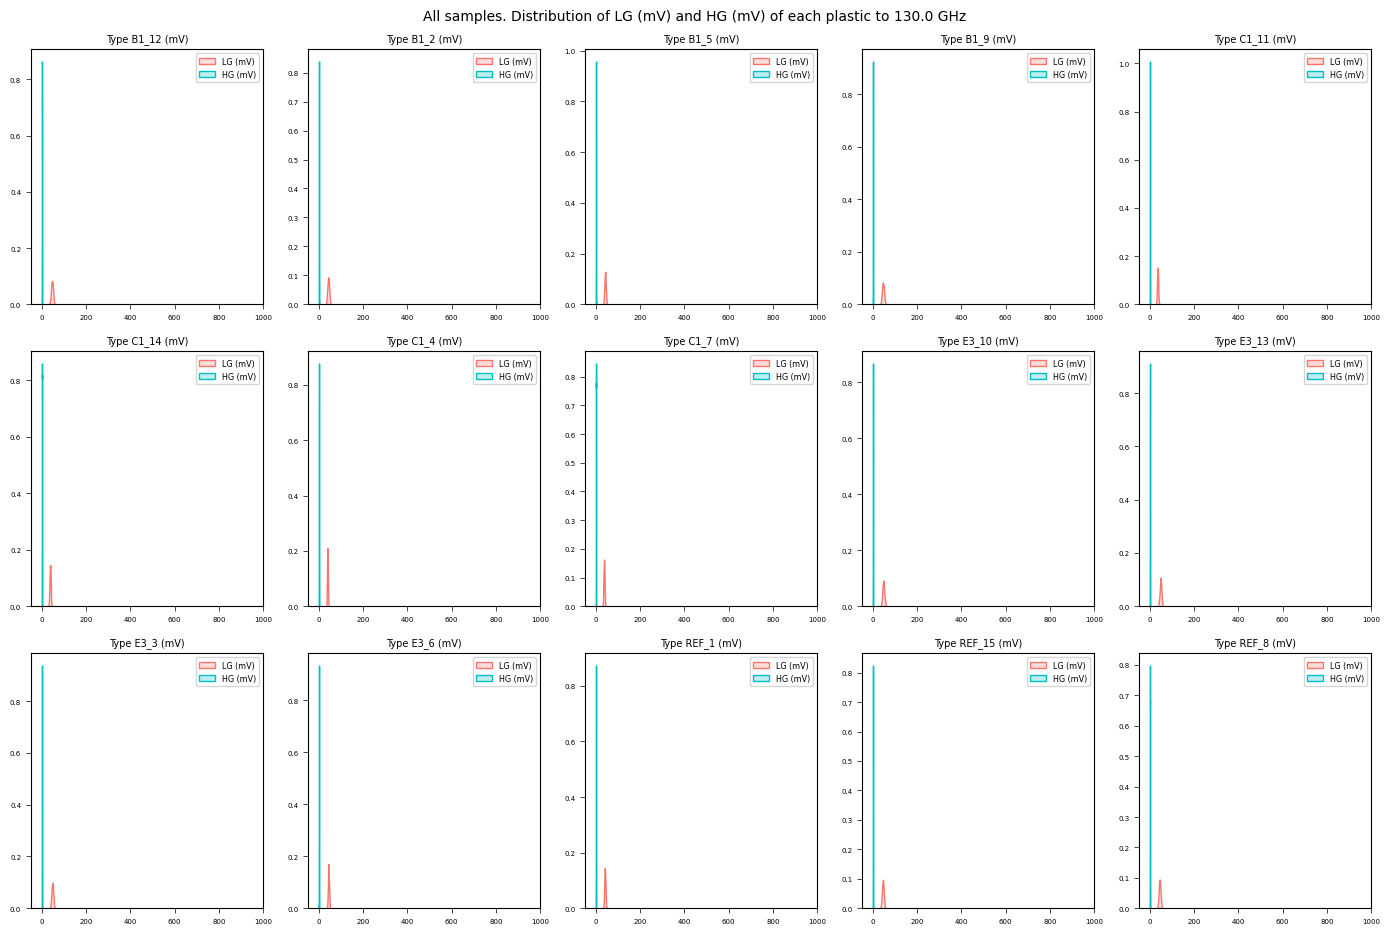

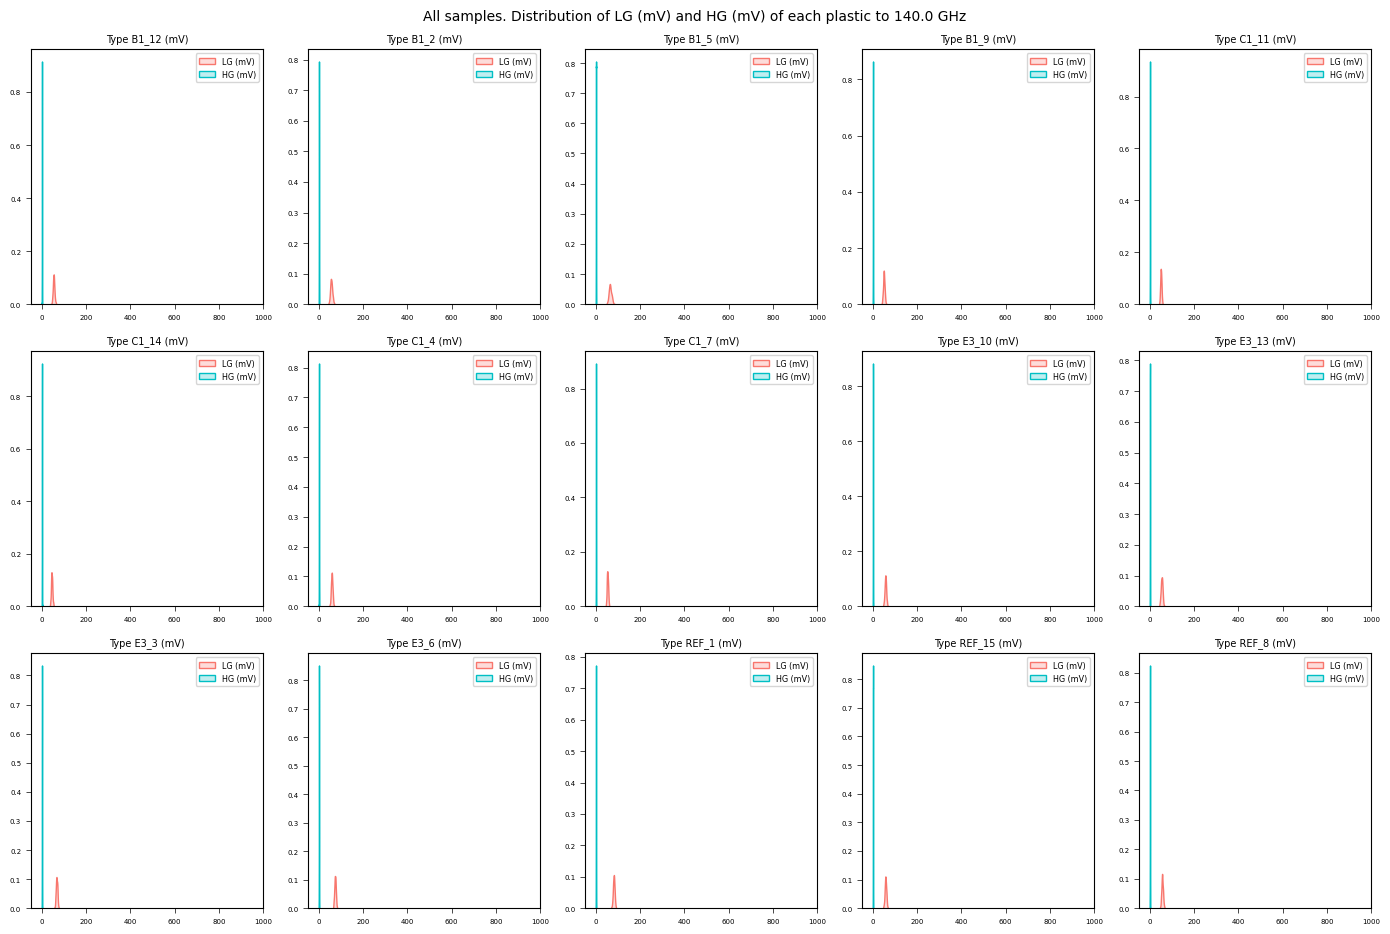

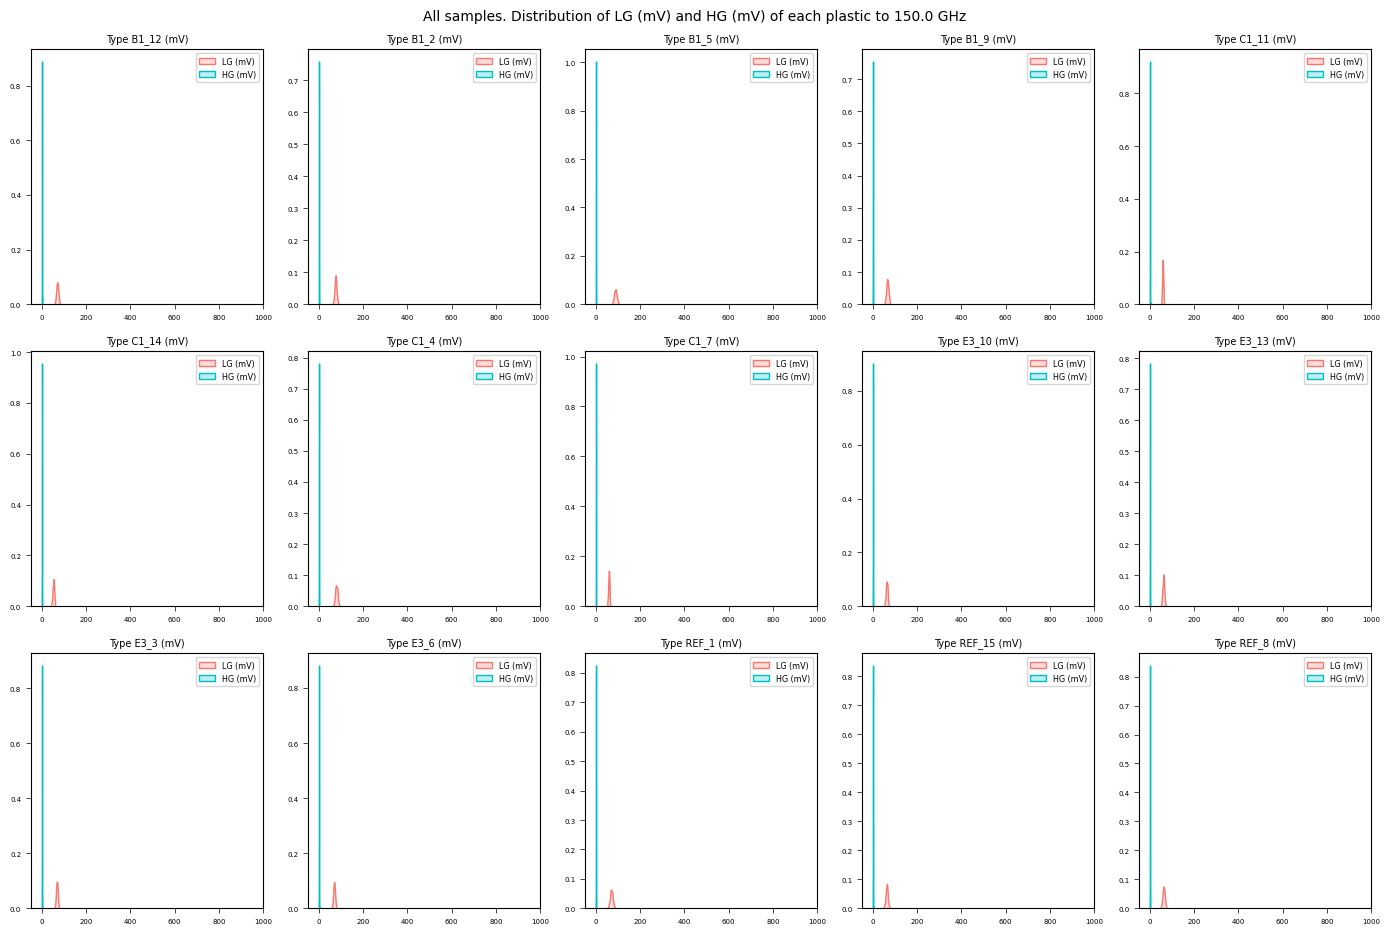

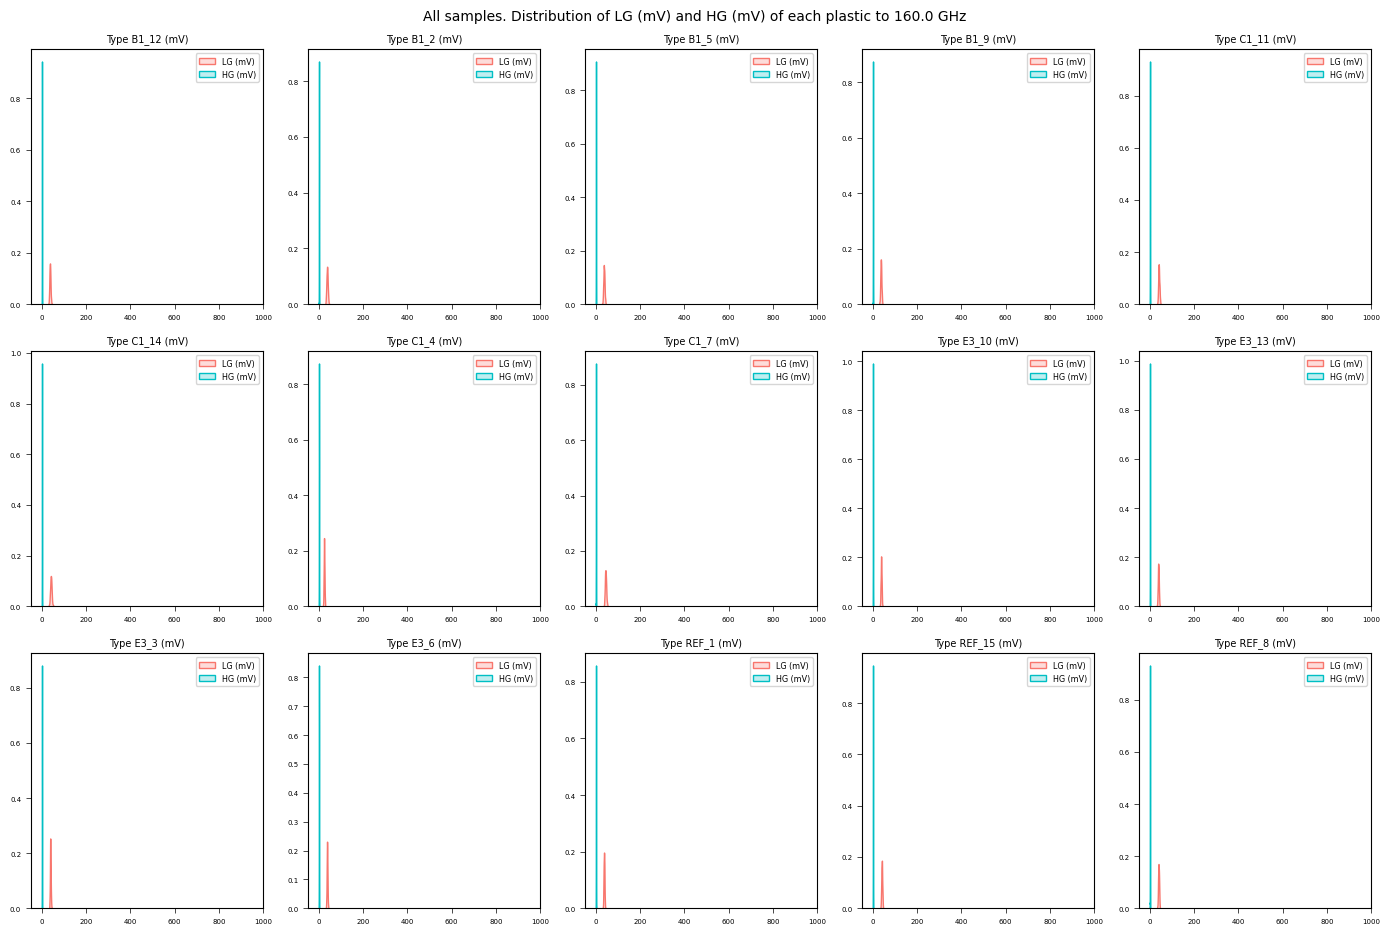

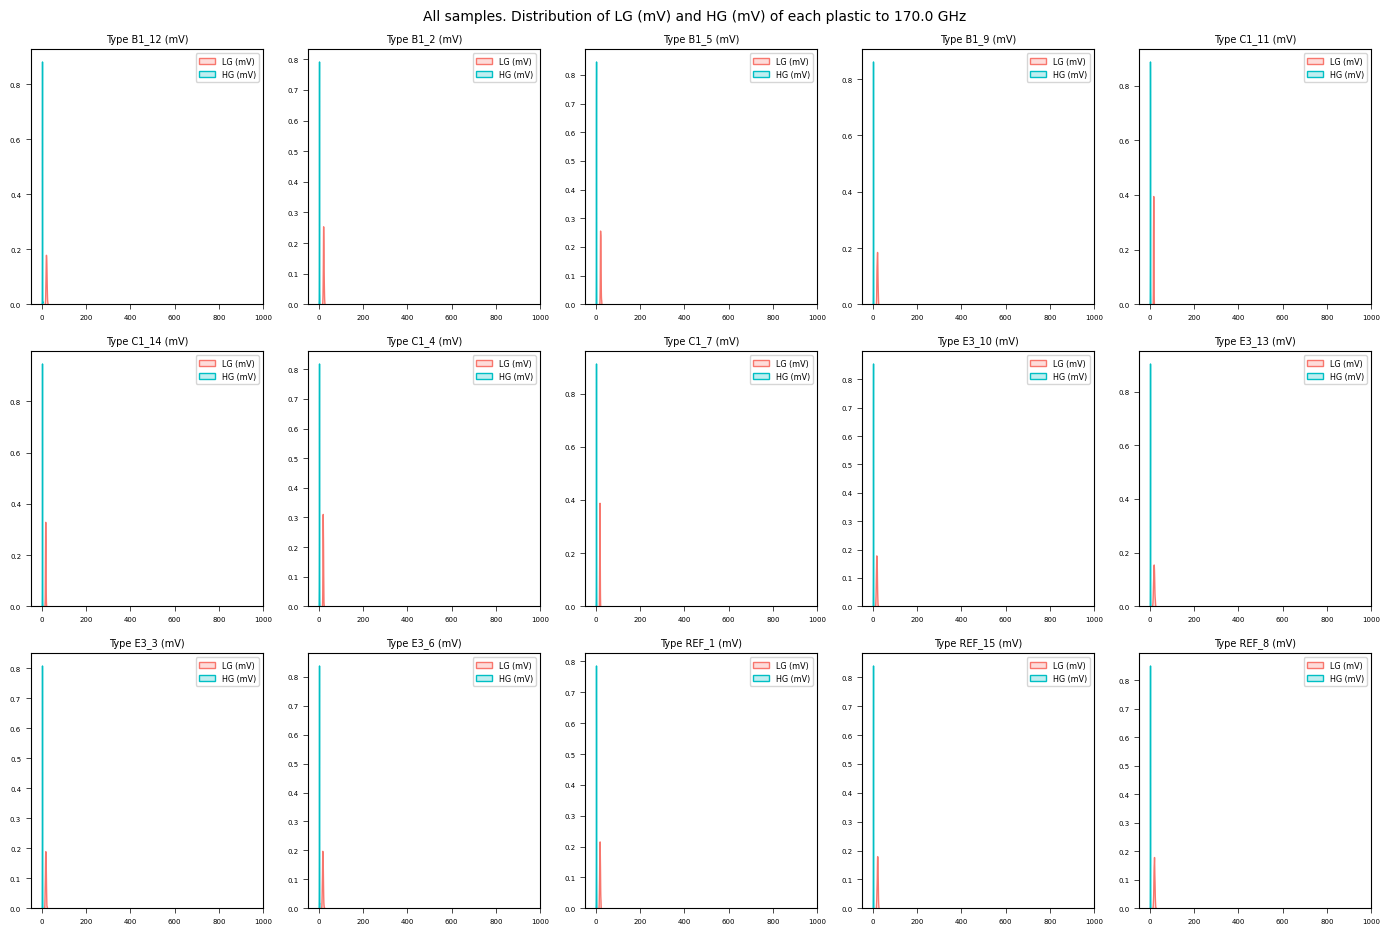

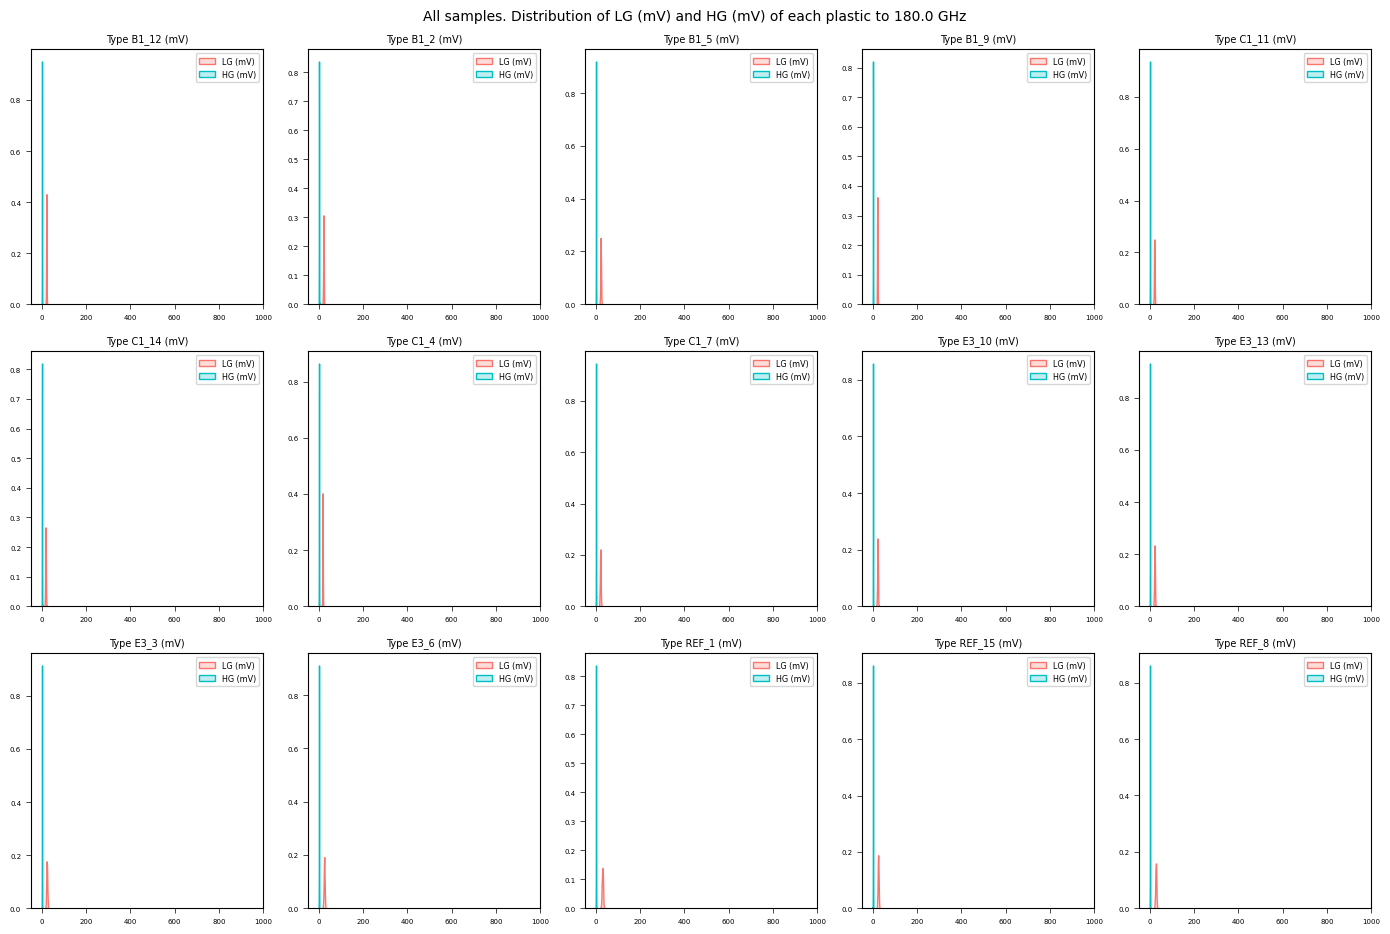

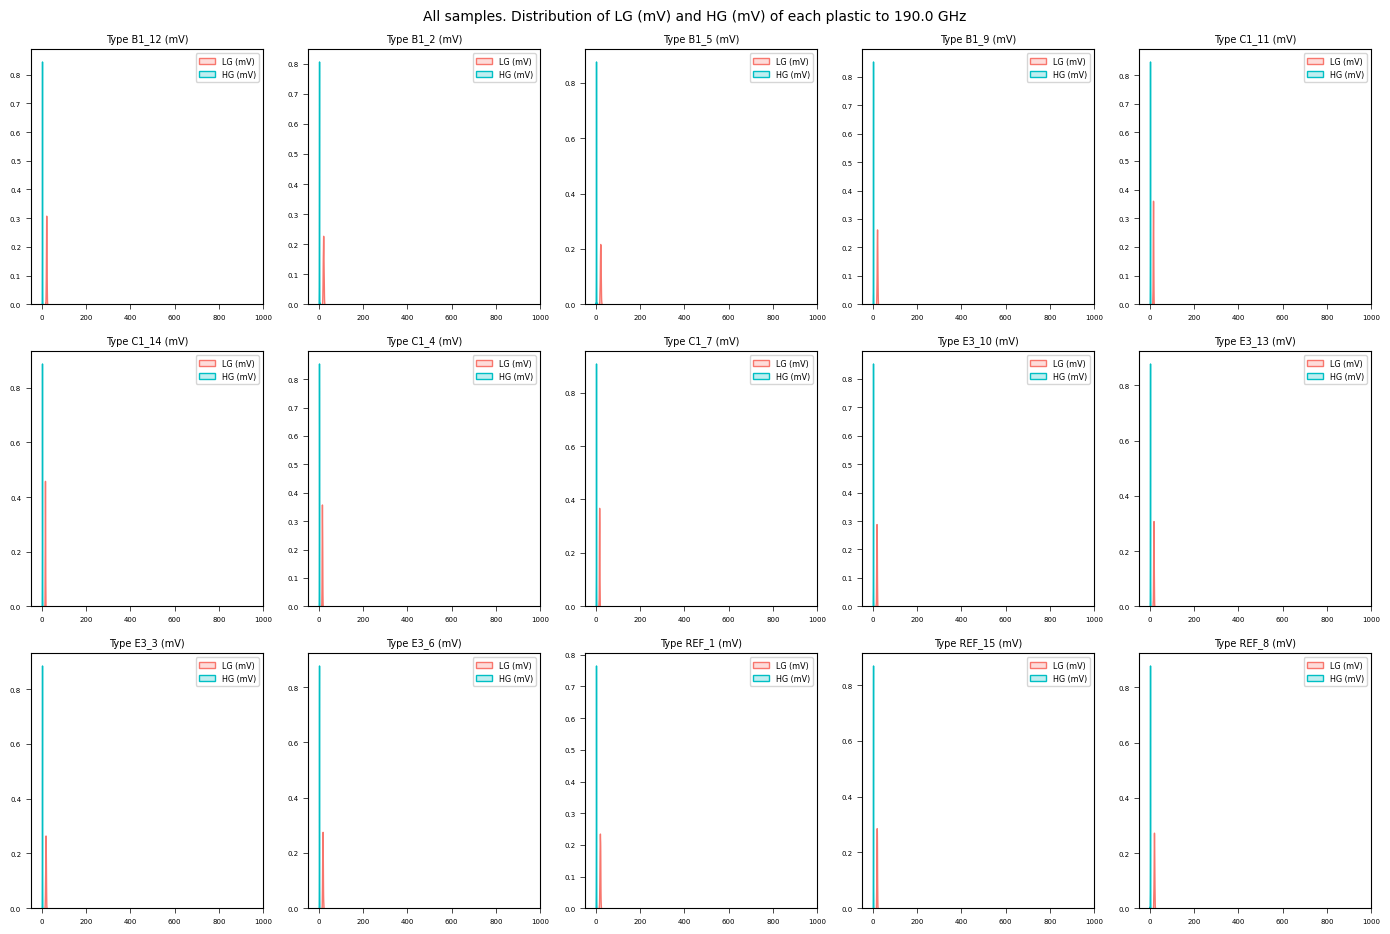

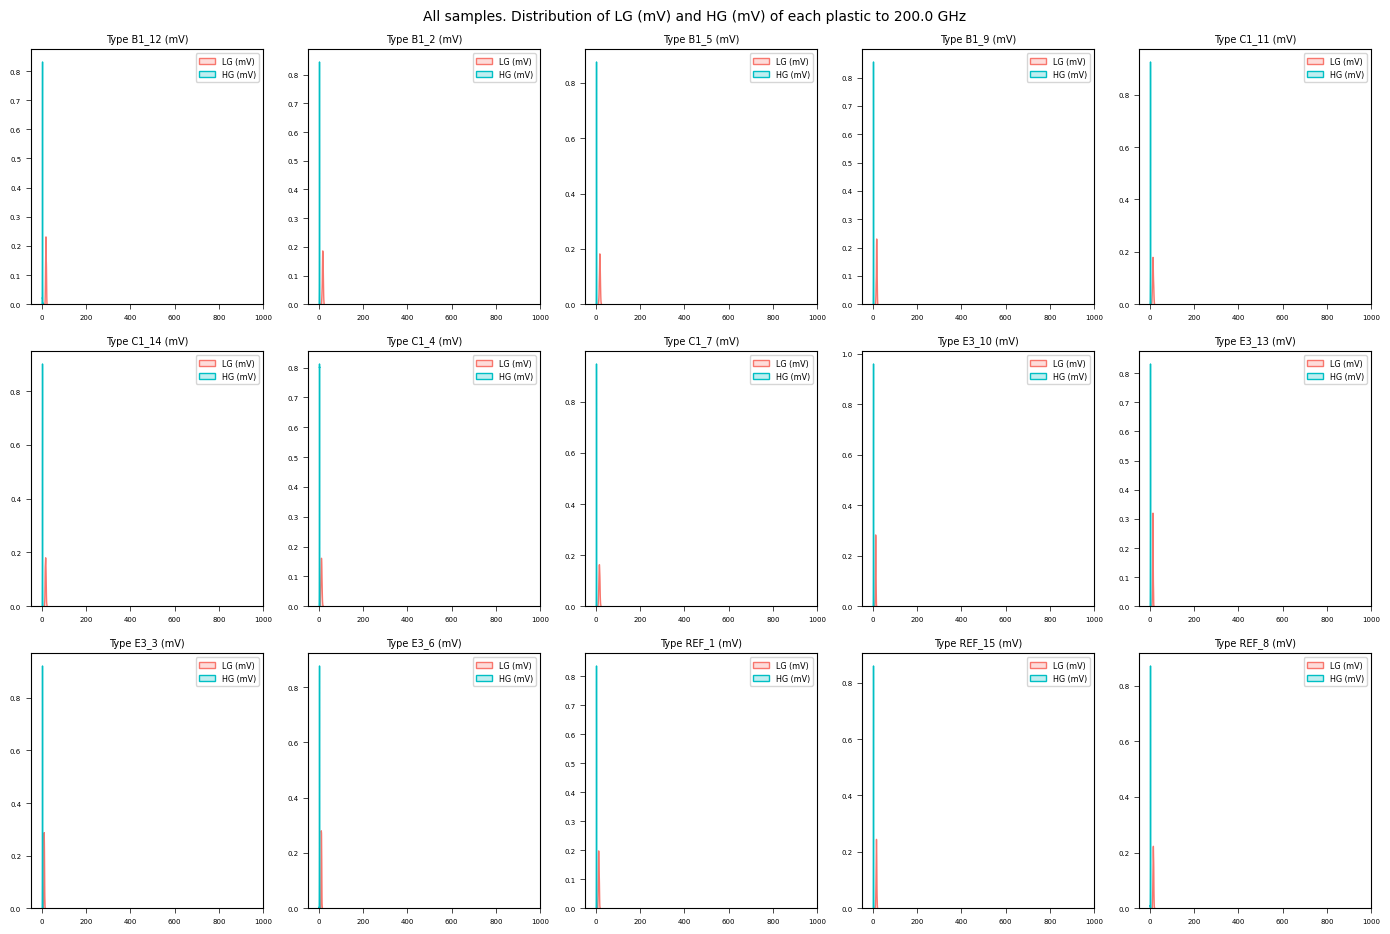

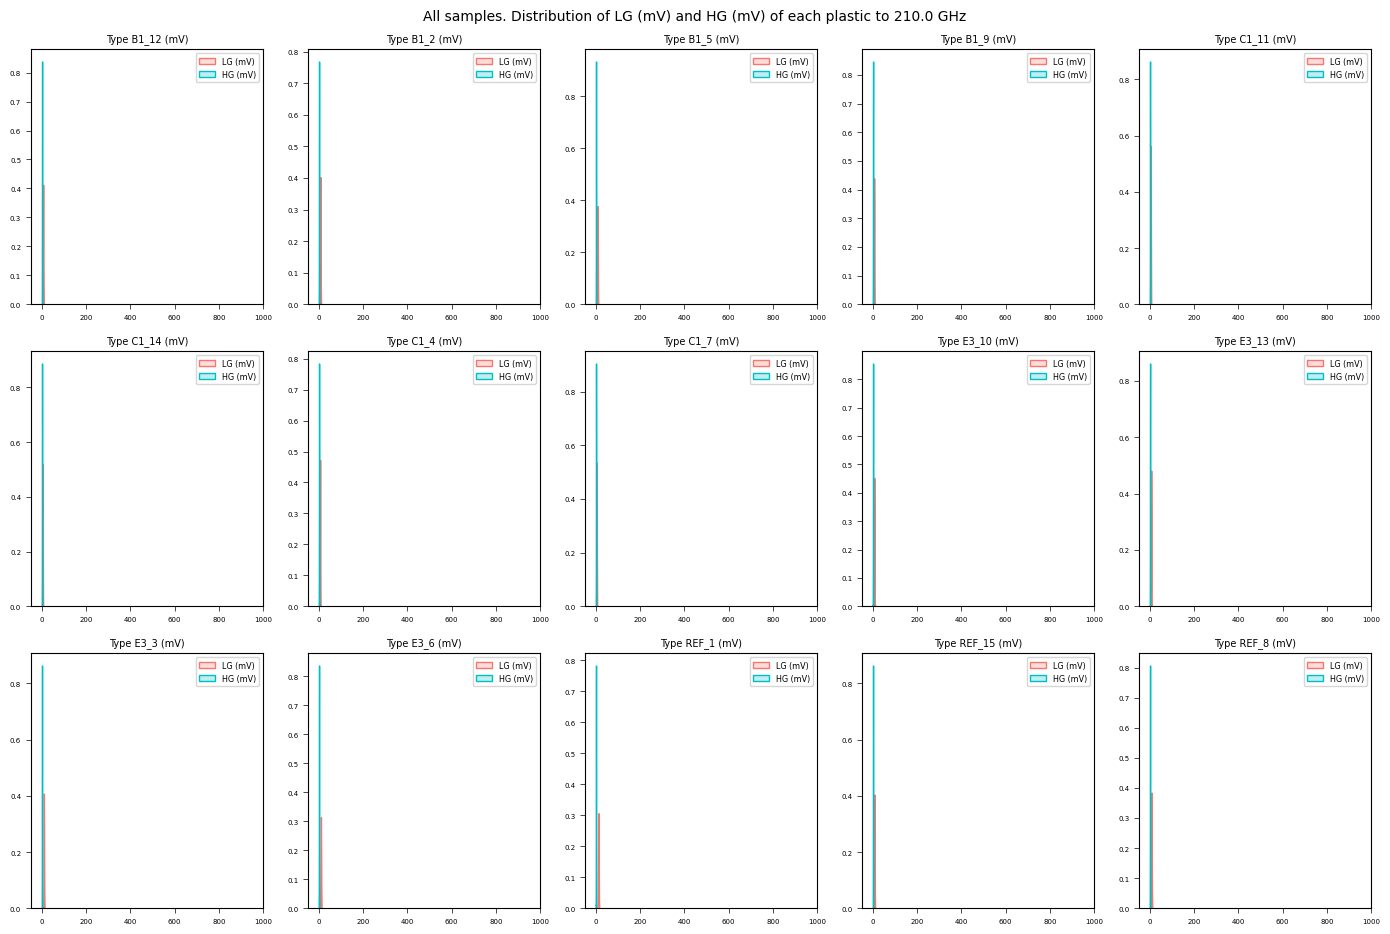

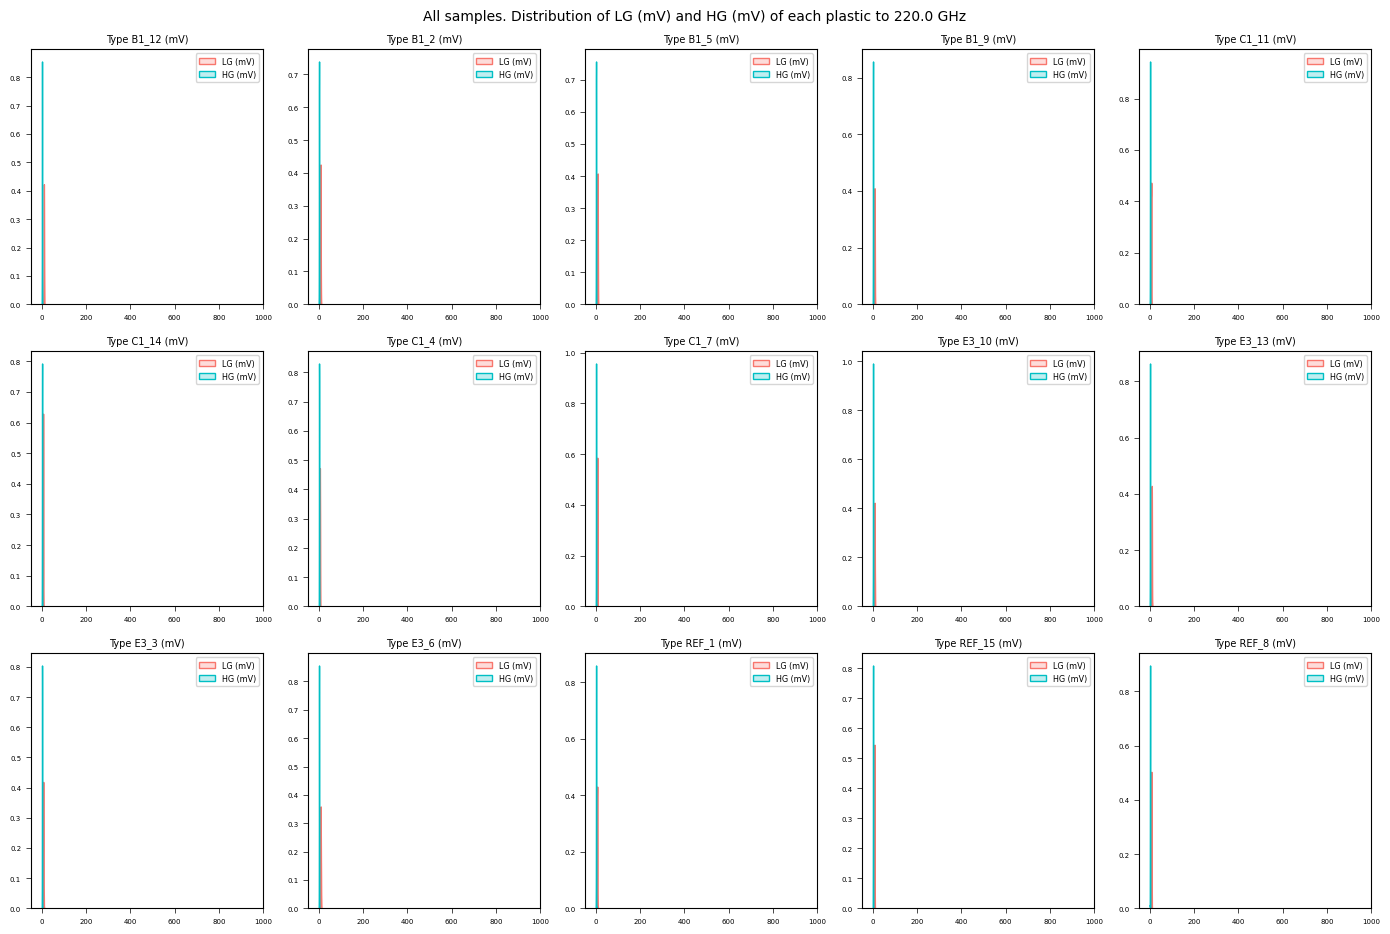

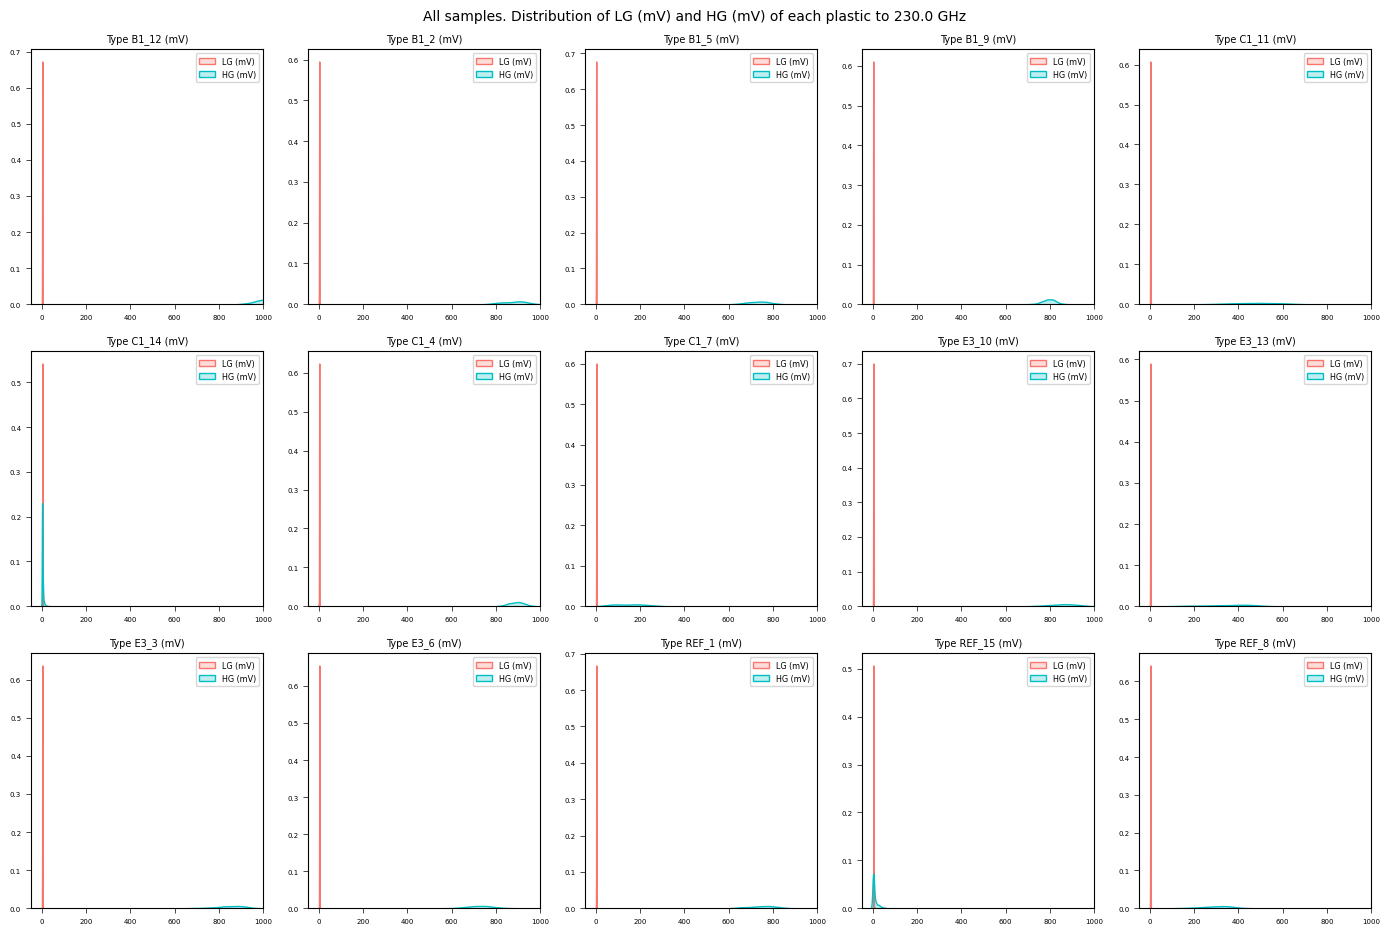

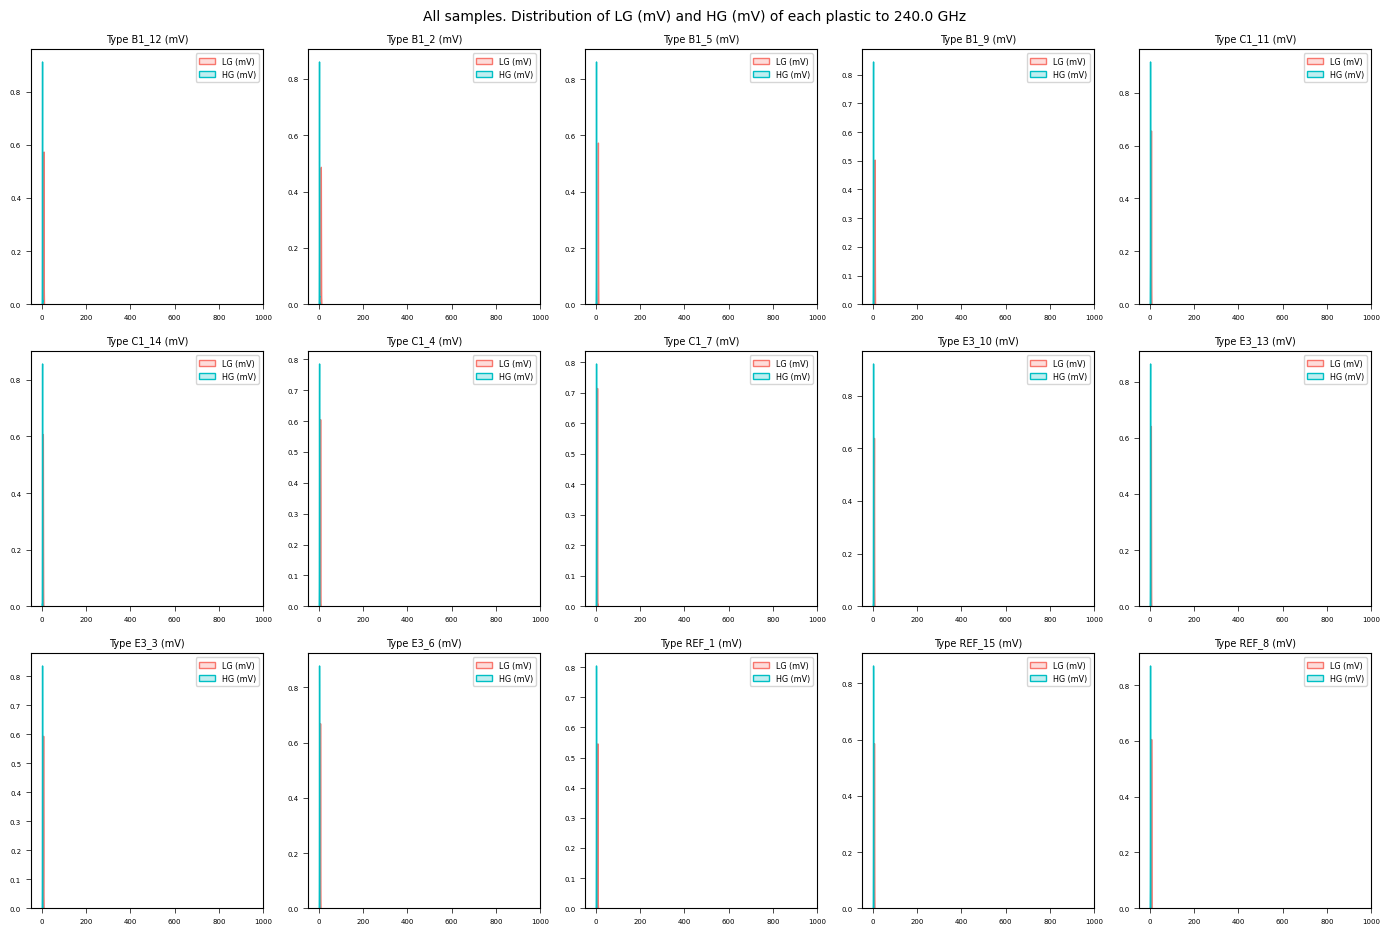

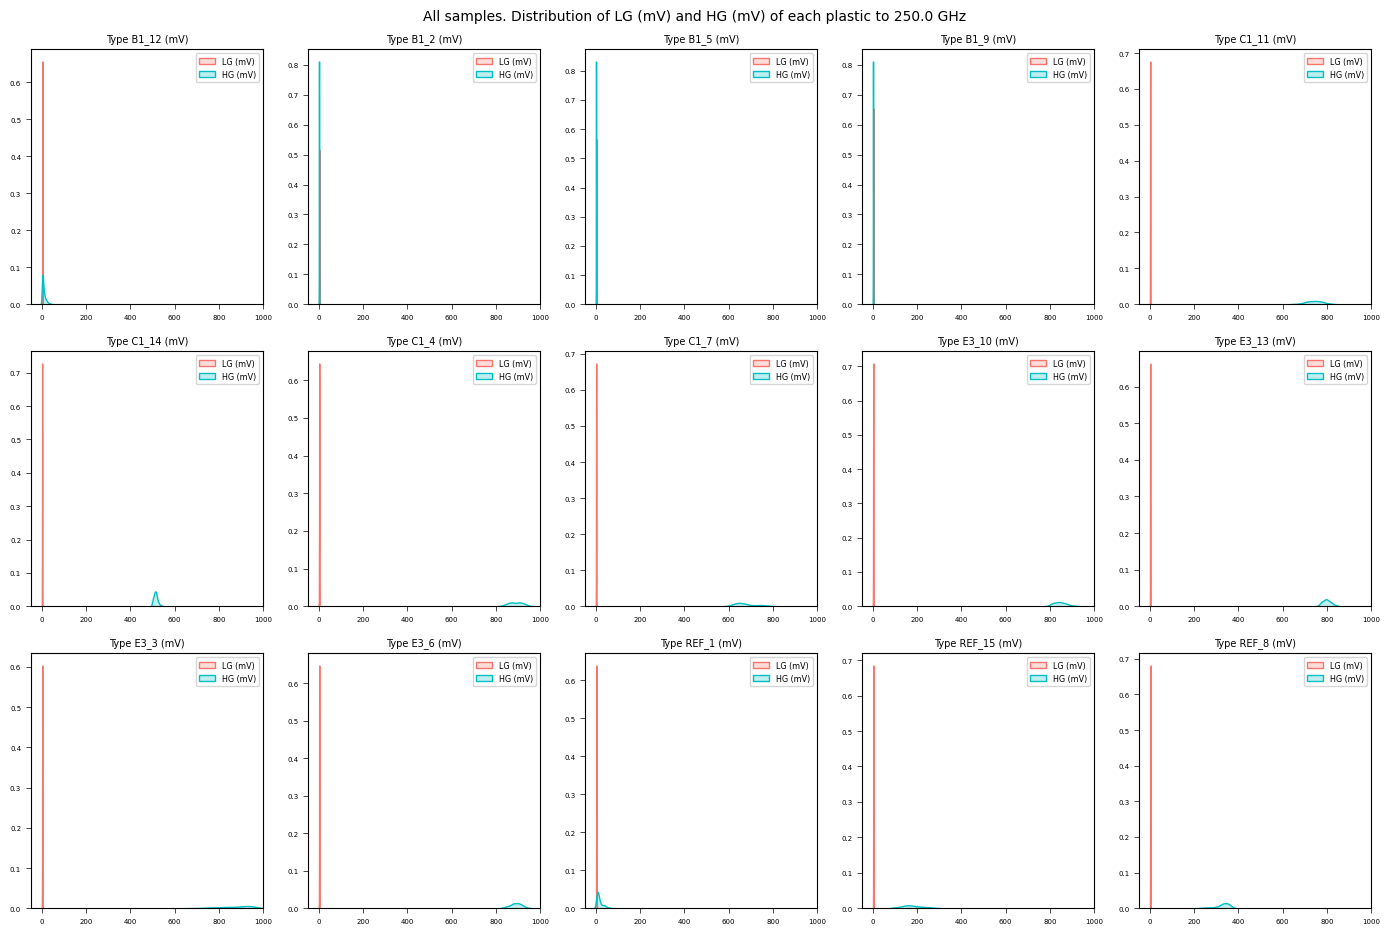

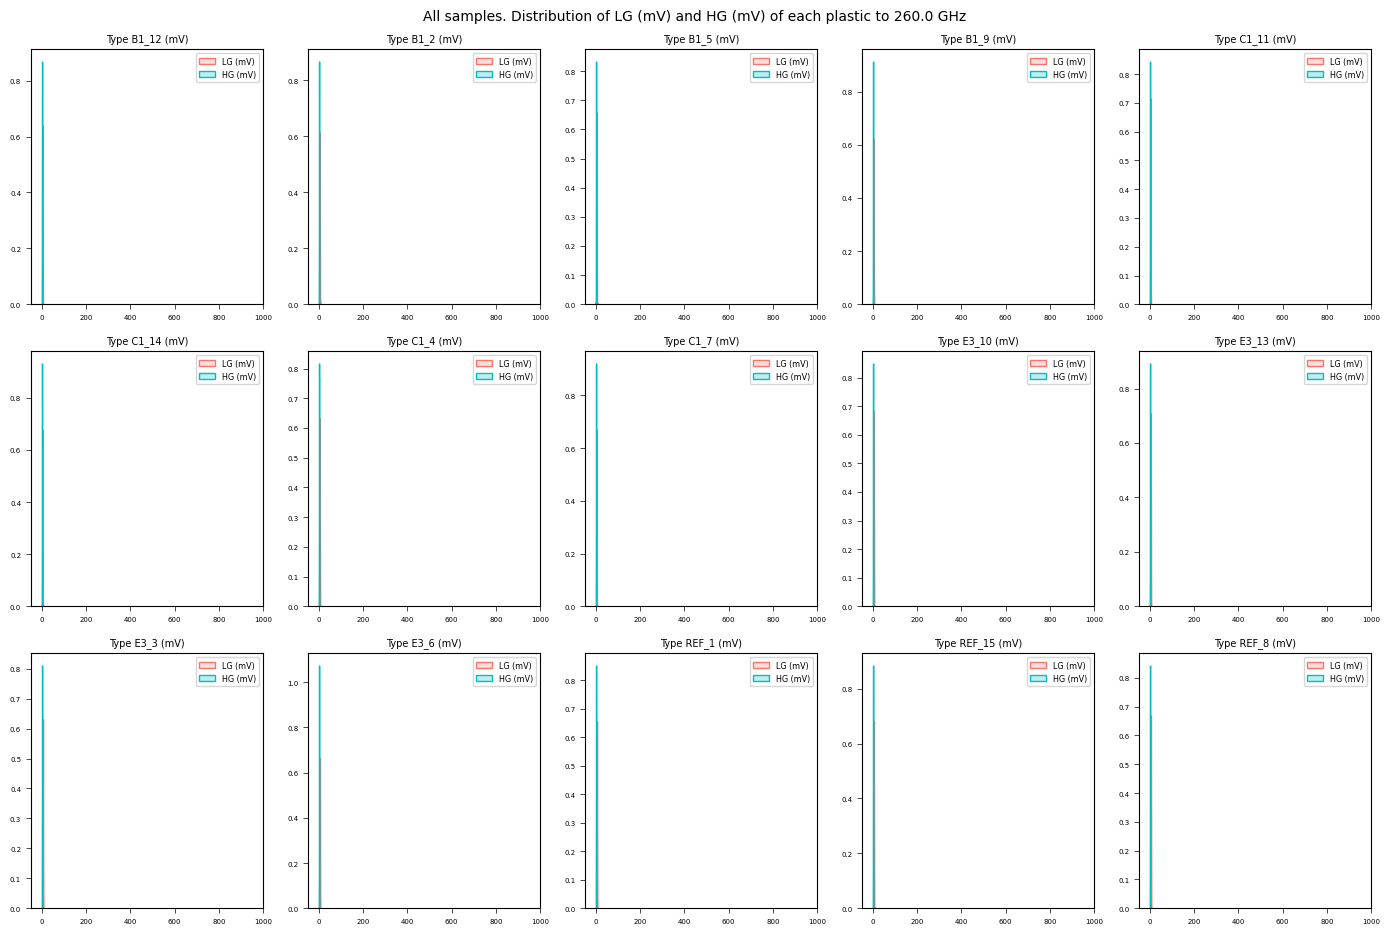

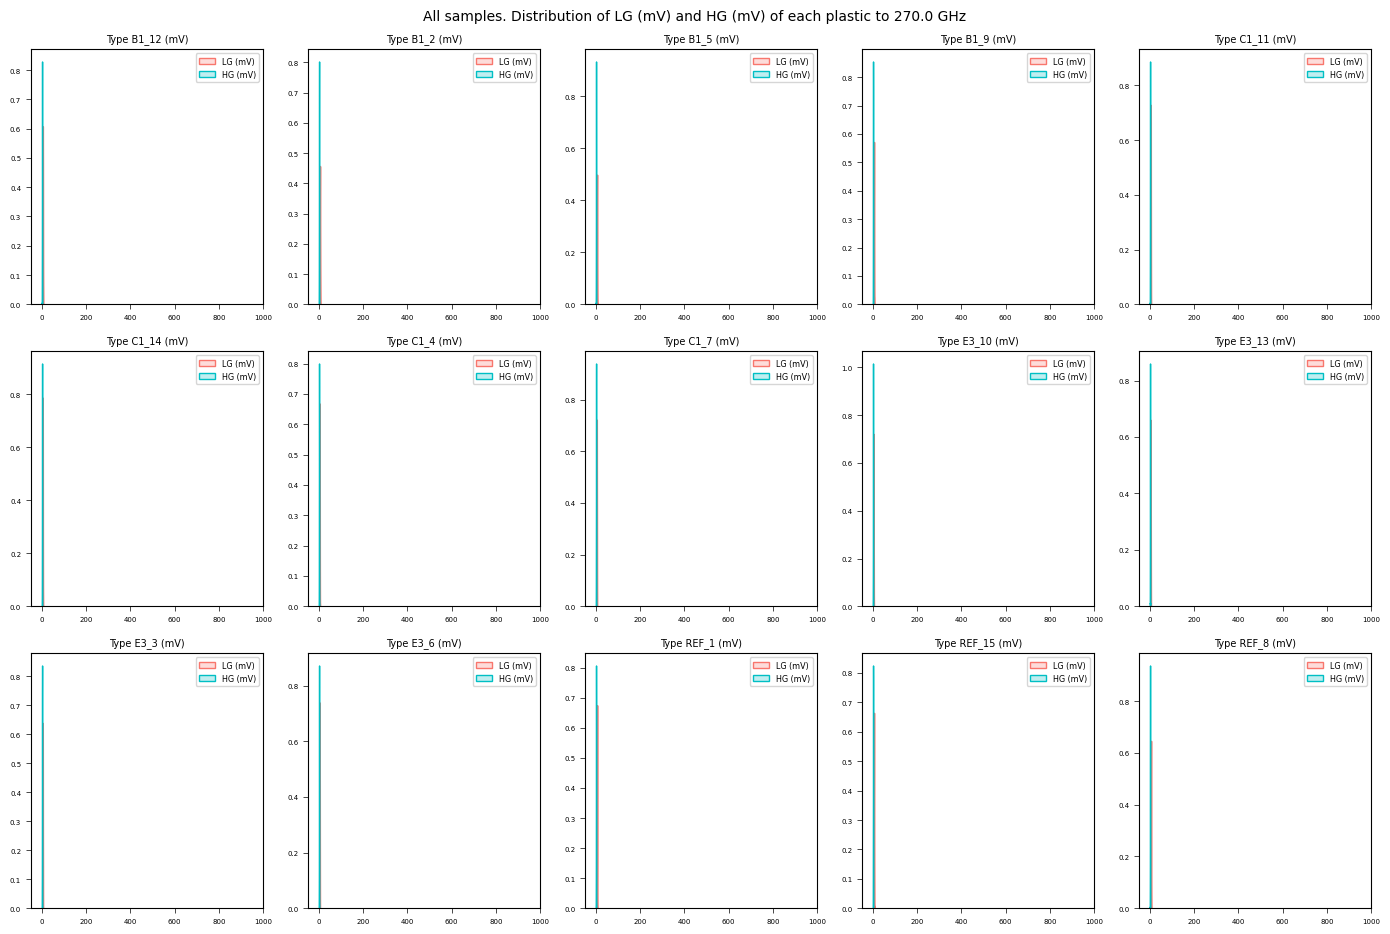

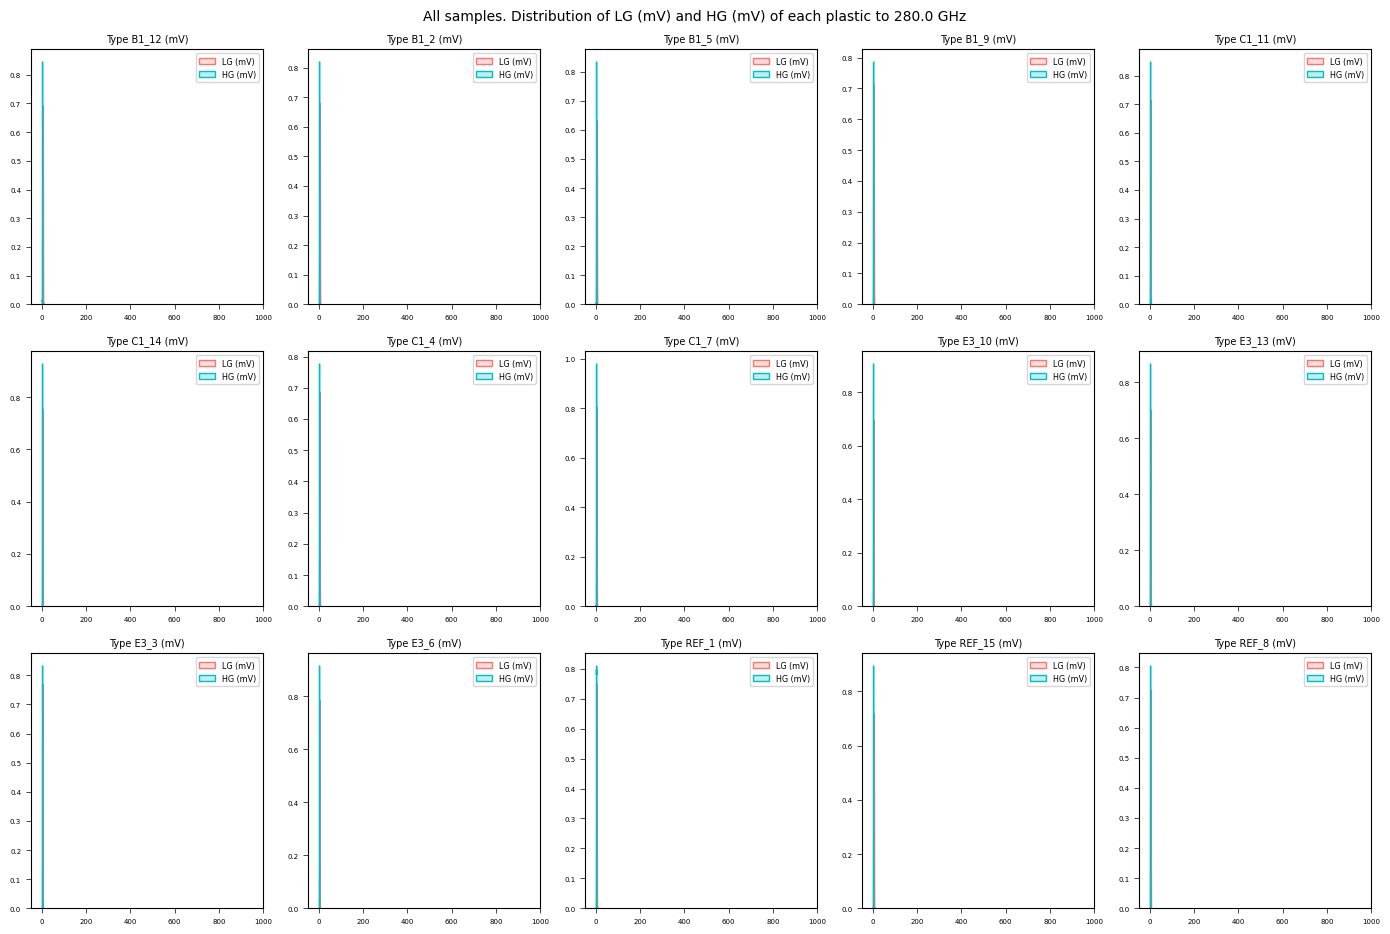

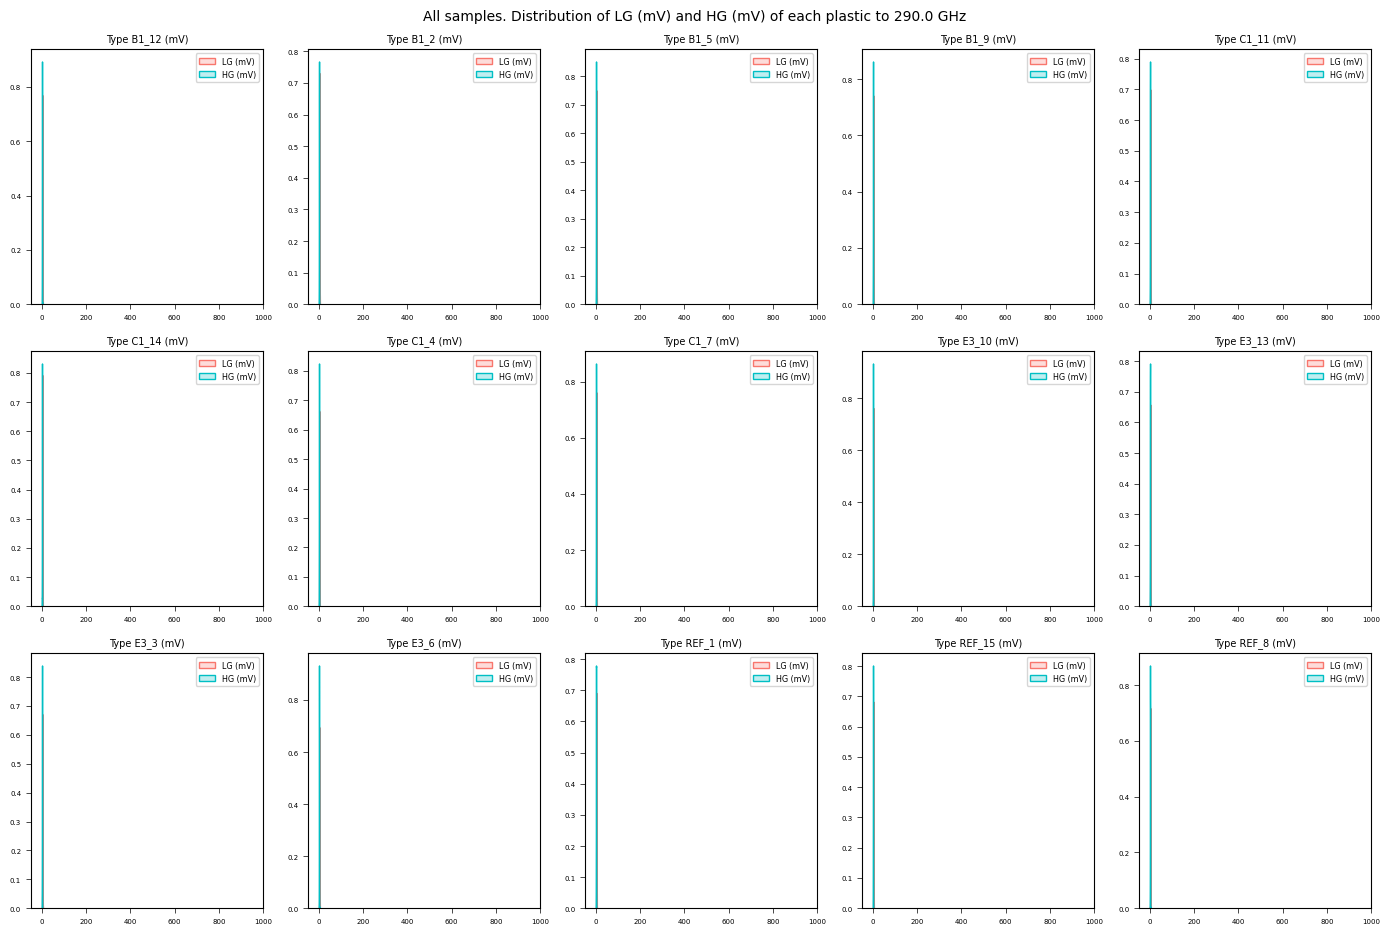

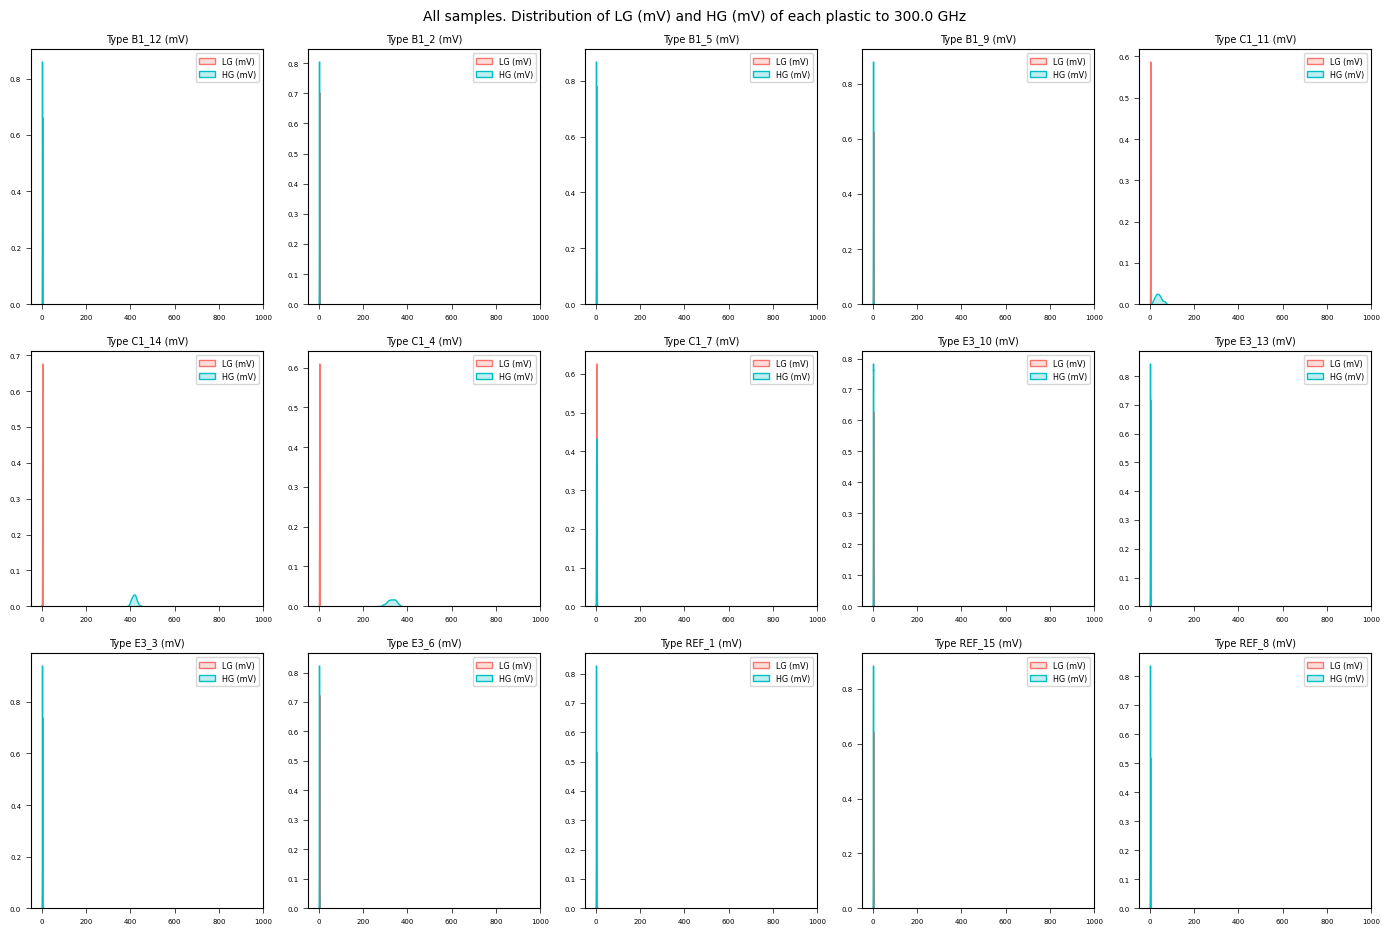

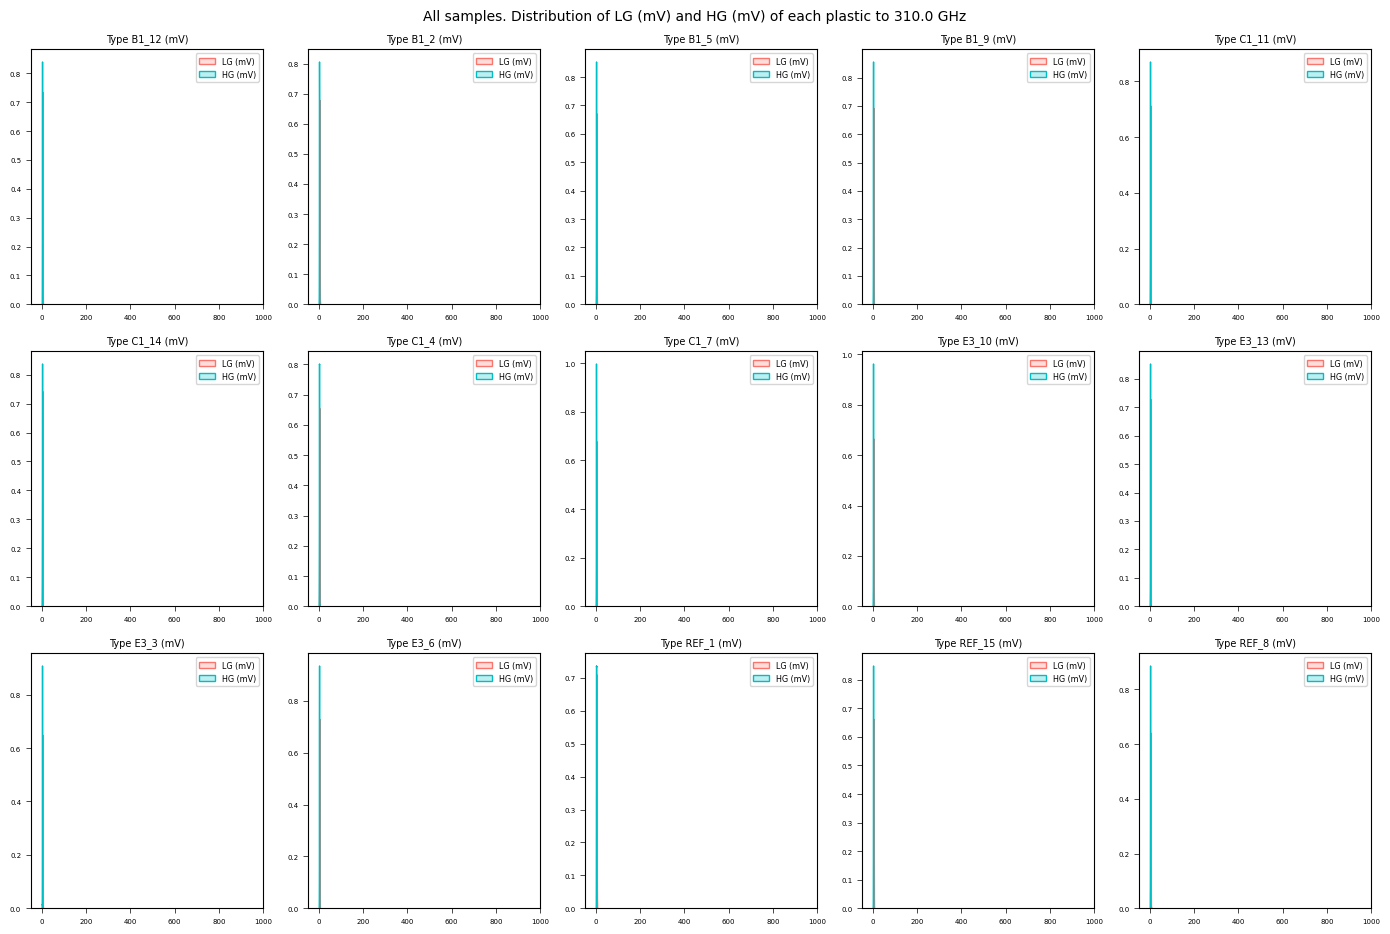

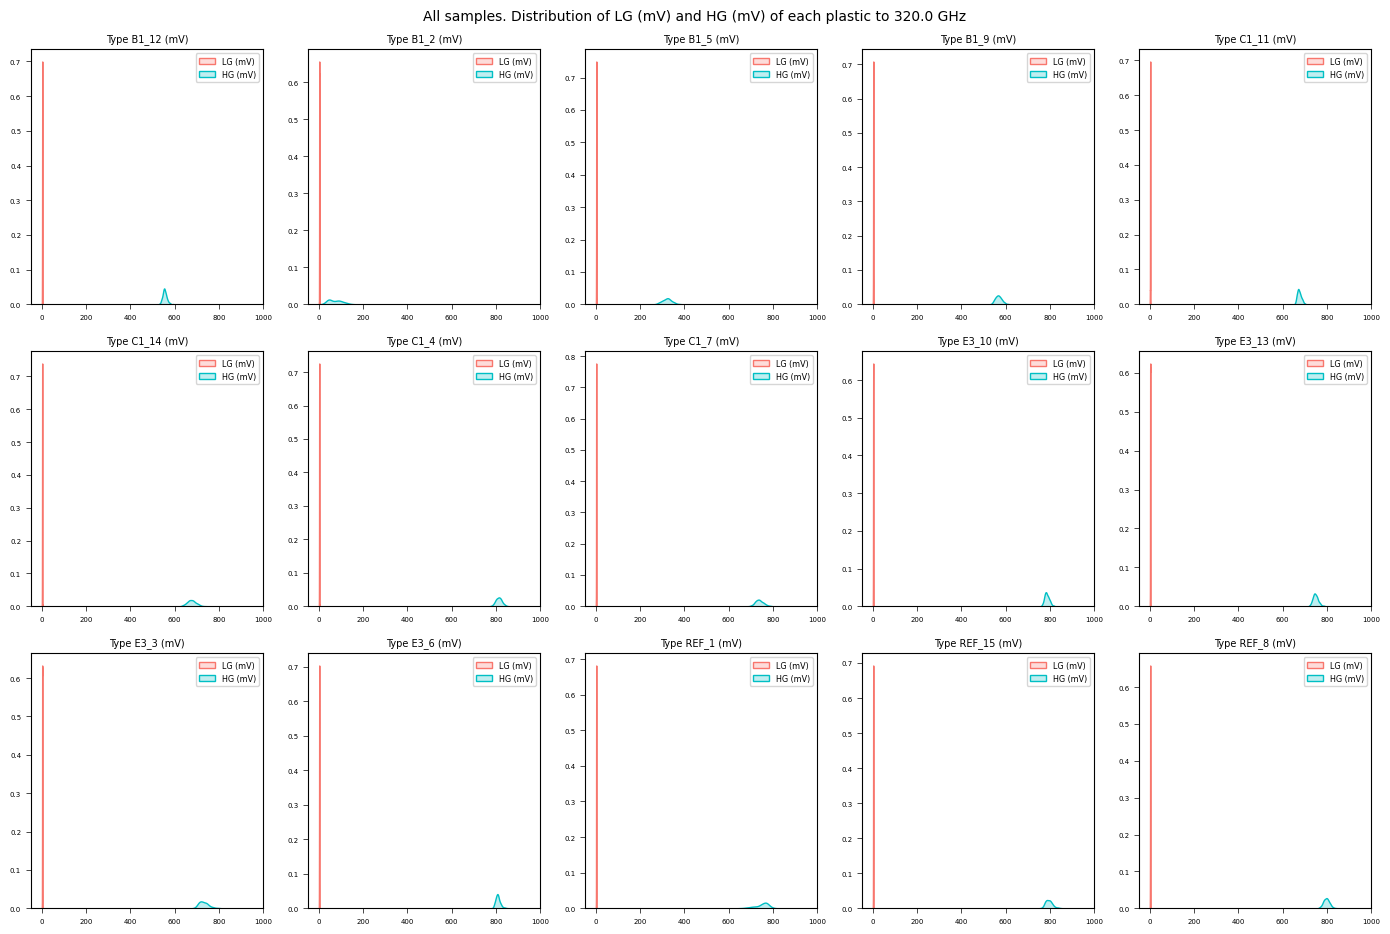

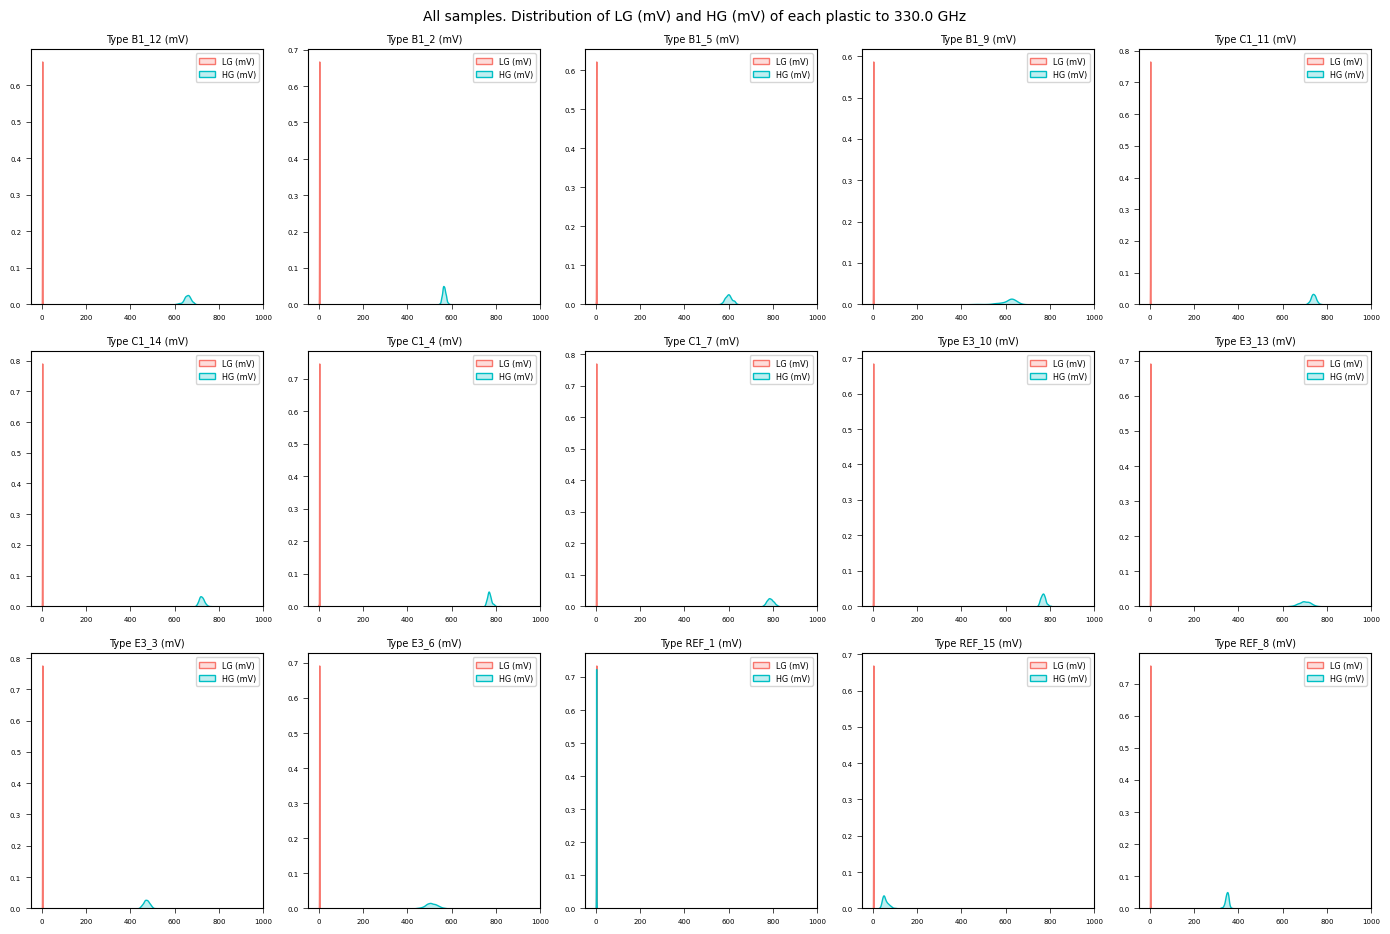

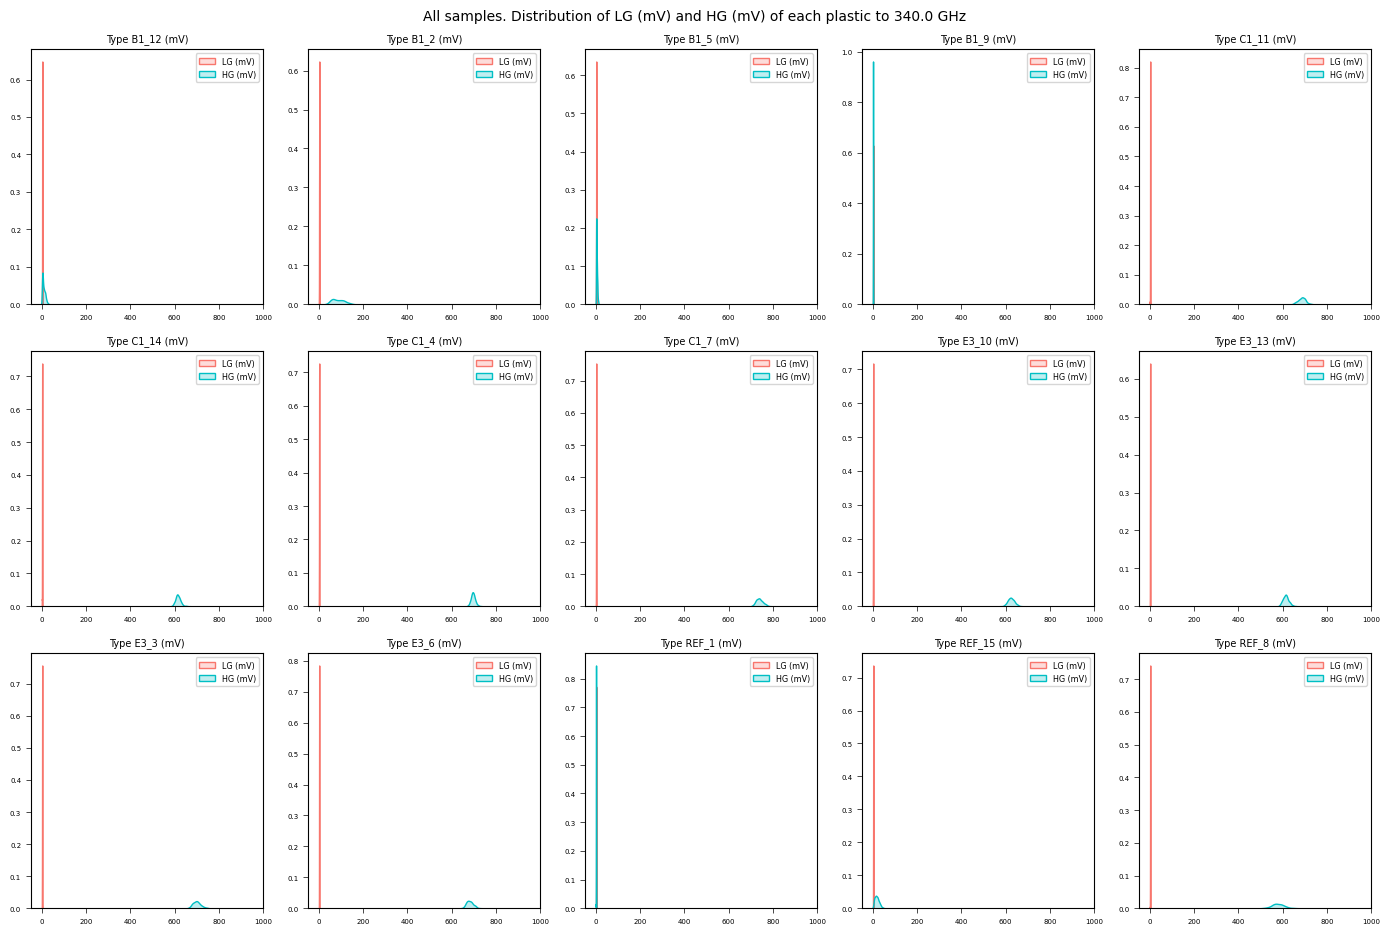

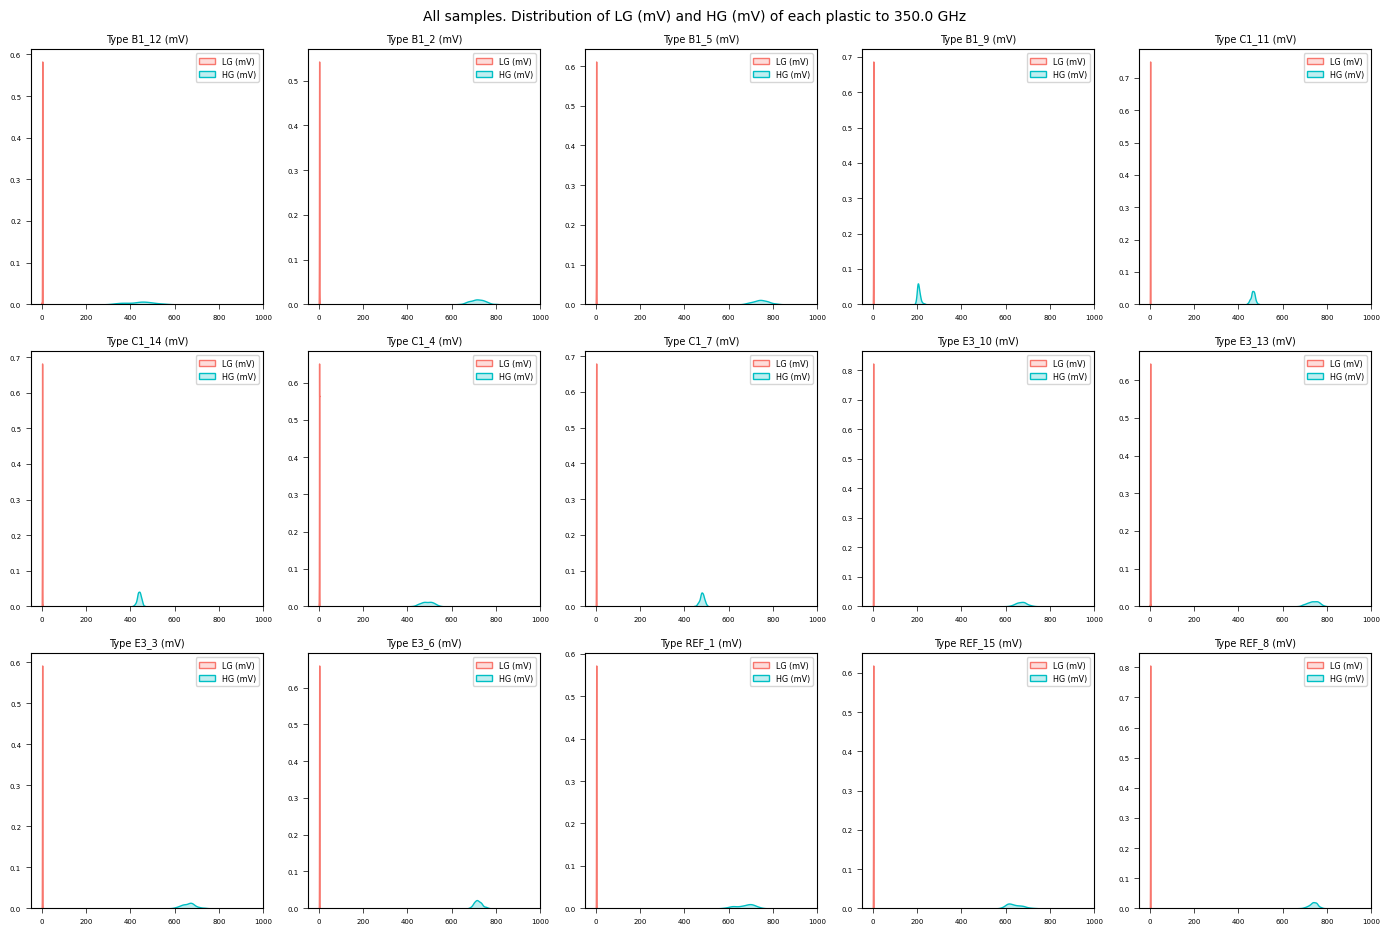

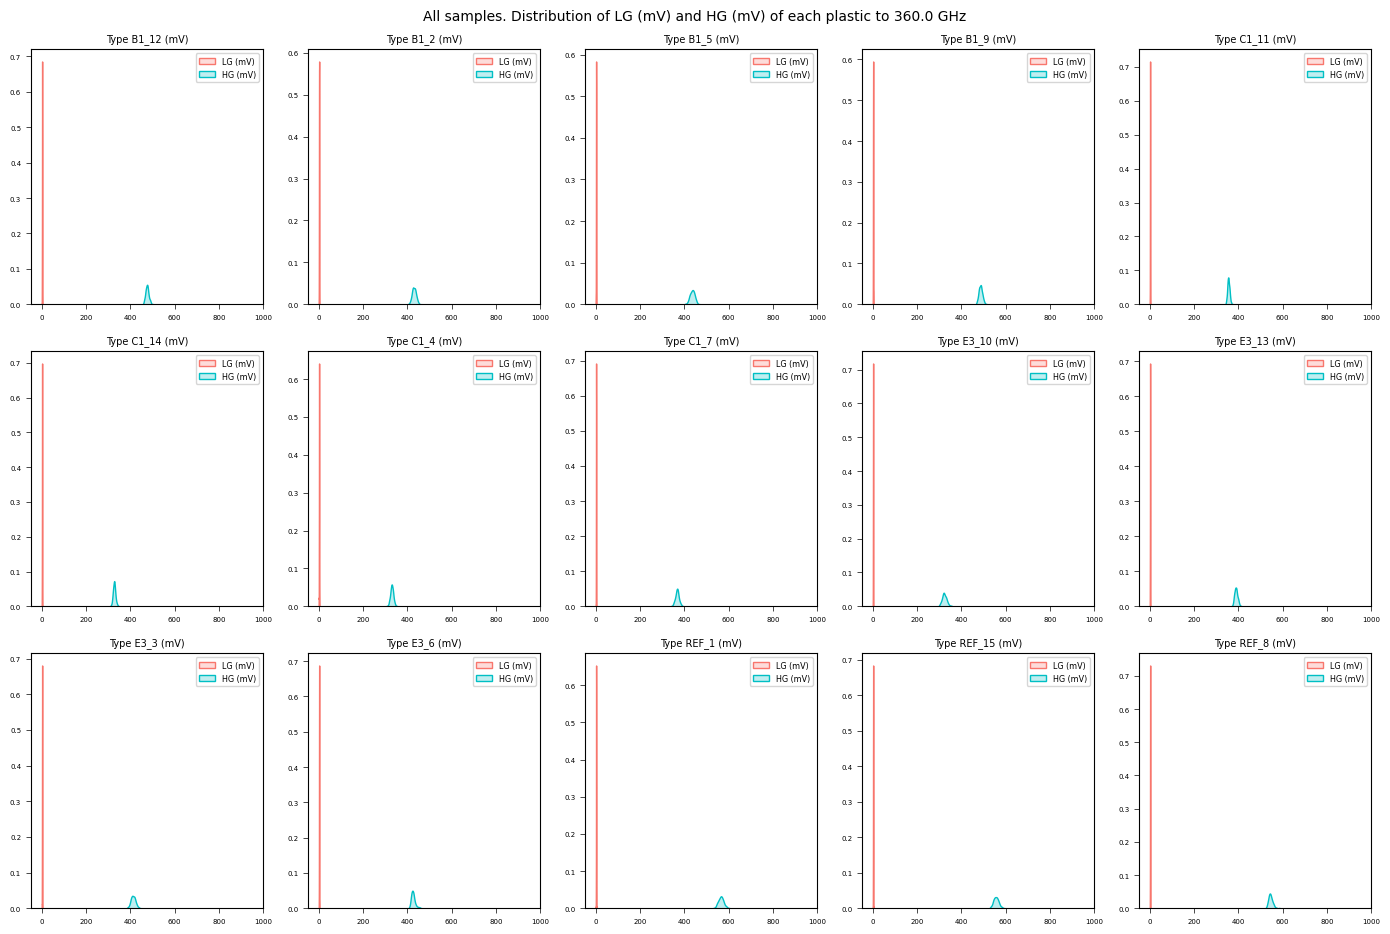

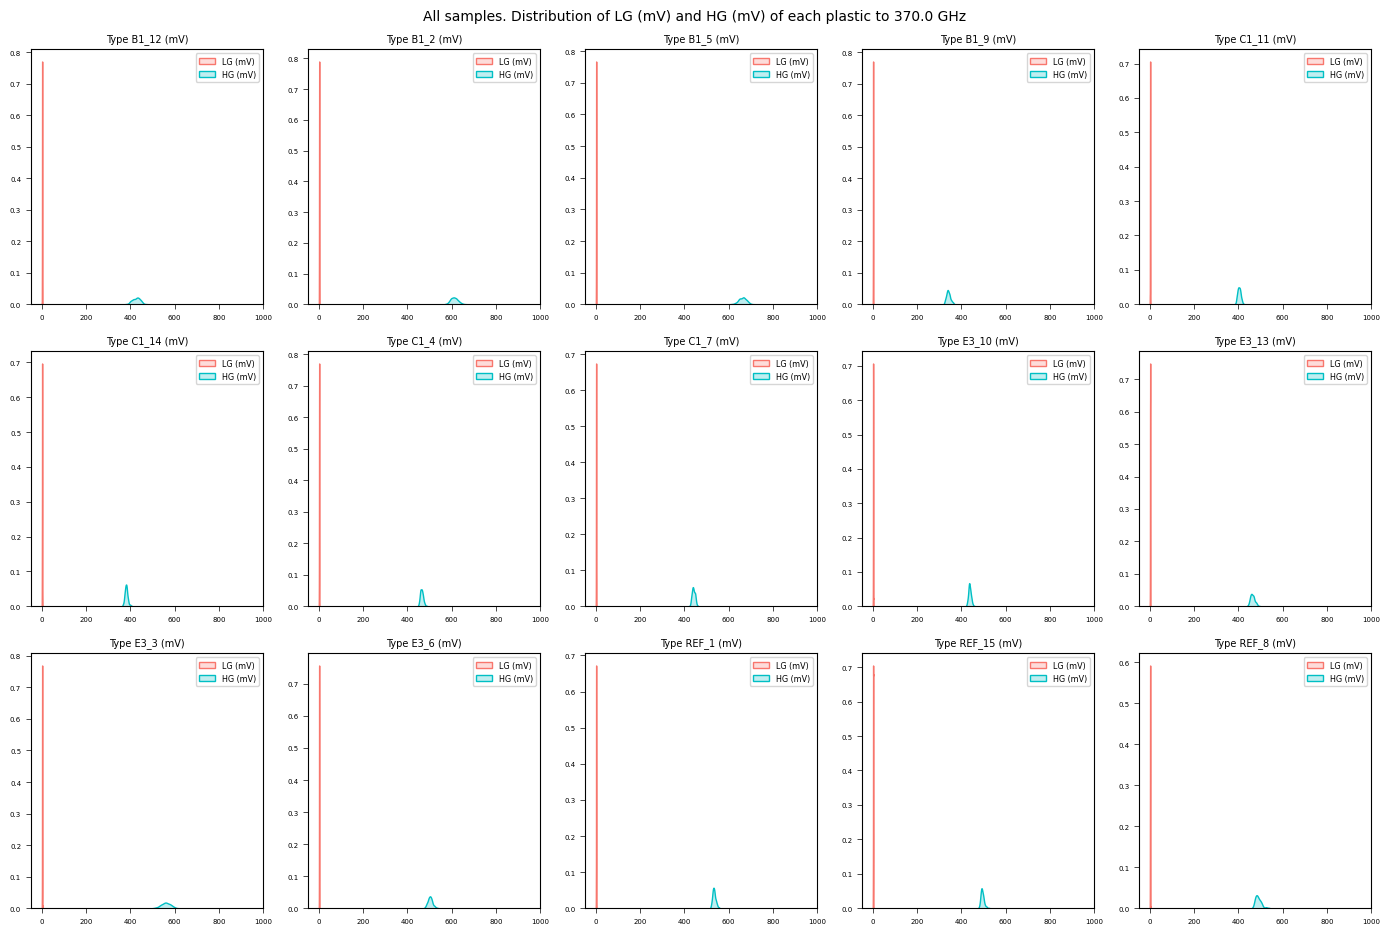

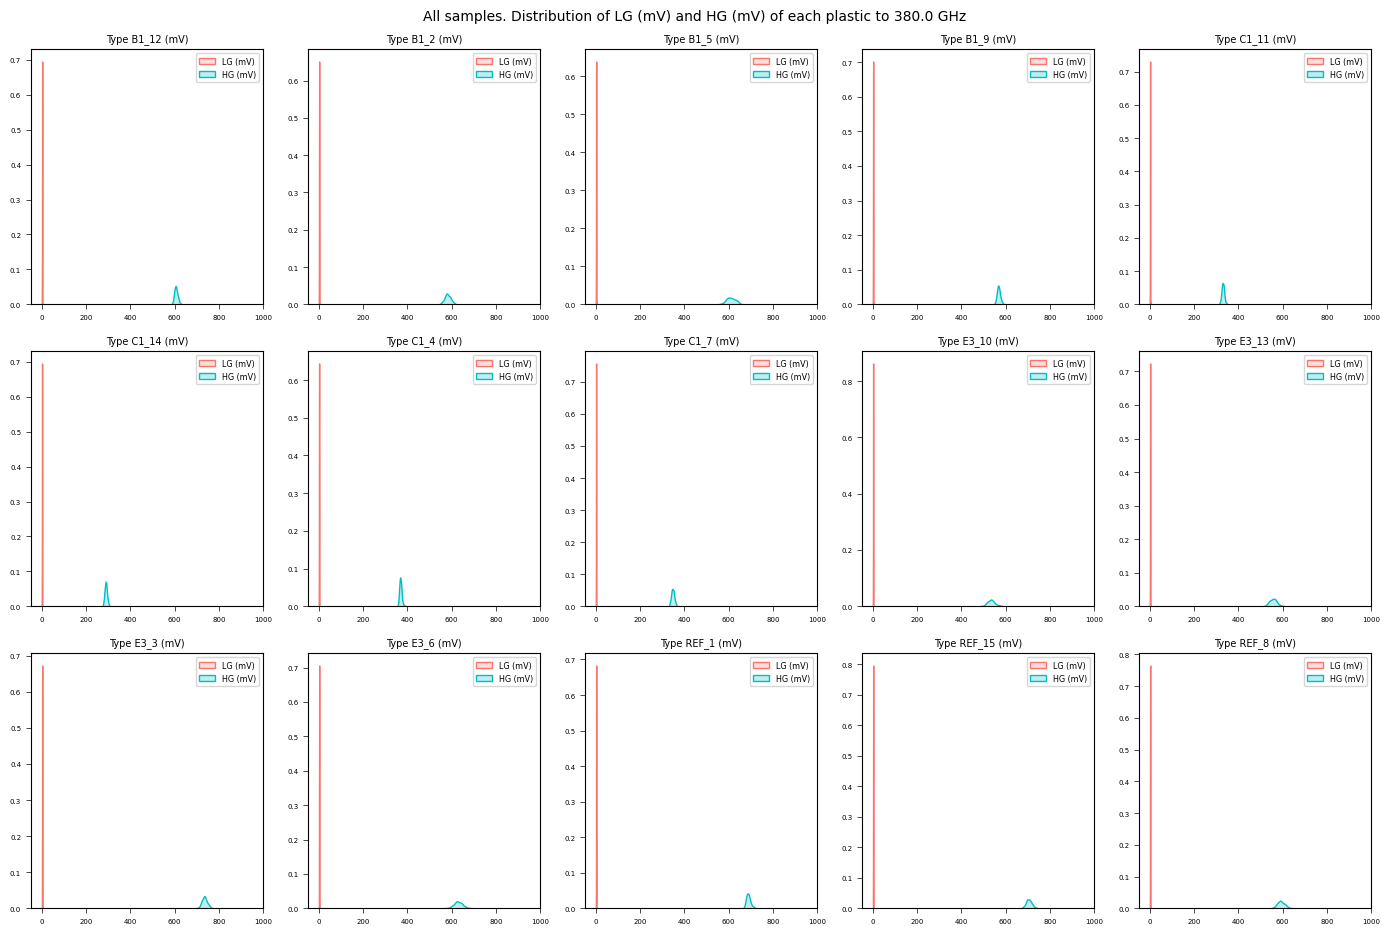

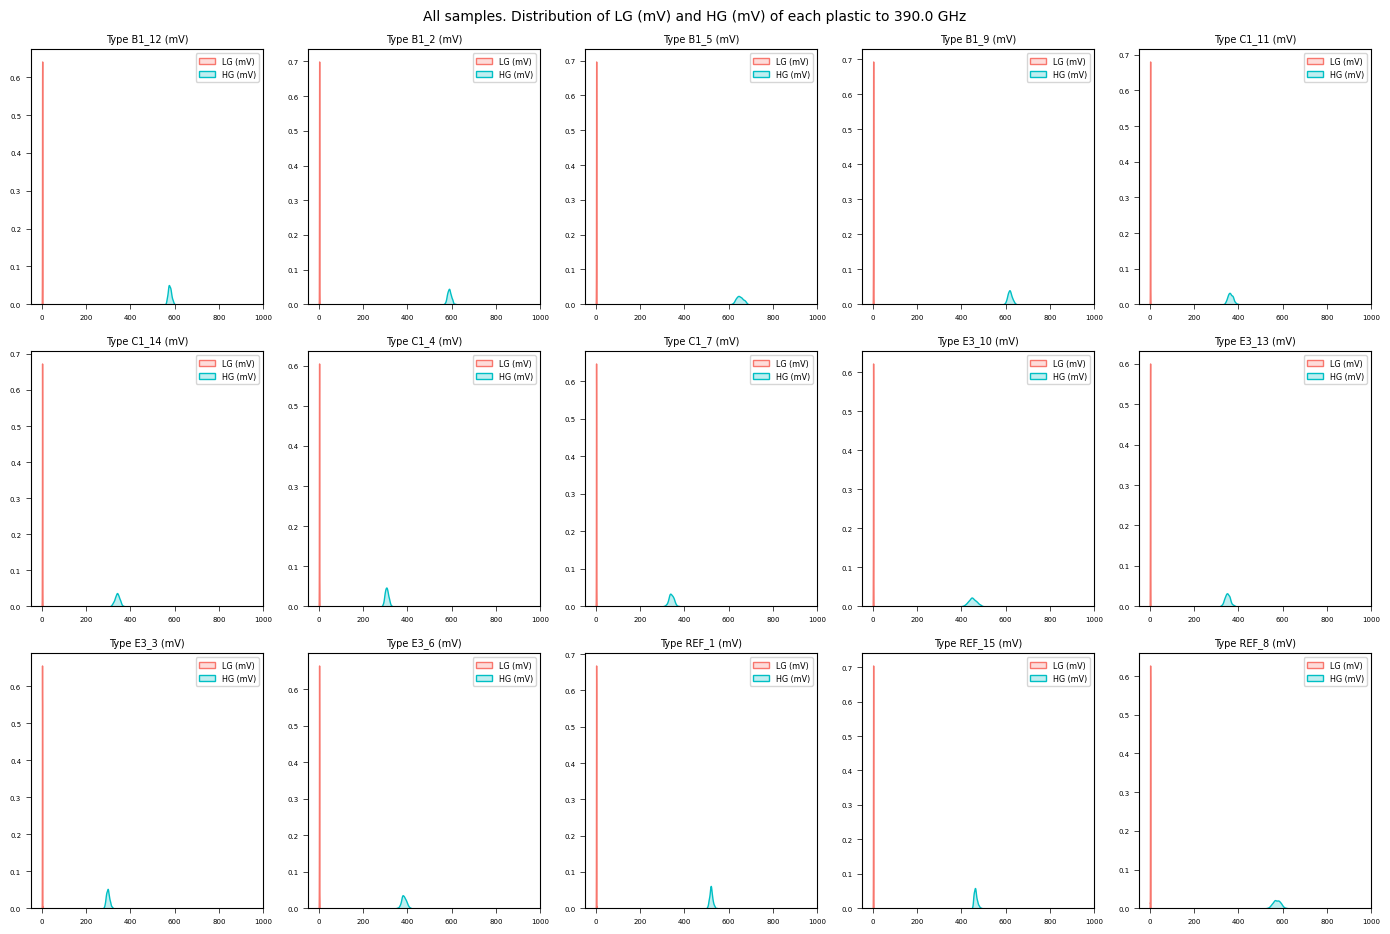

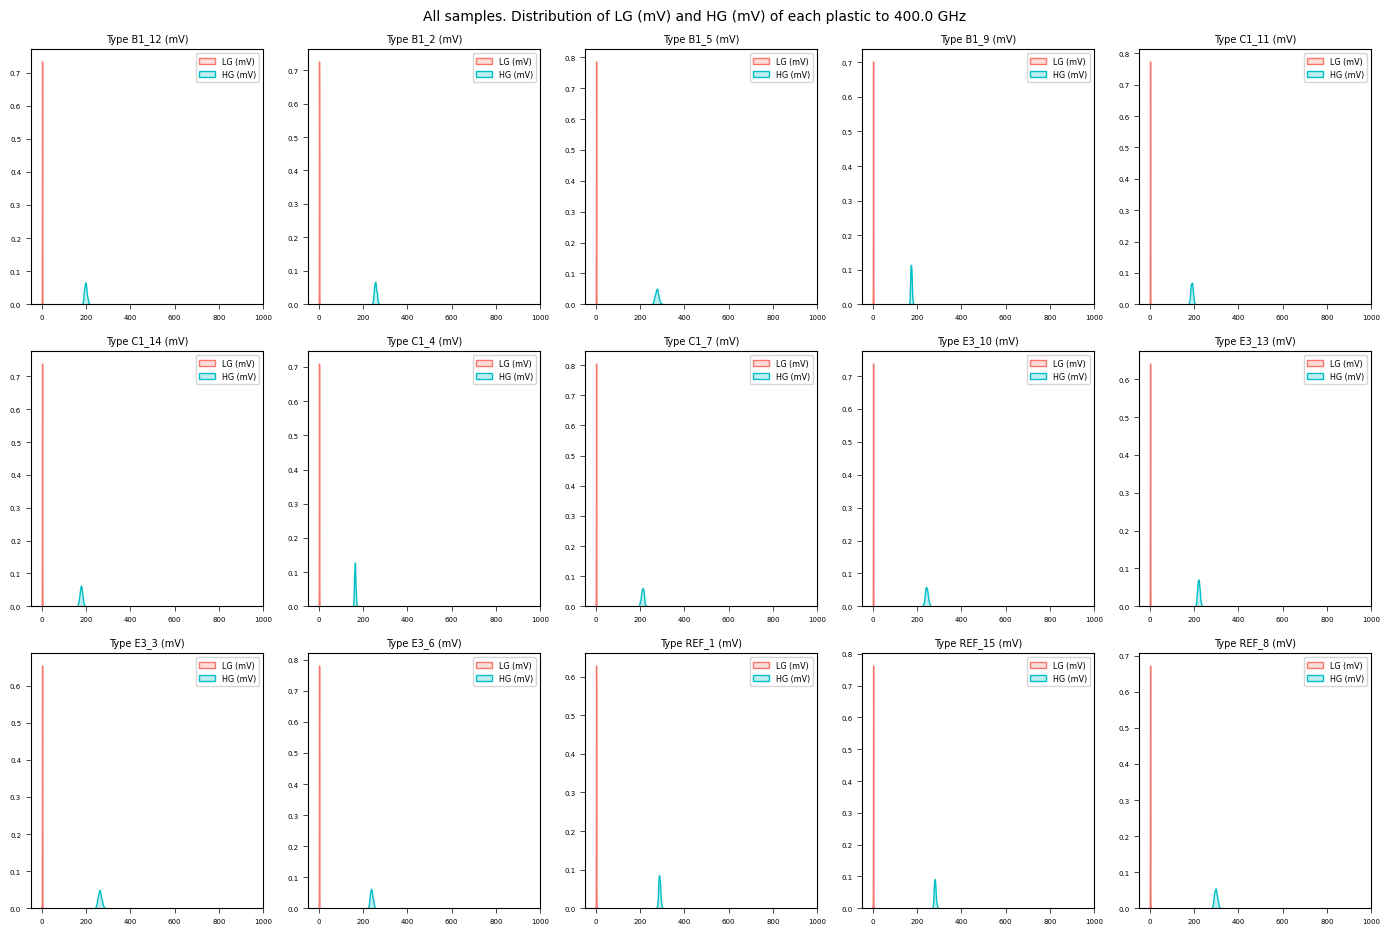

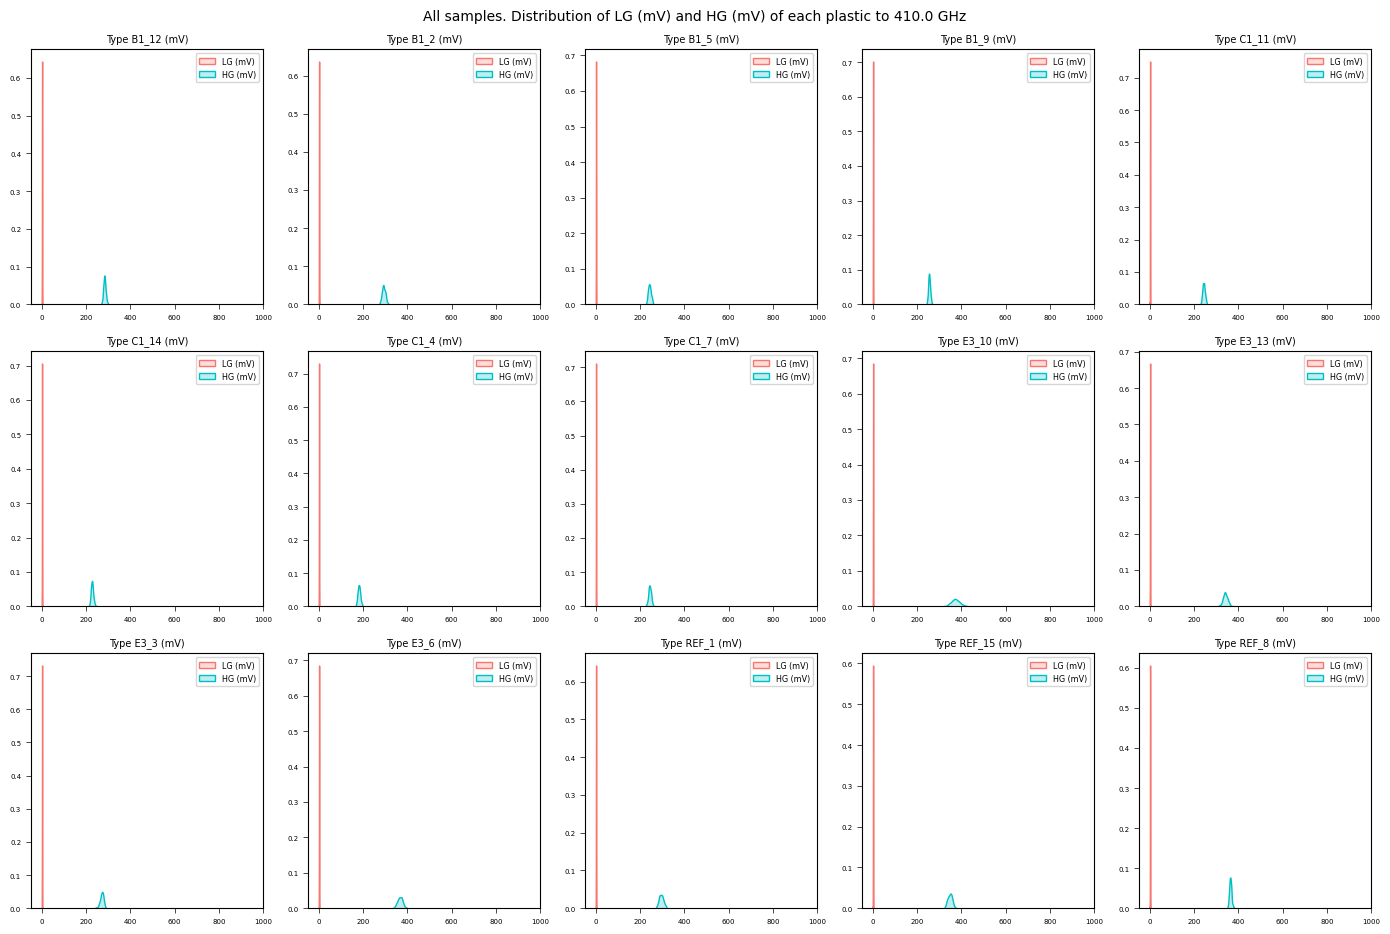

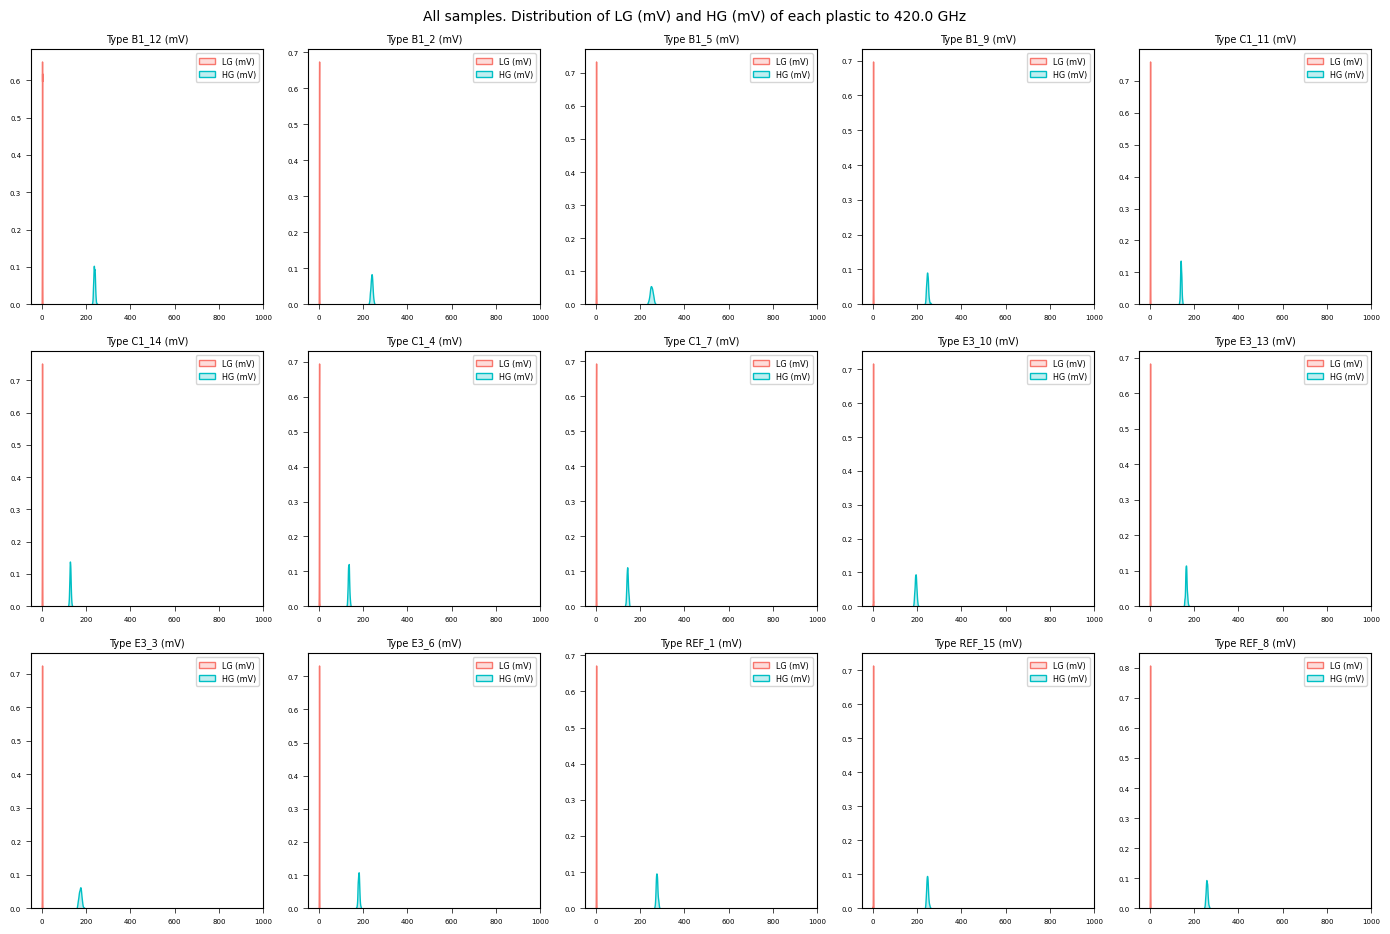

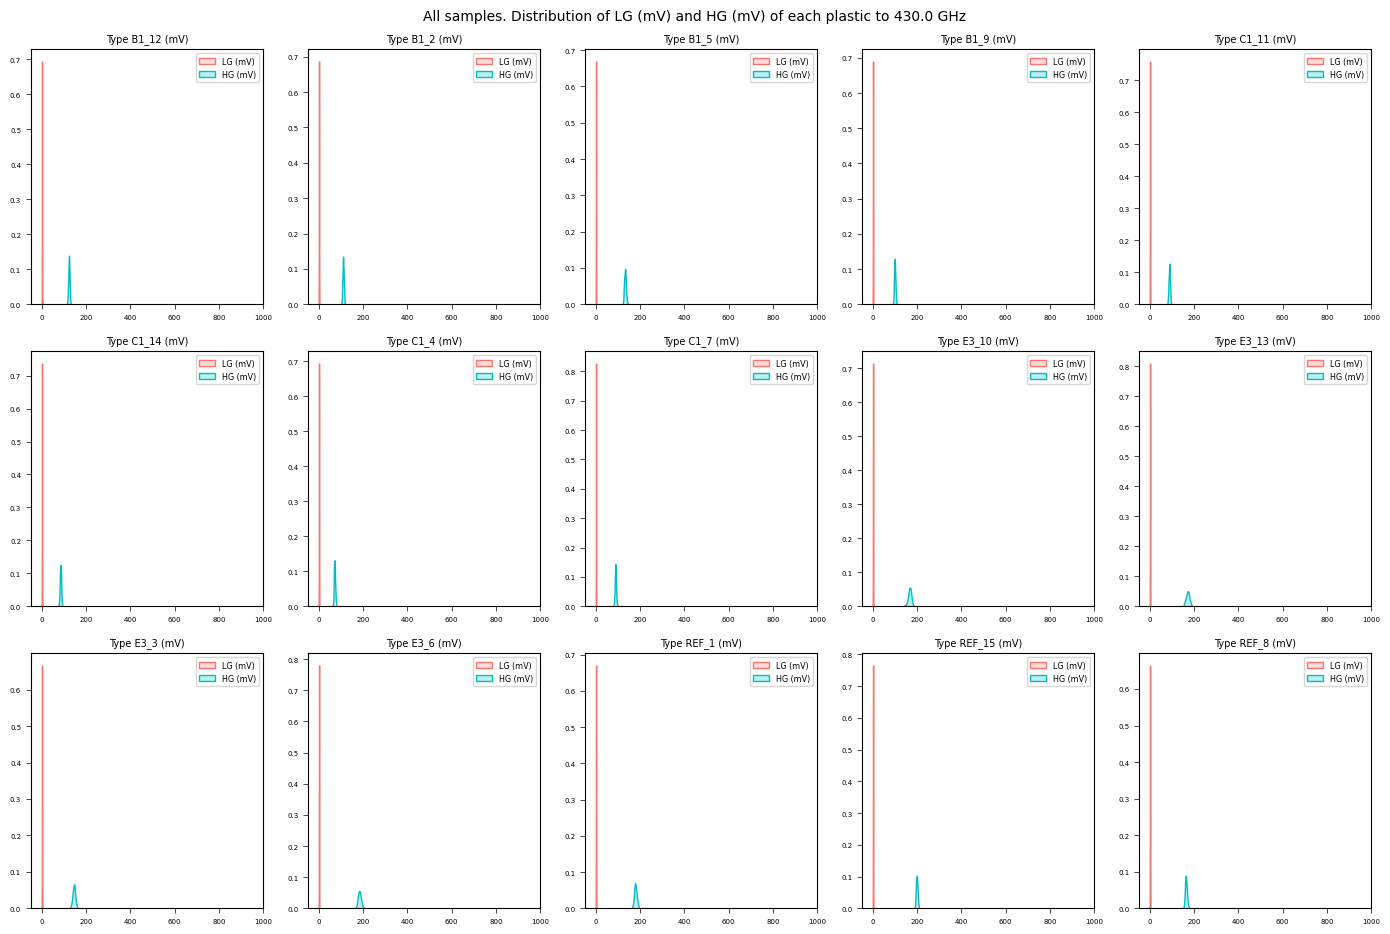

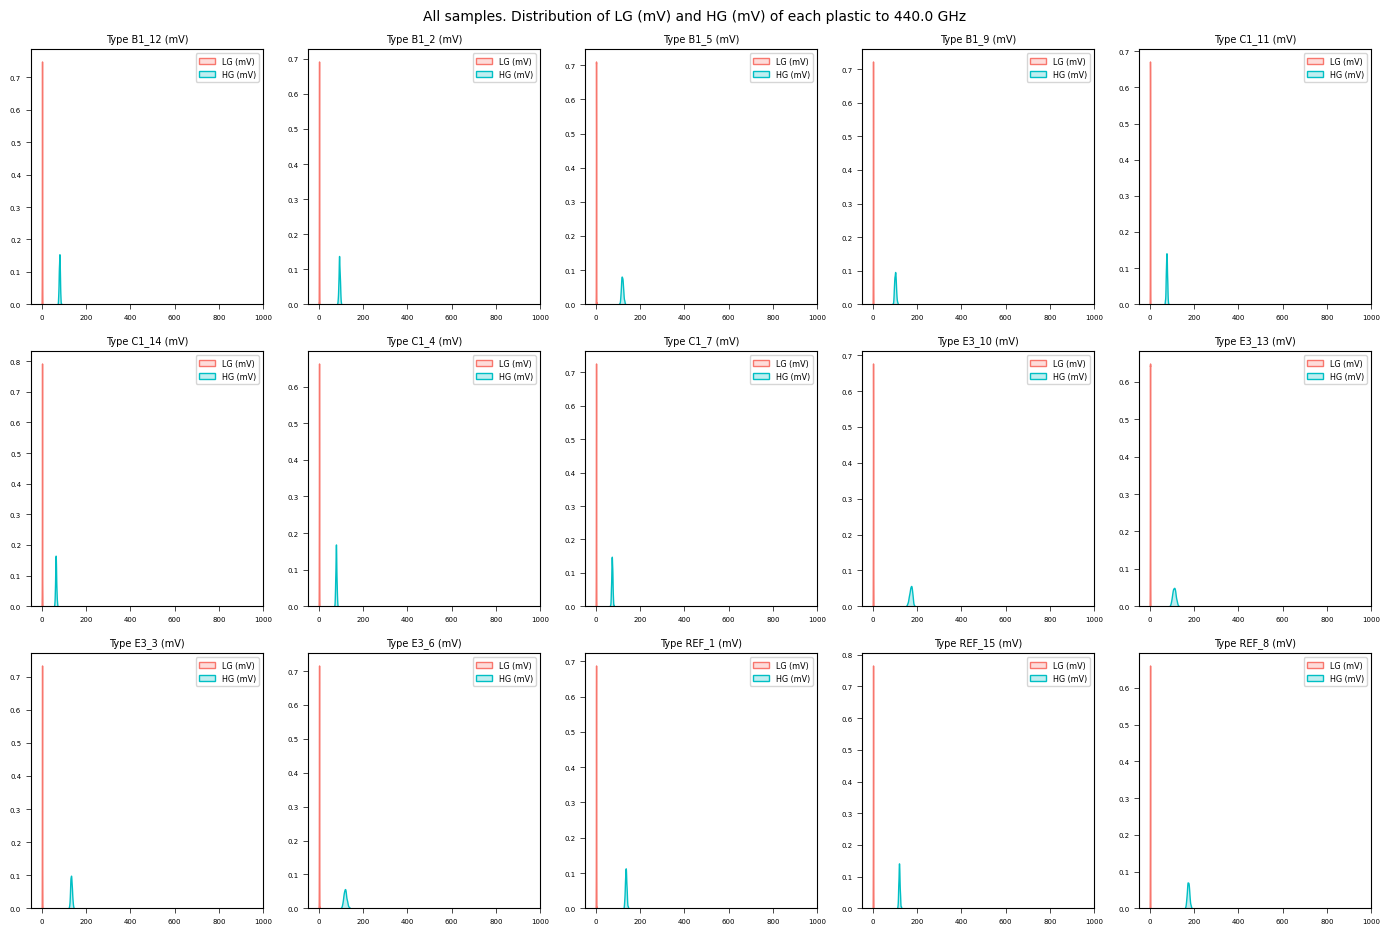

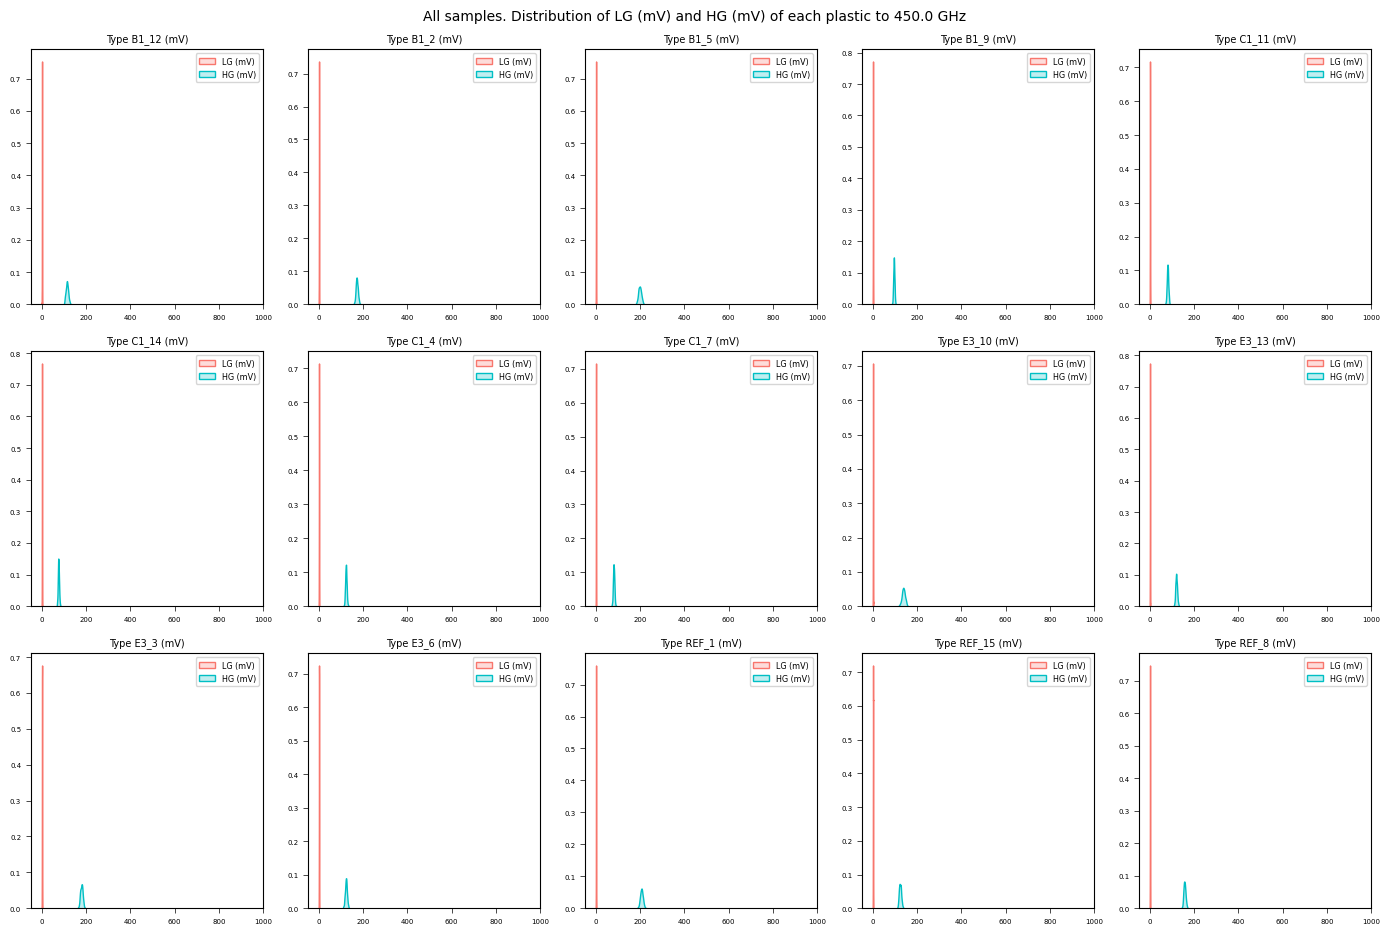

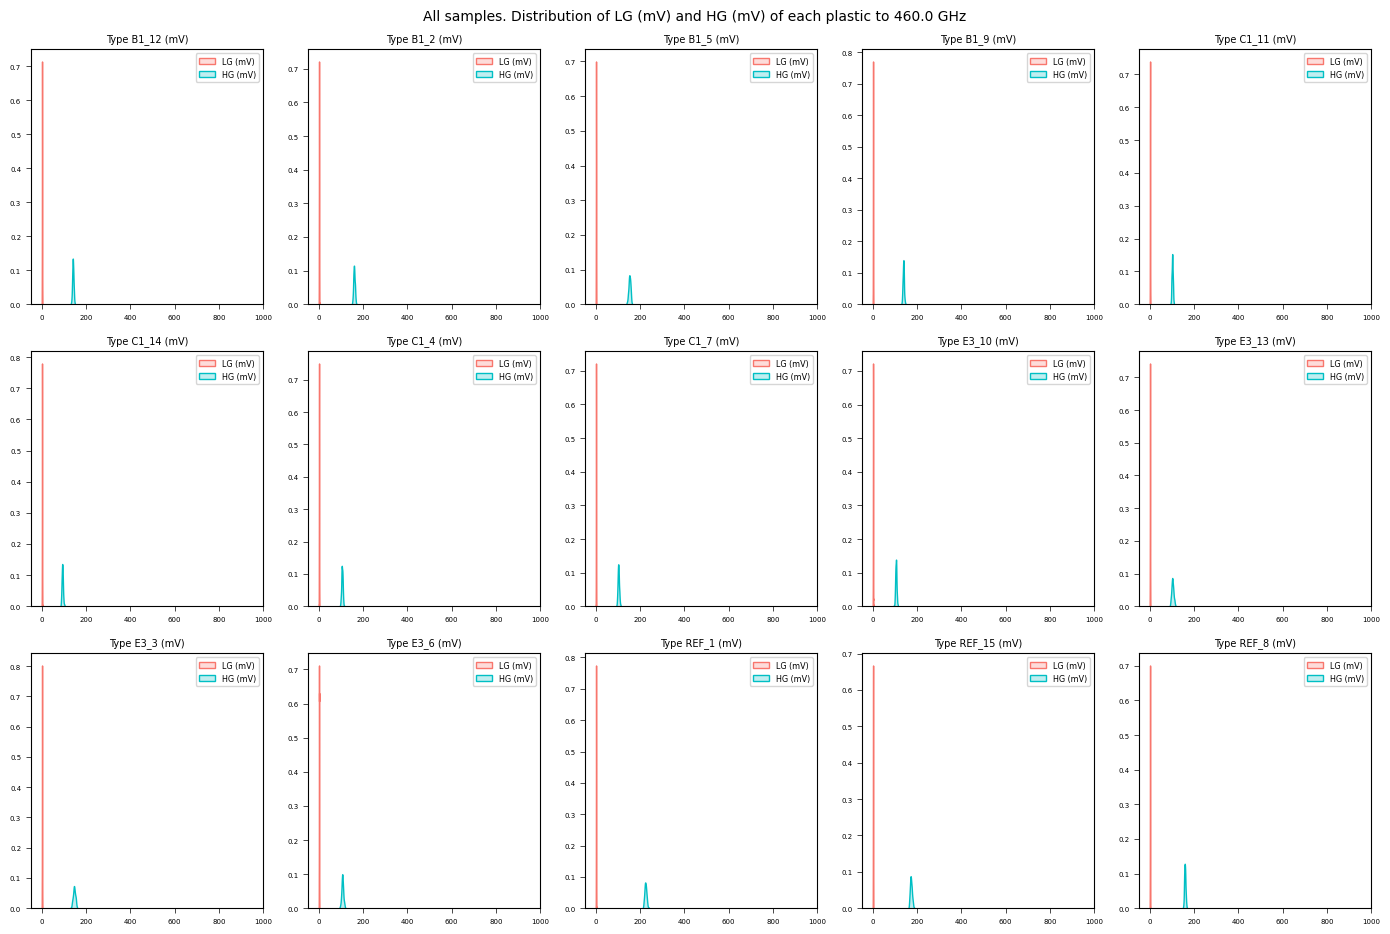

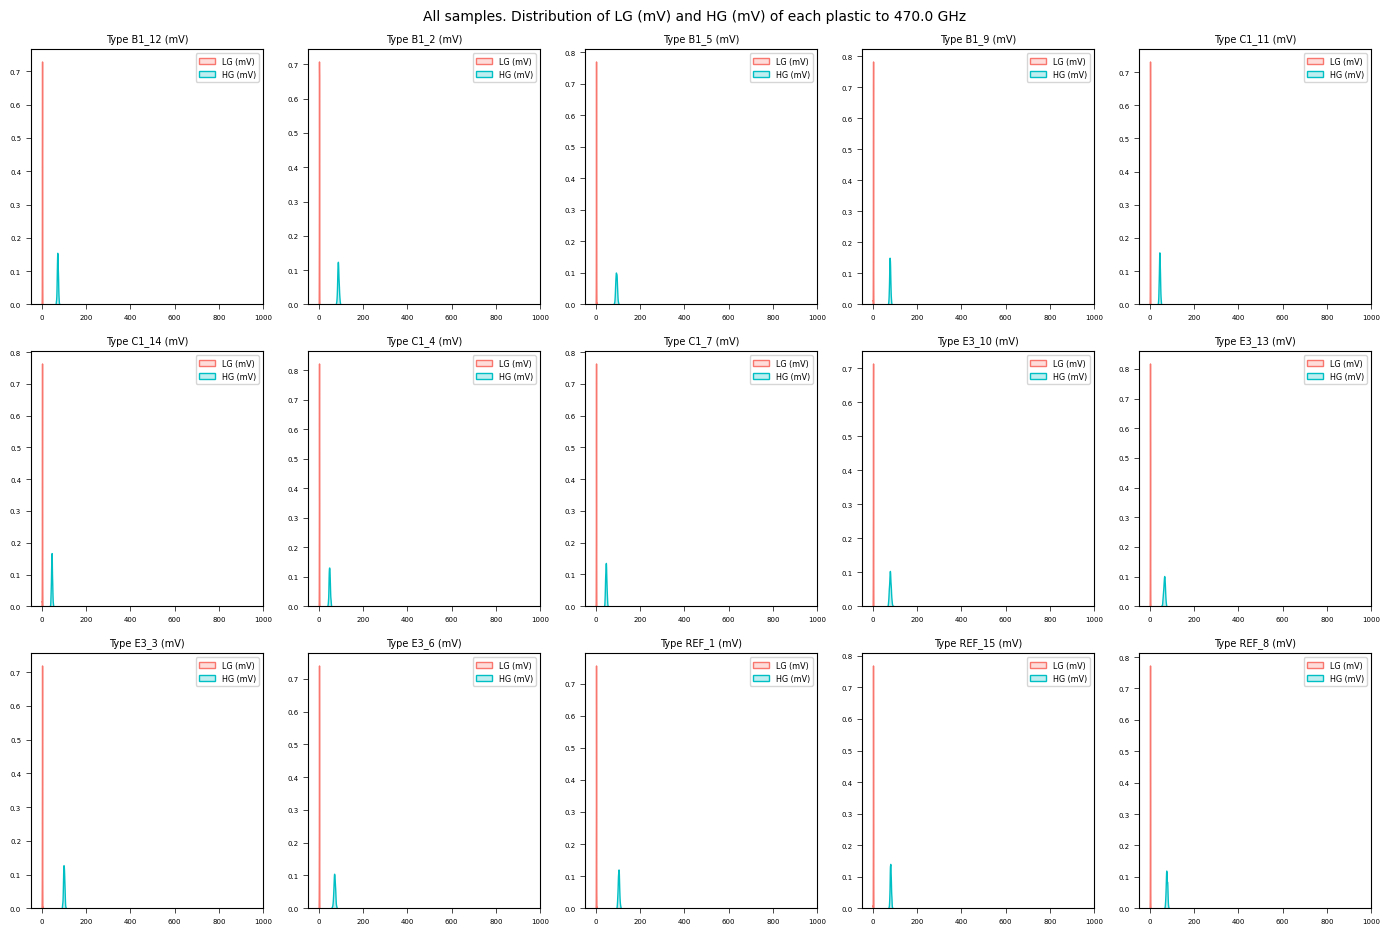

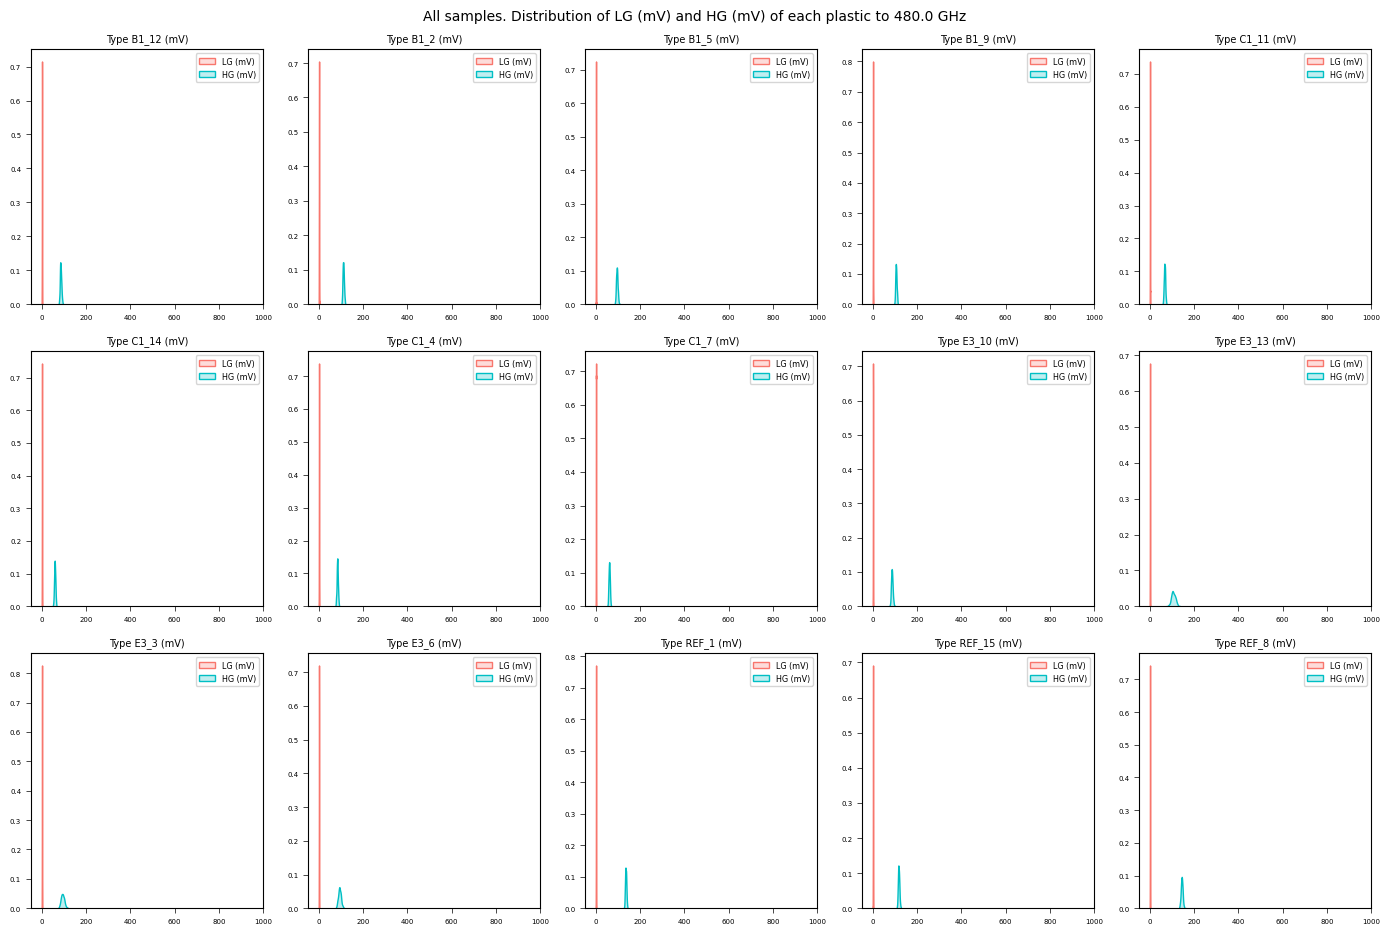

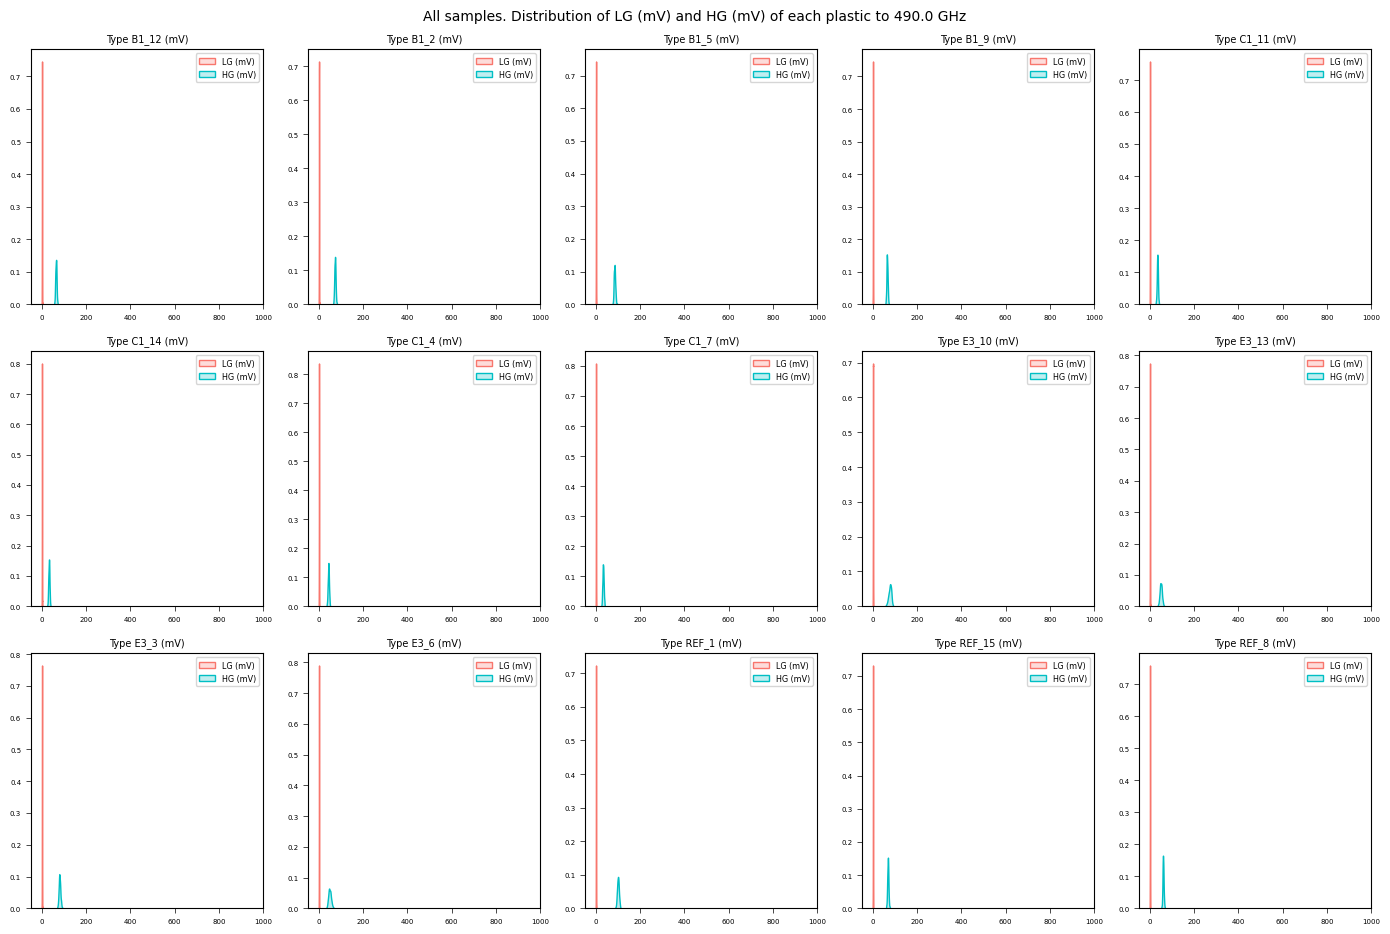

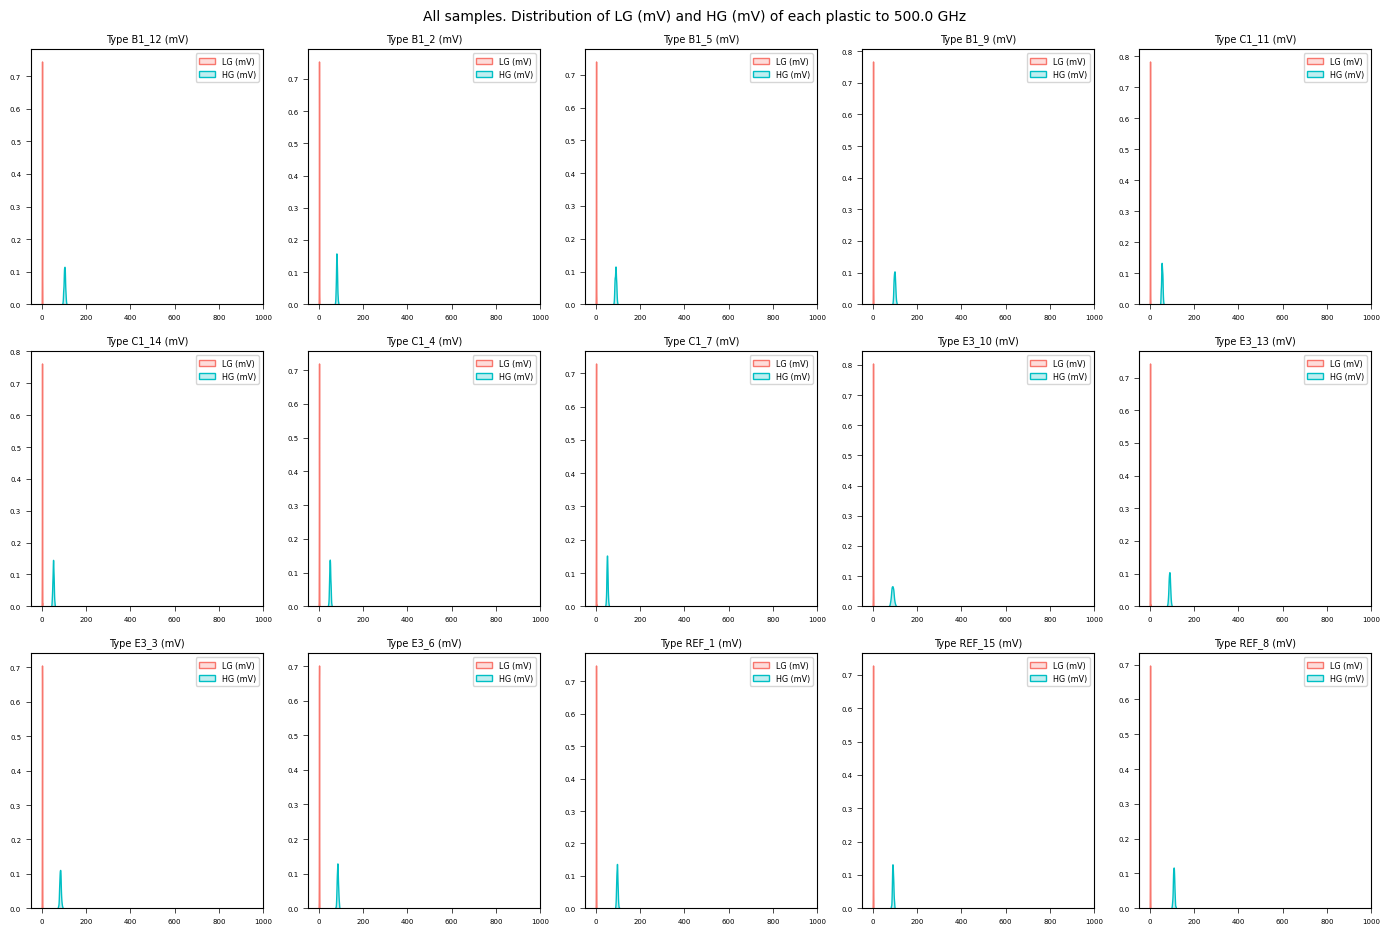

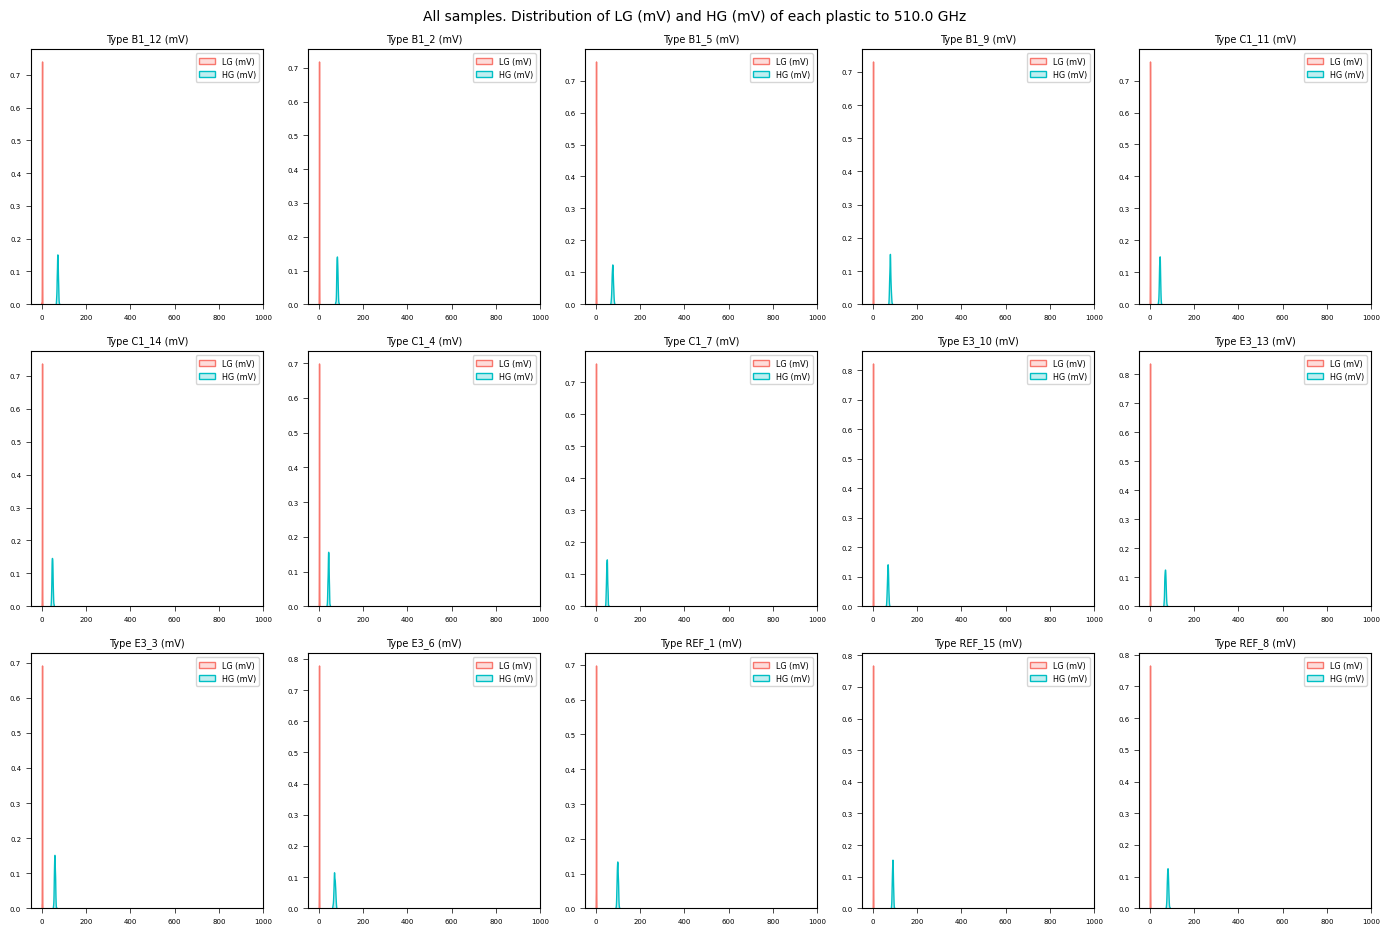

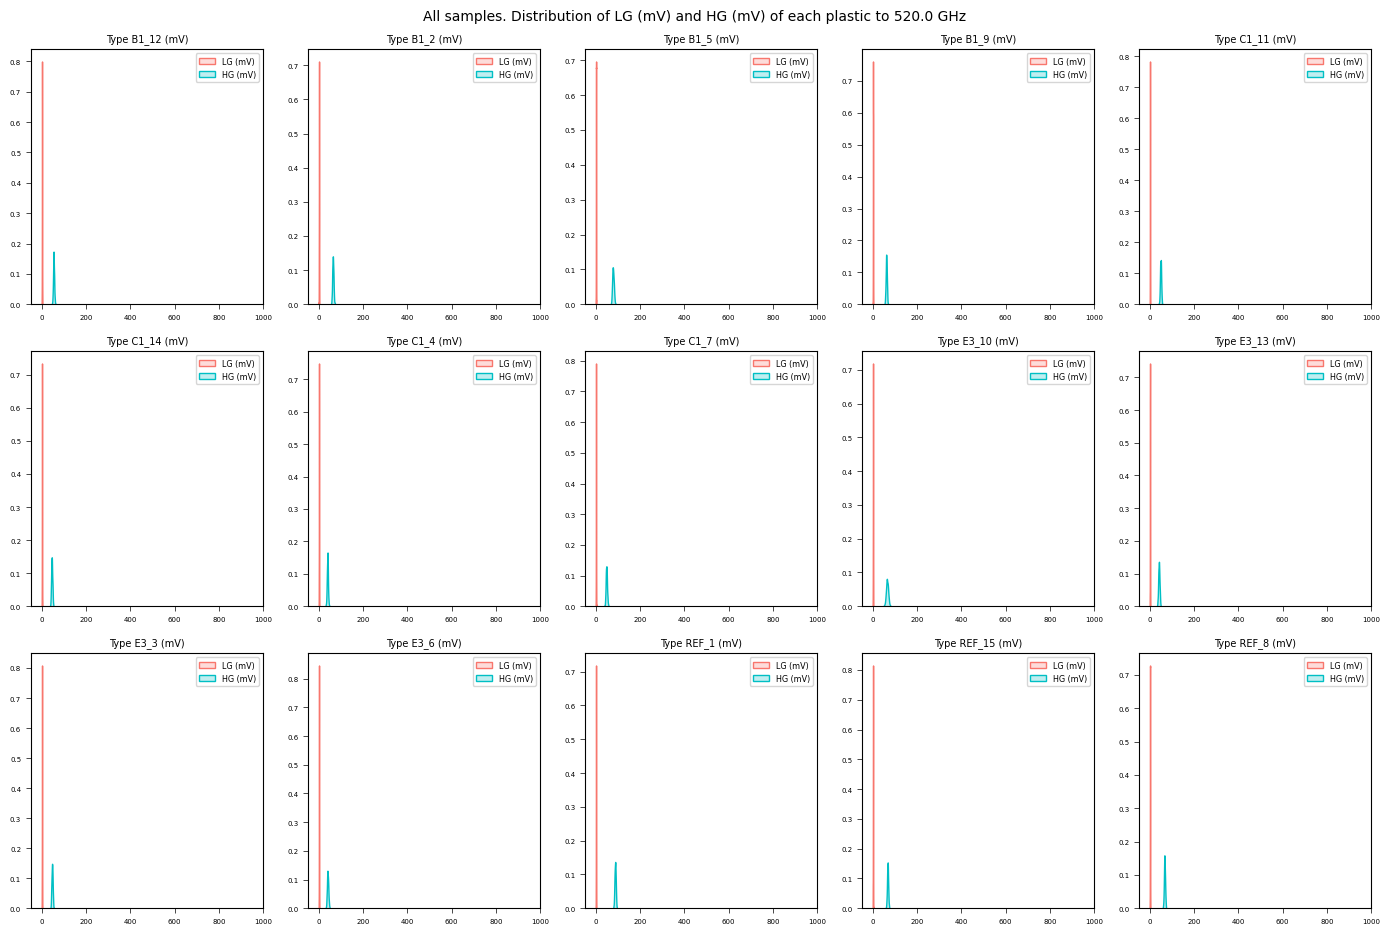

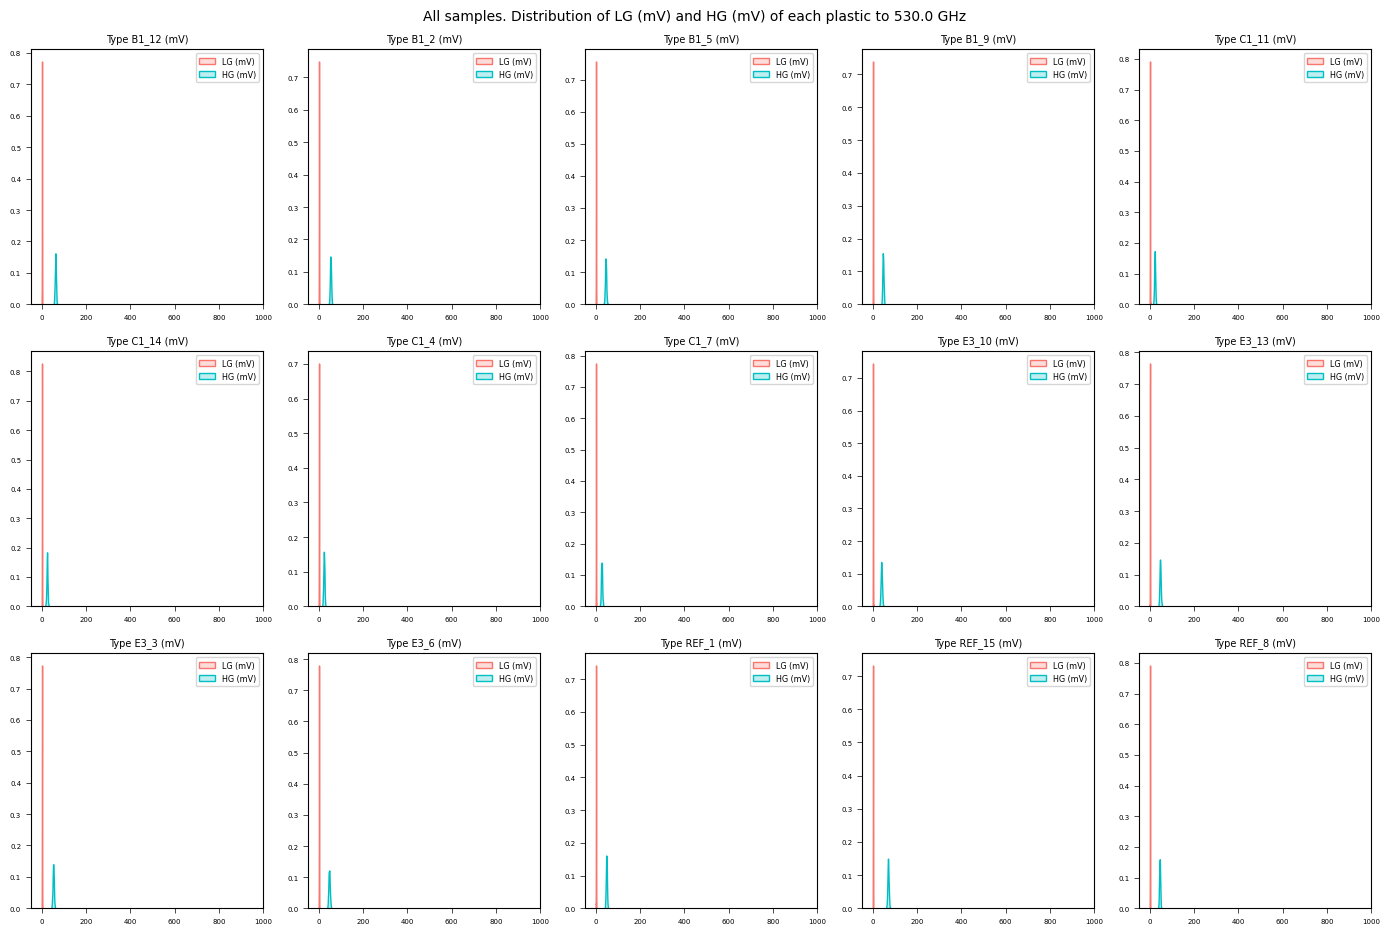

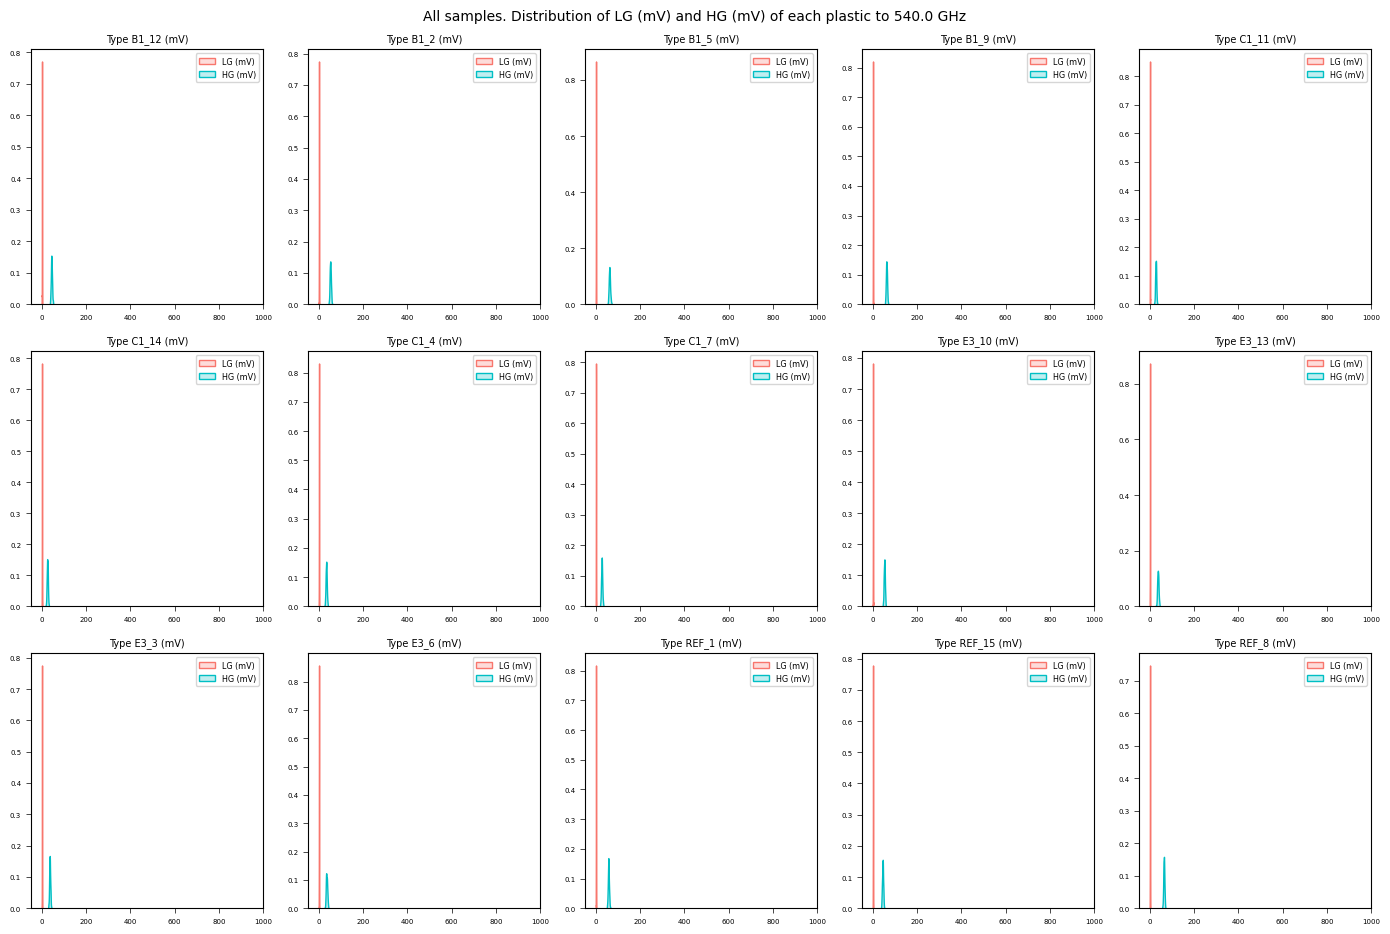

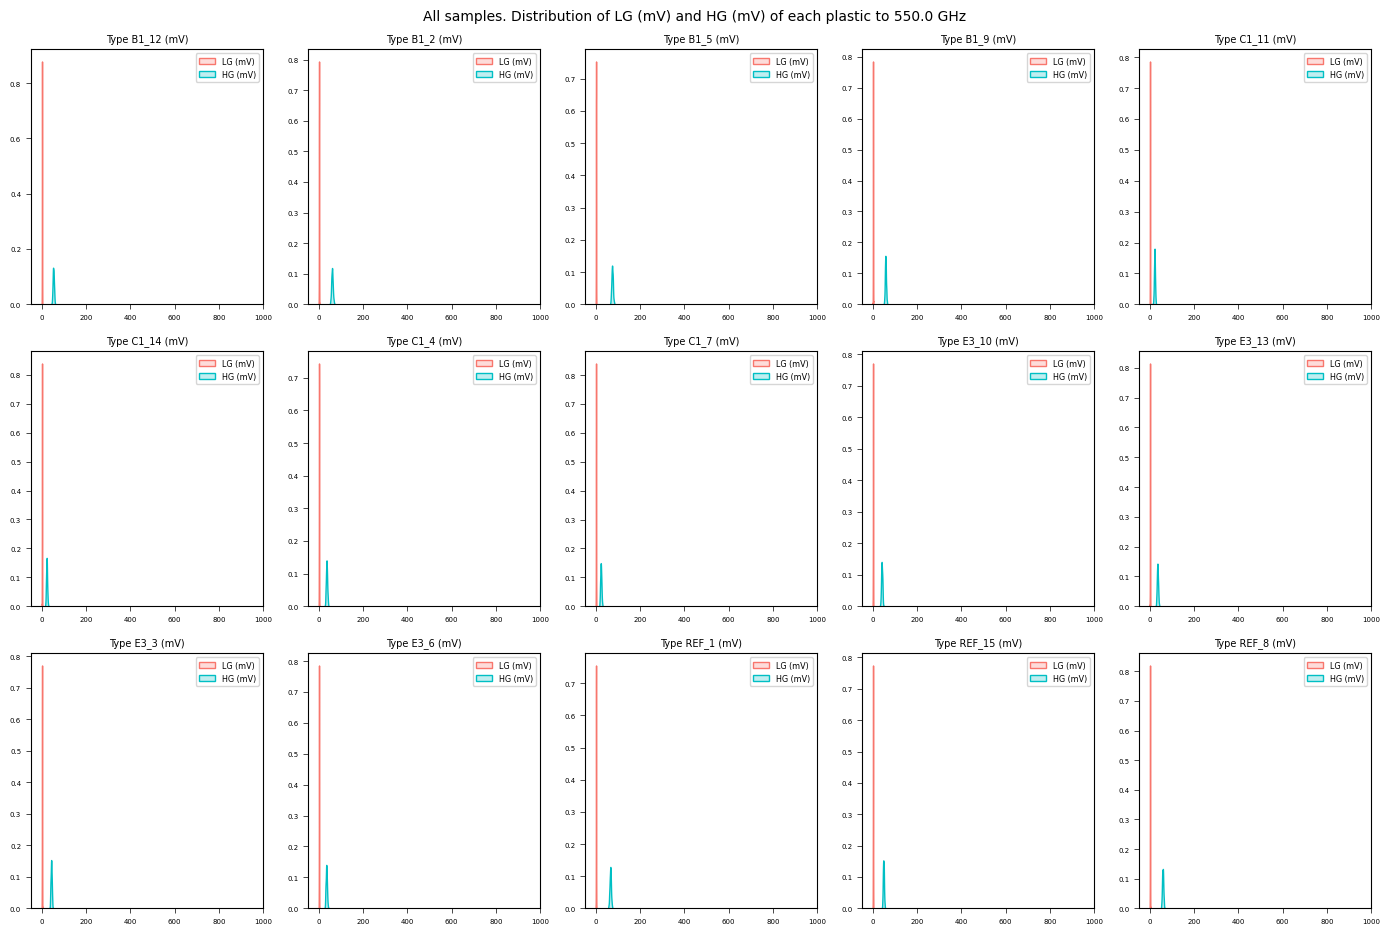

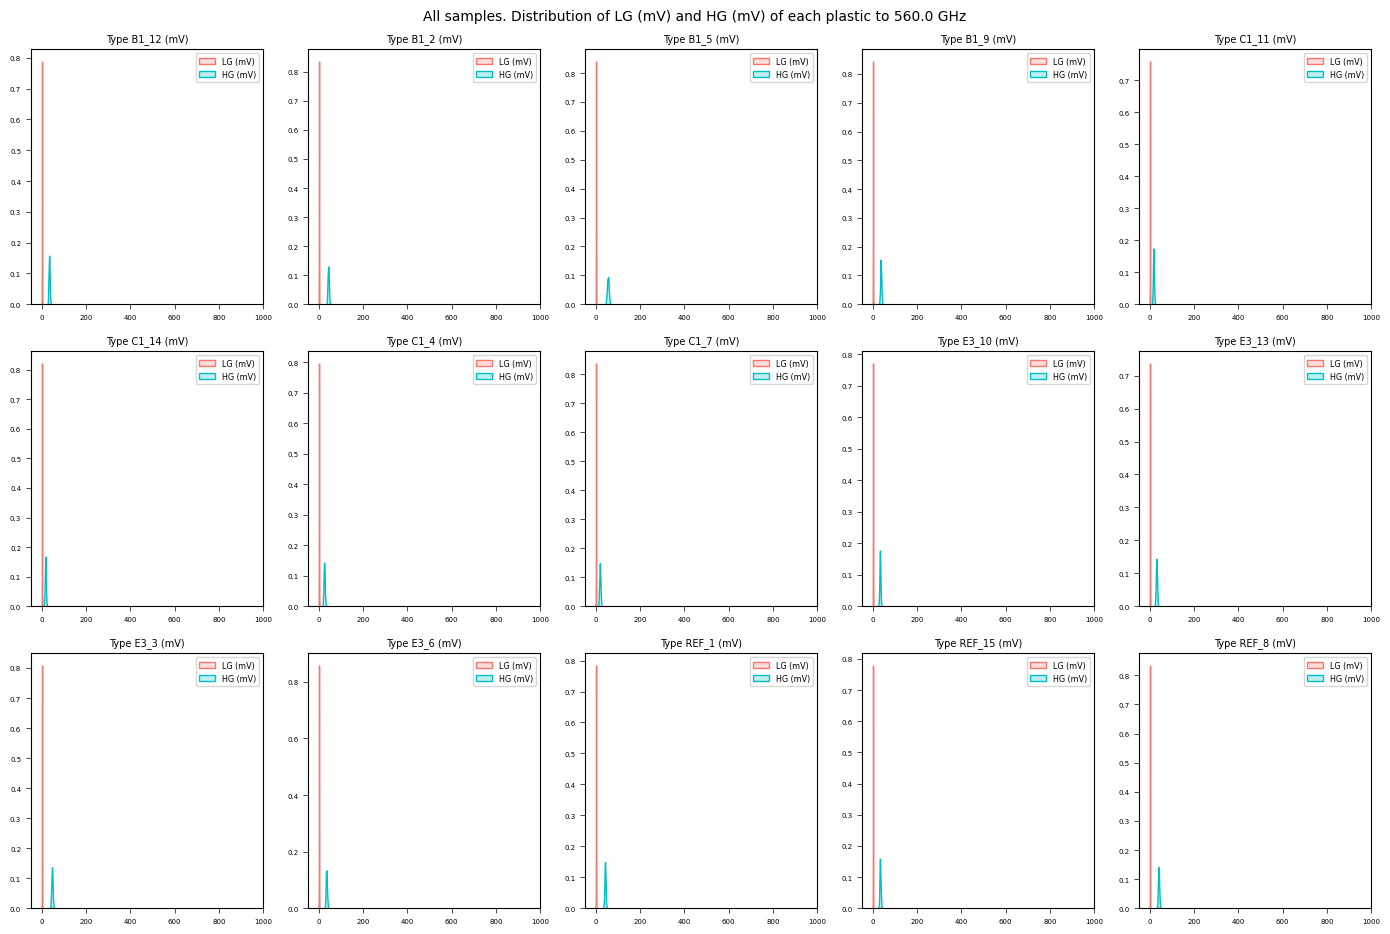

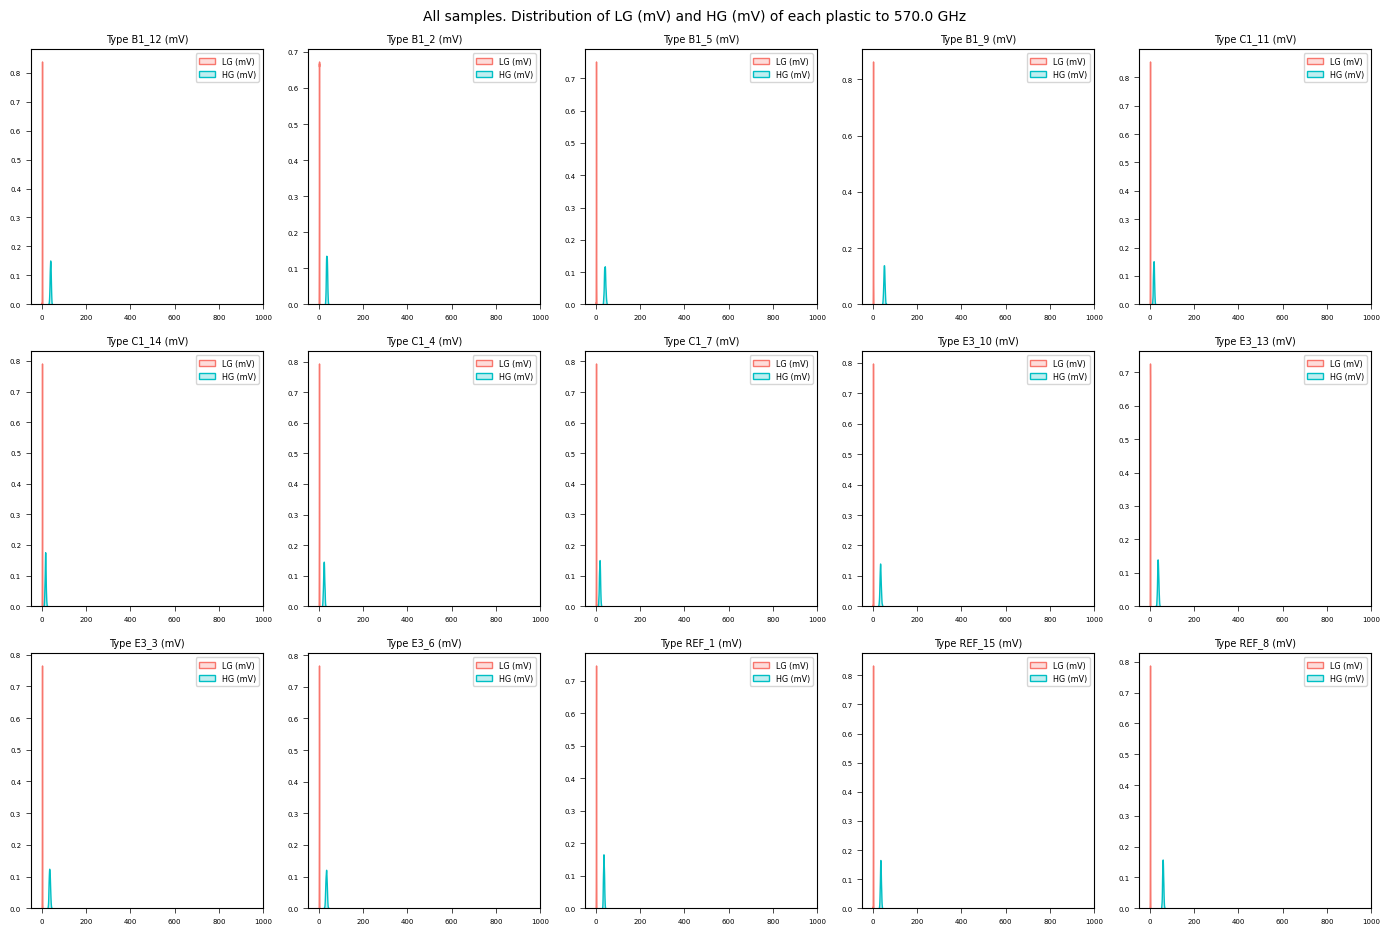

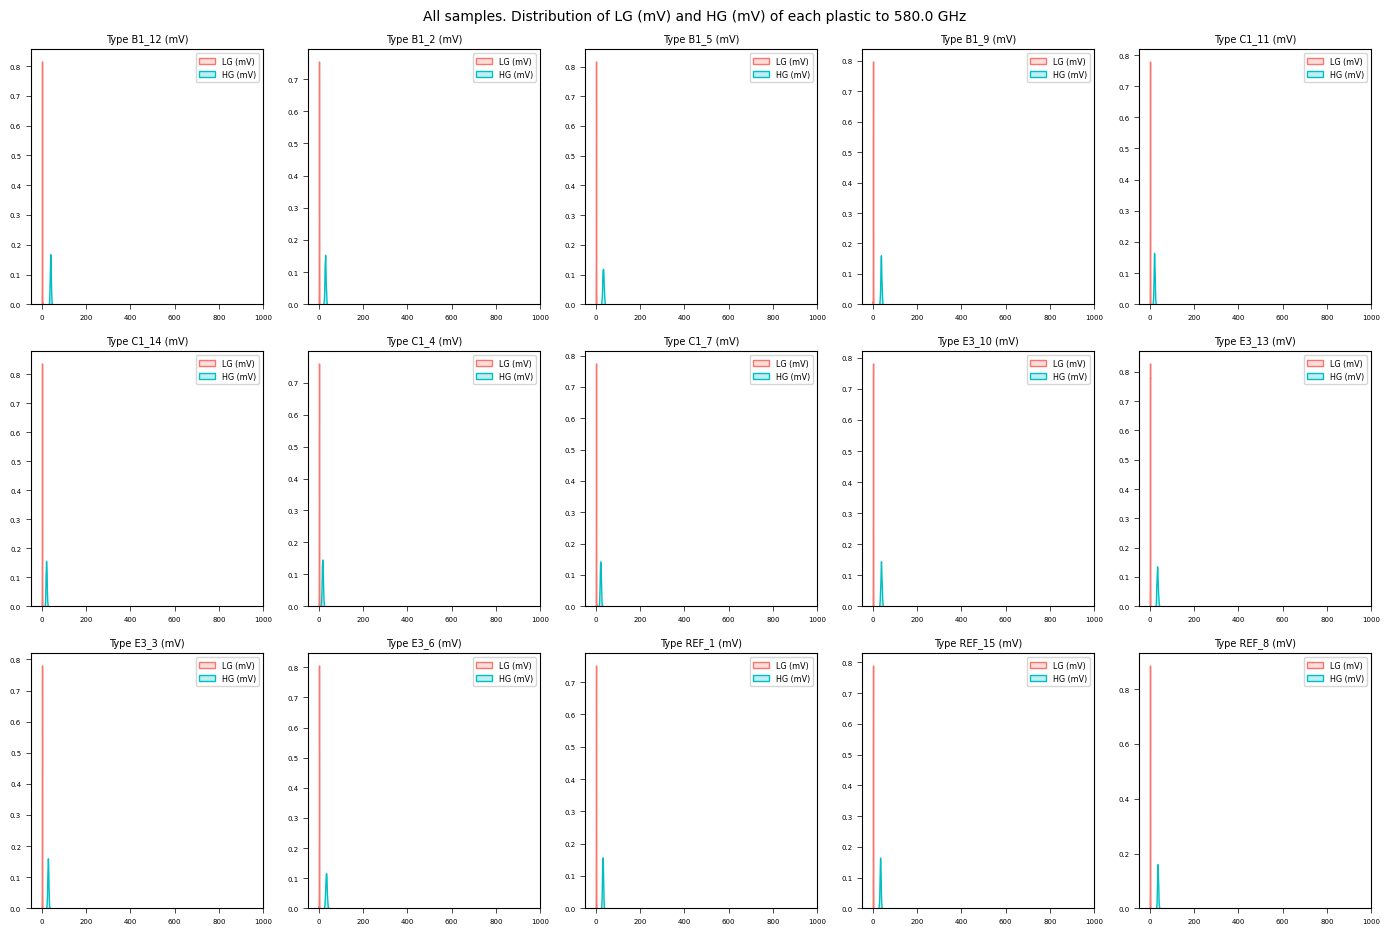

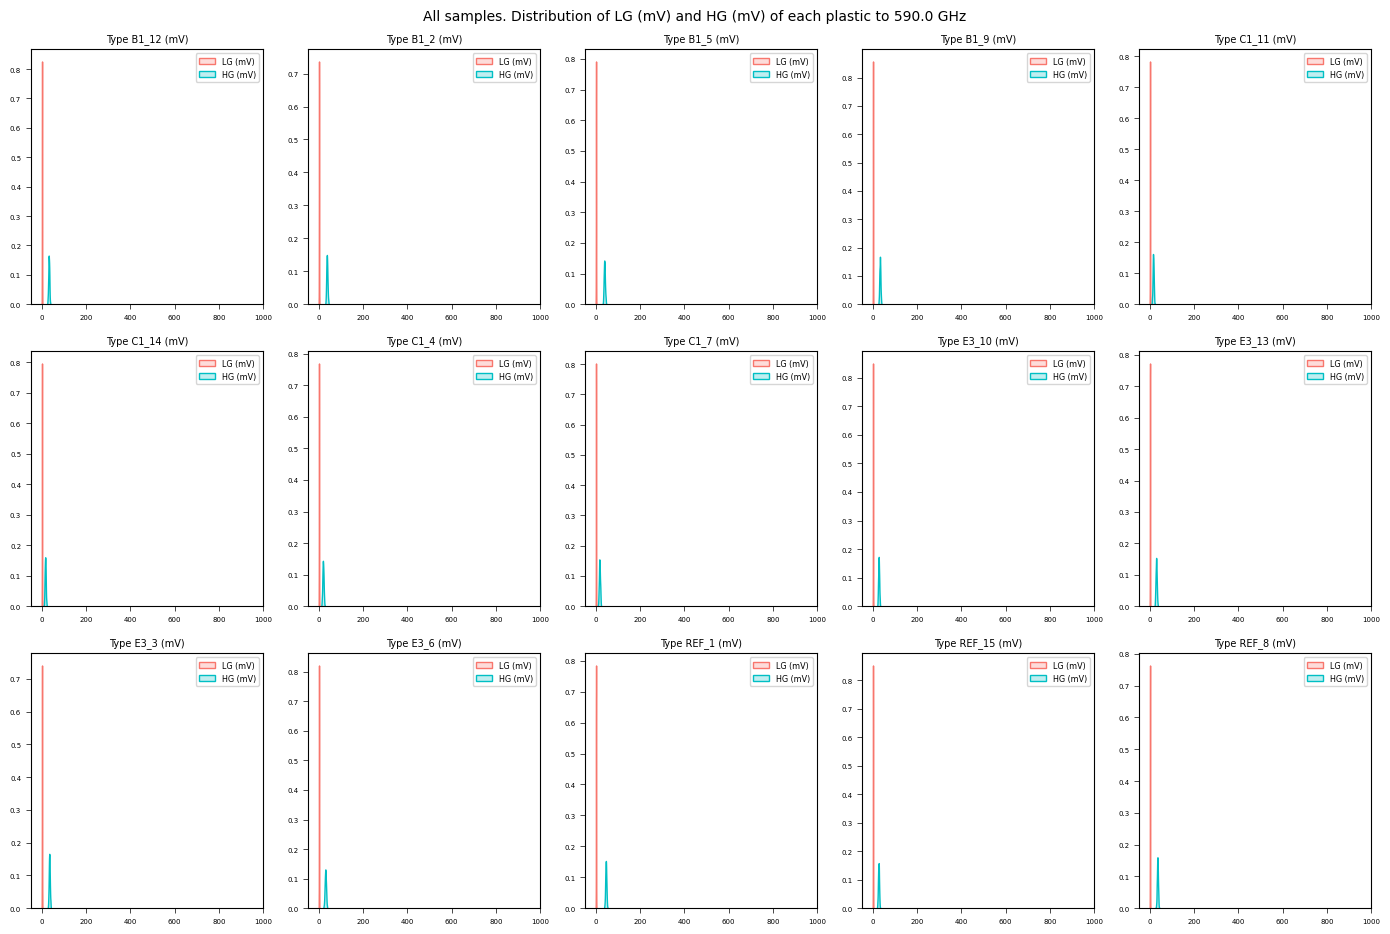

In [18]:
warnings.filterwarnings('ignore')

train_ex = df_balanced.copy()

print(train_ex.head())


for f in train_ex['Frequency (GHz)'].value_counts().index.sort_values().tolist():
    freq = f
    ncols = 5
    nrows = 3
    nums_plastics = 0
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(14, 10))
    axes = axes.flatten()  # Flatten the axes array
    
    for r in range(nrows * ncols):  # Adjust the loop to iterate over the flattened array
        t = train_ex['Sample'].value_counts().index.sort_values().tolist()
        if nums_plastics < len(t):
            df_tmp = train_ex[(train_ex['Frequency (GHz)'] == freq) & (train_ex['Sample'] == t[nums_plastics])]
            sns.kdeplot(x=df_tmp['LG (mV)'], ax=axes[r], color='#F8766D', label='LG (mV)', fill=True)
            sns.kdeplot(x=df_tmp['HG (mV)'], ax=axes[r], color='#00BFC4', label='HG (mV)', fill=True)
            axes[r].legend(fontsize="xx-small")
            axes[r].set_ylabel('')
            axes[r].set_xlabel('')
            axes[r].set_title(f"Type {t[nums_plastics]} (mV)", fontsize=7)
            axes[r].tick_params(labelsize=5, width=0.5)
            axes[r].xaxis.offsetText.set_fontsize(6)
            axes[r].yaxis.offsetText.set_fontsize(4)
            axes[r].set_xlim(-50, 1000)
            nums_plastics += 1
        else:
            axes[r].axis('off')
    plt.suptitle(f"All samples. Distribution of LG (mV) and HG (mV) of each plastic to {freq} GHz", y=0.93, fontsize=10)
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Save plots
    # output_path = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_2_plastics/plots/data_distribution_per_freq'
    # output_path = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_3_repeatibility/plots/data_distribution_per_freq'
    # # output_path = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_4_plastics/plots/data_distribution_per_freq'

    # if not os.path.exists(output_path):
    #     os.makedirs(output_path)
    # plt.savefig(f"{output_path}/data_distribution_per_freq_{freq}.png", dpi=500)

    plt.show()





In [19]:
print('["' + '", "'.join(df_balanced['Sample'].unique()) + '"]') 


["B1_5", "E3_6", "E3_13", "C1_11", "C1_14", "E3_3", "E3_10", "C1_4", "B1_9", "REF_1", "REF_8", "B1_2", "REF_15", "B1_12", "C1_7"]


In [20]:
# Print best frequencies for each sample

df_tmp = df_balanced.copy()

# Remove every character of the sample but the first one
df_tmp['Sample'] = df_tmp['Sample'].str[0]

# For every unique sample, calculate and print the mean and standard deviation of HG (mV) for each frequency
unique_samples = df_tmp['Sample'].unique()

for sample in unique_samples:
    sample_df = df_tmp[df_tmp['Sample'] == sample]
    sample_stats = sample_df.groupby('Frequency (GHz)')['HG (mV)'].agg(['mean', 'std']).reset_index()
    
    # Ensure 'mean' column is numeric
    sample_stats['mean'] = pd.to_numeric(sample_stats['mean'], errors='coerce')
    
    # Filter frequencies with mean higher than 50
    filtered_sample_stats = sample_stats[sample_stats['mean'] > 50]
    
    # Sort by standard deviation value
    sorted_sample_stats = filtered_sample_stats.sort_values(by='std', ascending=False)
    
    # Print the sorted list
    print(f"Sample: {sample}")
    print(sorted_sample_stats)


Sample: B
    Frequency (GHz)        mean         std
25            350.0  512.608108  226.666079
22            320.0  384.263943  204.388488
27            370.0  502.490450  133.185112
13            230.0  849.185105  102.011882
35            450.0  141.284321   42.372266
30            400.0  221.703485   42.364936
23            330.0  608.852148   41.112021
29            390.0  608.146959   29.781492
26            360.0  458.146795   26.196241
28            380.0  591.135230   21.926955
31            410.0  267.457246   21.039198
34            440.0   96.615588   14.663946
33            430.0  114.677397   12.997704
38            480.0   97.799839   10.207030
36            460.0  145.941872    9.371185
42            520.0   62.689946    9.248361
40            500.0   91.723055    8.929565
37            470.0   79.989950    8.849045
39            490.0   70.068388    8.794756
45            550.0   59.456212    8.585545
44            540.0   53.842608    8.167704
32            420.0  2

## mV Average with error per frequency

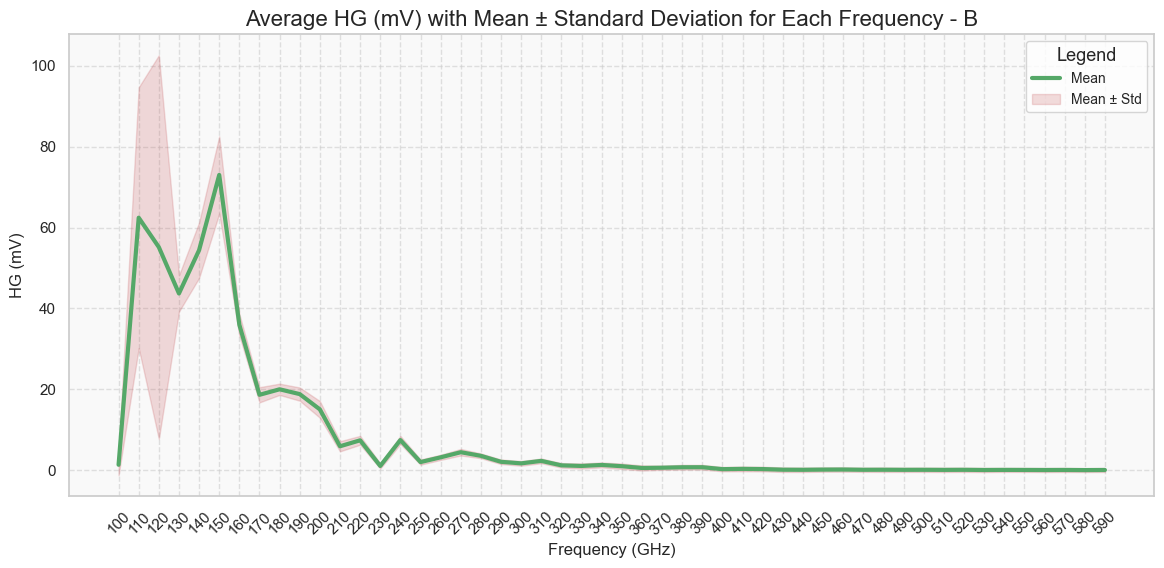

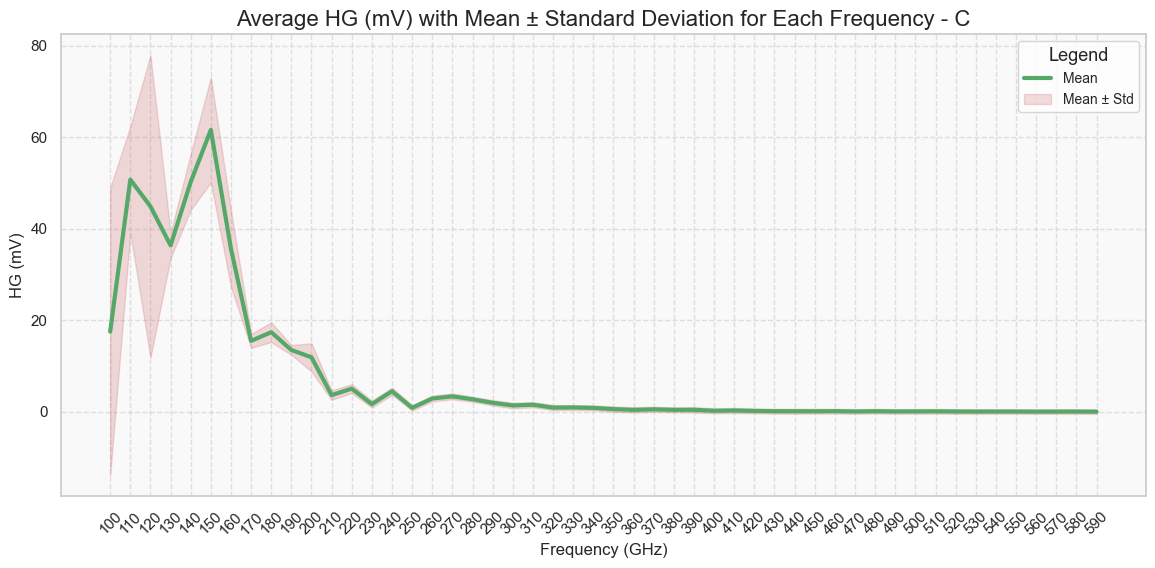

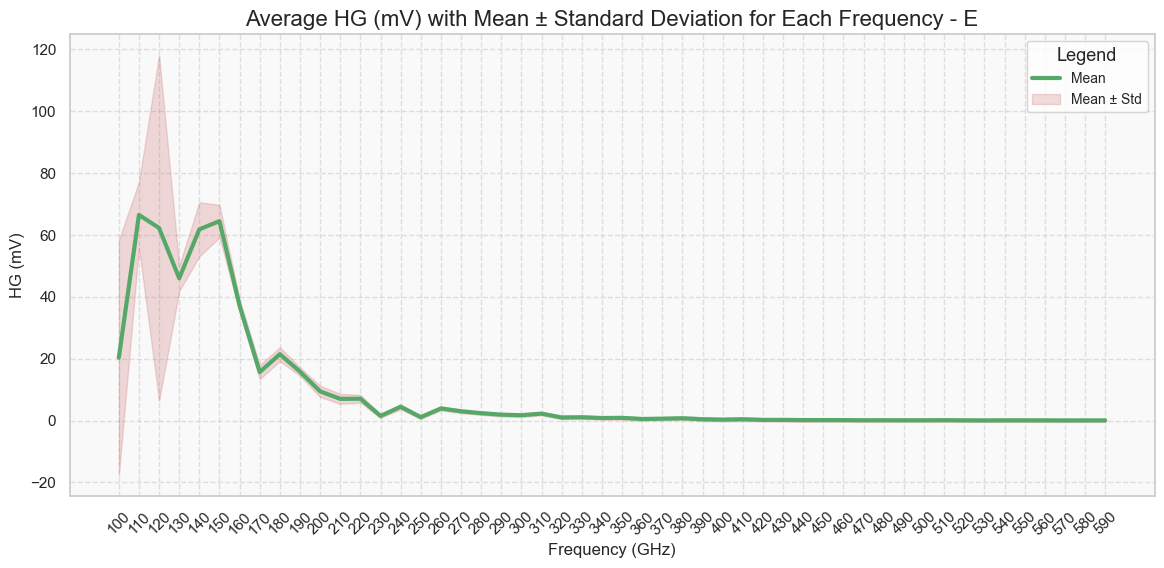

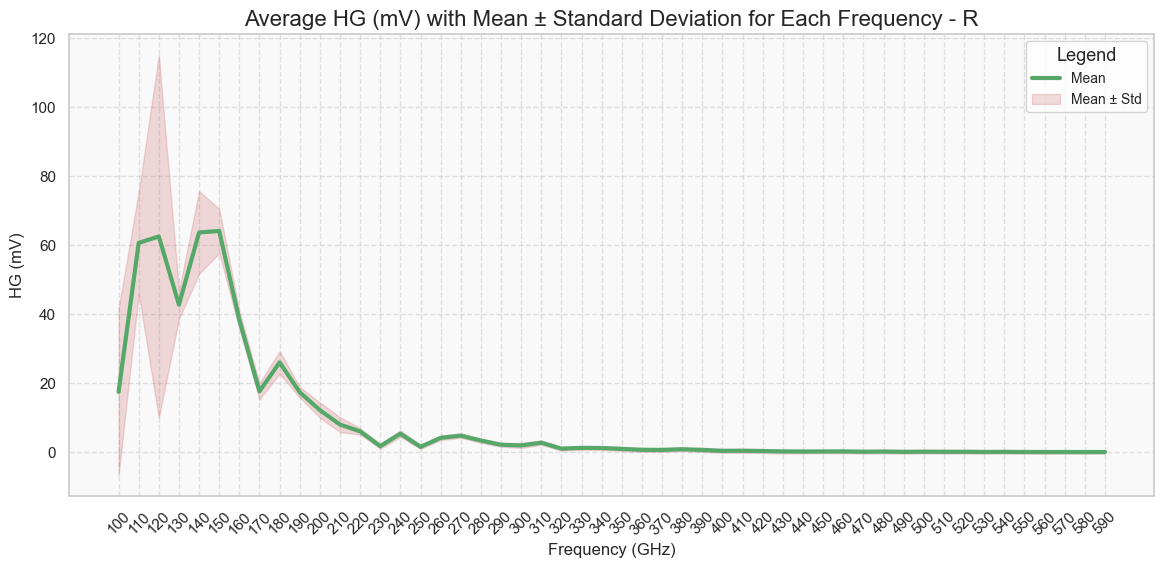

In [34]:
df_tmp = df_balanced.copy()

# Remove every character of the sample but the first one
df_tmp['Sample'] = df_tmp['Sample'].str[0]

labels = ['B','C','E','R']

for label in labels:    

    # Filter the DataFrame for the specific sample
    df = df_tmp[df_tmp['Sample'].str.startswith(label)]

    hg_stats = df.groupby(['Sample', 'Frequency (GHz)'])['LG (mV)'].agg(['mean', 'std']).reset_index()

    # Calculate the upper and lower bounds
    hg_stats['mean_plus_std'] = hg_stats['mean'] + hg_stats['std']
    hg_stats['mean_minus_std'] = hg_stats['mean'] - hg_stats['std']

    # Plot the average HG (mV) with shadow area for mean ± standard deviation
    plt.figure(figsize=(14, 6))
    sns.set_theme(style="whitegrid")

    # Plot mean line
    sns.lineplot(data=hg_stats, x='Frequency (GHz)', y='mean', marker='', color='g', linewidth=3, label='Mean')

    # Plot shadow area for mean ± 1 std
    plt.fill_between(hg_stats['Frequency (GHz)'], hg_stats['mean_minus_std'], hg_stats['mean_plus_std'], color='r', alpha=0.2, label='Mean ± Std')

    # Add labels and title
    plt.xlabel('Frequency (GHz)', fontsize=12)
    plt.ylabel('HG (mV)', fontsize=12)
    plt.title(f'Average HG (mV) with Mean ± Standard Deviation for Each Frequency - {label}', fontsize=16)

    # X axis space adjustment (show 1 of each 2 ticks)
    plt.xticks(hg_stats['Frequency (GHz)'].unique(), rotation=45)

    # Customize legend
    plt.legend(fontsize=10, title='Legend', title_fontsize='13')

    # Customize grid and background
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.gca().set_facecolor('#f9f9f9')

    # Show plot
    plt.show()



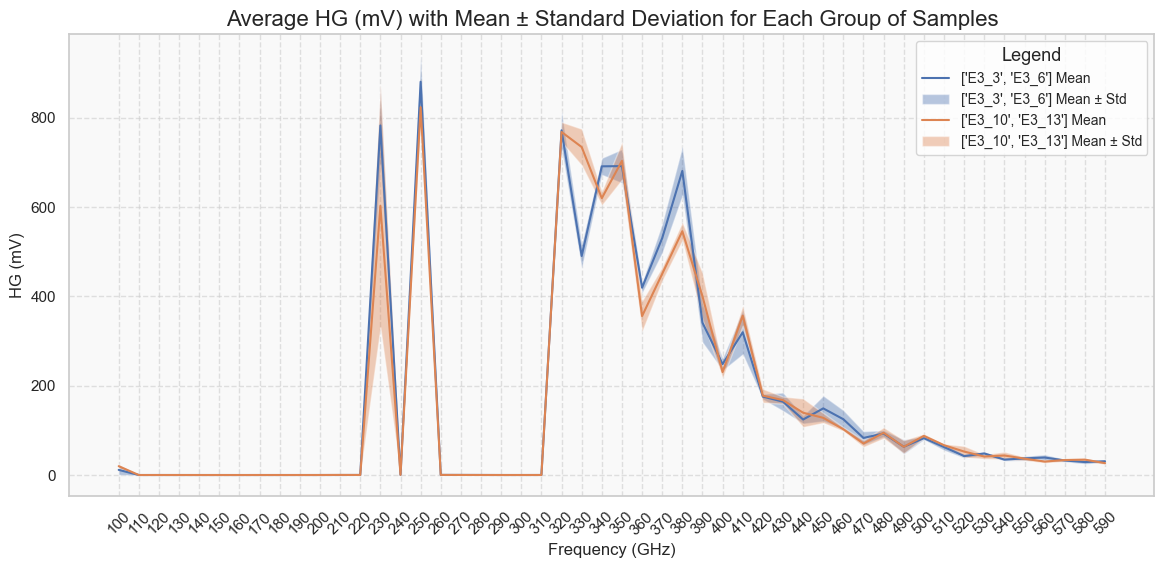

In [22]:
# labels = [ 'REF_1', 'REF_2', 'REF_3', 'REF_4','REF_5', 'REF_6', 'REF_7', 'REF_8', 'REF_9','REF_10',  'REF_11','REF_12',  'REF_13', 'REF_14', 'REF_15']
# labels = ["B1_12", "B1_2", "B1_5", "B1_9", "C1_11", "C1_14", "C1_4", "C1_7", "E3_10", "E3_13", "E3_3", "E3_6", "REF_1", "REF_15", "REF_8"]
# labels = [ 'B1_2', 'B1_5', 'B1_9', 'B1_12']
# labels = [ 'C1_4', 'C1_7', 'C1_11', 'C1_14']
# labels = [ 'E3_3', 'E3_6', 'E3_10', 'E3_13']
# labels = [ 'REF_1', 'REF_8', 'REF_15']

df_tmp = df_balanced.copy()

# Plot the average HG (mV) with shadow area for mean ± standard deviation of each of the selected groups of samples in 1 chart
labels = [['B1_2', 'B1_5'], ['B1_9', 'B1_12']]#, ['C1_4', 'C1_7'], ['C1_11', 'C1_14'], ['E3_3', 'E3_6'], ['E3_10', 'E3_13'], ['REF_1', 'REF_8'], ['REF_15']]
labels = [['C1_4', 'C1_7'], ['C1_11', 'C1_14']]
labels = [['E3_3', 'E3_6'], ['E3_10', 'E3_13']]
# labels = [['REF_1'] , [ 'REF_8', 'REF_15']]

# labels from 1 to 7 in 1 group, 8 to 15 in another group
# labels = [['REF_1', 'B1_2','E3_3', 'C1_4', 'B1_5', 'E3_6', 'C1_7'], [ 'REF_8', 'B1_9', 'E3_10', 'C1_11', 'B1_12', 'E3_13', 'C1_14','REF_15']]
# labels = [['B1_2', 'B1_5'], ['B1_9', 'B1_12']]#, ['C1_4', 'C1_7'], ['C1_11', 'C1_14'], ['E3_3', 'E3_6'], ['E3_10', 'E3_13'], ['REF_1', 'REF_8'], ['REF_15']]


plt.figure(figsize=(14, 6))
sns.set_theme(style="whitegrid")

for label_group in labels:
    # Filter the DataFrame for the specific group of samples
    df_group = df_tmp[df_tmp['Sample'].isin(label_group)]

    # Calculate mean and std deviation for the group
    group_stats = df_group.groupby('Frequency (GHz)')['HG (mV)'].agg(['mean', 'std']).reset_index()

    # Calculate the upper and lower bounds
    group_stats['mean_plus_std'] = group_stats['mean'] + group_stats['std']
    group_stats['mean_minus_std'] = group_stats['mean'] - group_stats['std']

    # Plot mean line
    sns.lineplot(data=group_stats, x='Frequency (GHz)', y='mean', marker='', label=f'{label_group} Mean')

    # Plot shadow area for mean ± 1 std
    plt.fill_between(group_stats['Frequency (GHz)'], group_stats['mean_minus_std'], group_stats['mean_plus_std'], alpha=0.4, label=f'{label_group} Mean ± Std')

# Add labels and title
plt.xlabel('Frequency (GHz)', fontsize=12)
plt.ylabel('HG (mV)', fontsize=12)
plt.title('Average HG (mV) with Mean ± Standard Deviation for Each Group of Samples', fontsize=16)

# X axis space adjustment (show 1 of each 2 ticks)
plt.xticks(group_stats['Frequency (GHz)'].unique(), rotation=45)

# Customize legend
plt.legend(fontsize=10, title='Legend', title_fontsize='13')

# Customize grid and background
plt.grid(True, linestyle='--', alpha=0.6)
plt.gca().set_facecolor('#f9f9f9')

# Show plot
plt.show()



## Data Windowing



In [25]:
# Calculate the percentage of data used for each window
time_window_s = 0.1
data_percentage = (100/(27*(1-test_percentage)))*time_window_s
data_percentage_test = (100/(27*(test_percentage)))*time_window_s

data_percentage = 0
data_percentage_test = 0

print(f"Data percentage: {data_percentage}%")
print(f"Data percentage test: {data_percentage_test}%")

# Load just a % of the data
# df_sample = train_set.sample(frac=0.02, random_state=42)

# Introduce Frequency values as input variables
train_set_test = freq_as_variable(train_set, data_percentage)
test_set_test = freq_as_variable(test_set, data_percentage_test)

# If a row has any NaN value, remove that row
train_set_test = train_set_test.dropna()
test_set_test = test_set_test.dropna()

#Save the processed data to a CSV file

# output_path = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/train_set.csv'
# output_path_test = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/test_set.csv'
# output_path = 'C:/Users/Dani - TUF/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/train_set.csv'
# output_path_test = 'C:/Users/Dani - TUF/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/test_set.csv'

# train_set_test.to_csv(output_path, sep = ';', index=False)
# test_set_test.to_csv(output_path_test, sep = ';', index=False)


Data percentage: 0%
Data percentage test: 0%


NameError: name 'train_set' is not defined

## Clustering

In [ ]:
# Unsupervised clusterization of every sample for each frequency (do not use labels for the clustering, just for the visualization afterwards)
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Define the number of clusters
n_clusters = 15

# Define the pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=n_clusters, random_state=42))
])

# Define the frequencies and samples
frequencies = train_ex['Frequency (GHz)'].unique()
samples = train_ex['Sample'].unique()

# Define the 14 colors and markers
# Define 14 colors and markers
colors = ['#F8766D', '#00BFC4', '#7CAE00', '#C77CFF', '#FF61C3', '#00BA38', '#619CFF', '#F564E3', '#00A9FF', '#FF9F00', '#00BFC4', '#F8766D', '#7CAE00', '#C77CFF', '#FF61C3']
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', 'H', 'd', 'P', 'X', '8']

# Create subplots
ncols = 5
nrows = int(np.ceil(len(frequencies) / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(20, nrows * 4), sharex=True, sharey=True)

# Ensure axes is iterable
axes = axes.flatten()

# Loop over frequencies
for idx, f in enumerate(frequencies):
    n_samples = 0
    # Loop over samples
    for s in samples:
        # Filter the DataFrame
        df_tmp = train_ex[(train_ex['Frequency (GHz)'] == f) & (train_ex['Sample'] == s)]
        # Check if there are enough samples
        if len(df_tmp) >= n_clusters:
            # Fit the pipeline
            pipe.fit(df_tmp[['LG (mV)', 'HG (mV)']])
            # Get the cluster labels
            labels = pipe.named_steps['kmeans'].labels_
            # Plot the data
            axes[idx].scatter(df_tmp['LG (mV)'], df_tmp['HG (mV)'],
                              color=colors[n_samples % len(colors)],
                              marker=markers[n_samples % len(markers)],
                              label=s)
            axes[idx].set_title(f"Frequency {f} GHz")
            axes[idx].set_xlabel('LG (mV)')
            axes[idx].set_ylabel('HG (mV)')
            axes[idx].legend(fontsize='xx-small')
            n_samples += 1

# Hide any unused subplots
for ax in axes[len(frequencies):]:
    ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.subplots_adjust(hspace=0.5)

# # Save plots
# output_path = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_2_plastics/plots/all_samples_distribution_per_freq'
# if not os.path.exists(output_path):
#     os.makedirs(output_path)
# plt.savefig(f"{output_path}/data_distribution_per_freq_{freq}.png", dpi=500)
plt.show()


## Sample a test set

In [26]:
# train_set, test_set = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Sample']) 
test_percentage = 0.25
# train_set, test_set = train_test_split(df, test_size=test_percentage, random_state=42) 
# Shuffle the data
df_balanced_ = df_balanced.sample(frac=1, random_state=42)
train_set, test_set = train_test_split(df_balanced_, test_size=test_percentage, random_state=42) 

# stratify=df['Sample'] to keep the same proportion of samples in the train and test set


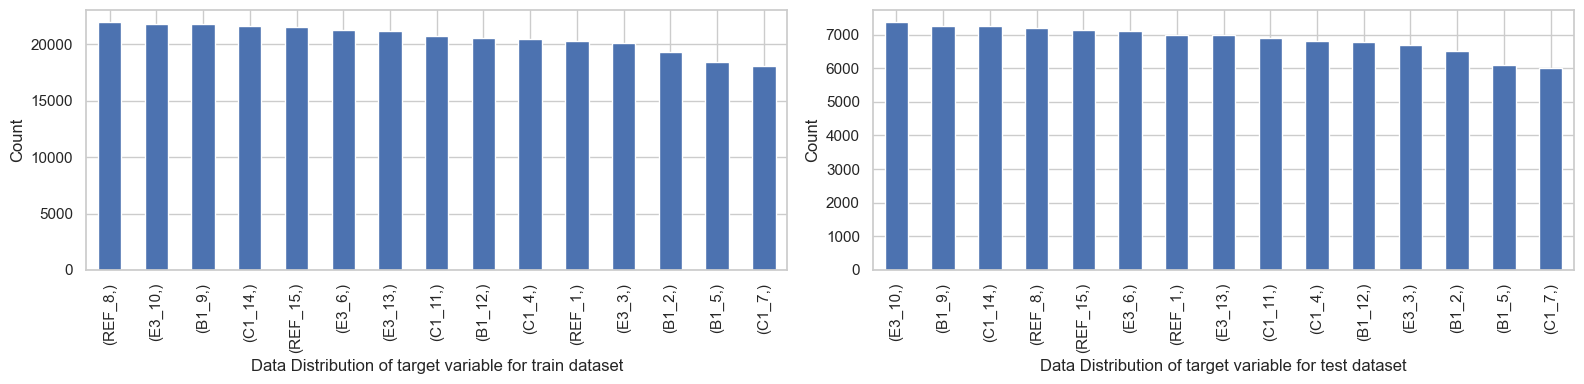

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

# Plot train set
train_set[['Sample']].value_counts().plot.bar(ax=ax[0], legend=False)
ax[0].set_xlabel('Data Distribution of target variable for train dataset')
ax[0].set_ylabel('Count')

# Plot test set
test_set[['Sample']].value_counts().plot.bar(ax=ax[1], legend=False)
ax[1].set_xlabel('Data Distribution of target variable for test dataset')
ax[1].set_ylabel('Count')

plt.tight_layout() 
plt.show()

In [28]:
train_ex = train_set.copy()

In [29]:
train_ex.info()
# train_ex.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 309272 entries, 20204 to 274246
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Frequency (GHz)  309272 non-null  float64
 1   LG (mV)          309272 non-null  float64
 2   HG (mV)          309272 non-null  float64
 3   Sample           309272 non-null  object 
dtypes: float64(3), object(1)
memory usage: 11.8+ MB


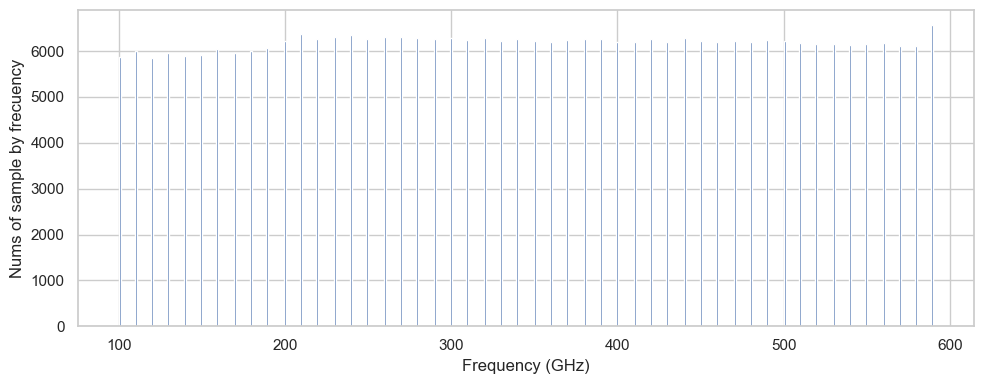

In [30]:

ax = train_ex['Frequency (GHz)'].plot.hist(figsize=(10, 4), bins=408)
# ax = test_set['Frequency (GHz)'].plot.hist(ax=ax, bins=408)
ax.set_xlabel('Frequency (GHz)')
ax.set_ylabel('Nums of sample by frecuency')
plt.tight_layout()
plt.show()

In [31]:
# Calculate the percentage of data used for each window
time_window_s = 0.1
data_percentage = (100/(27*(1-test_percentage)))*time_window_s
data_percentage_test = (100/(27*(test_percentage)))*time_window_s

data_percentage = 0
data_percentage_test = 0

print(f"Data percentage: {data_percentage}%")
print(f"Data percentage test: {data_percentage_test}%")

# Load just a % of the data
# df_sample = train_set.sample(frac=0.02, random_state=42)

# Introduce Frequency values as input variables
train_set_test = freq_as_variable(train_set, data_percentage)
test_set_test = freq_as_variable(test_set, data_percentage_test)

# If a row has any NaN value, remove that row
train_set_test = train_set_test.dropna()
test_set_test = test_set_test.dropna()

#Save the processed data to a CSV file

output_path = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/train_set.csv'
output_path_test = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/test_set.csv'
# output_path = 'C:/Users/Dani - TUF/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/train_set.csv'
# output_path_test = 'C:/Users/Dani - TUF/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/test_set.csv'

# train_set_test.to_csv(output_path, sep = ';', index=False)
# test_set_test.to_csv(output_path_test, sep = ';', index=False)



Data percentage: 0%
Data percentage test: 0%


In [32]:
print(f"Train set shape: {train_set_test.shape}")
print(f"Test set shape: {test_set_test.shape}")
print(train_set_test.head())
print(test_set.shape)


Train set shape: (5334, 101)
Test set shape: (1652, 101)
   100.0 HG (mV)  100.0 LG (mV)  110.0 HG (mV)  110.0 LG (mV)  120.0 HG (mV)  \
0      25.668416       0.183128       0.366265      52.832376      -0.213671   
1      17.183494      -0.640947       0.122082      46.728116      -0.366247   
2      21.761689       0.213649       0.213629      41.478451      -0.488341   
3      24.294958       0.579905       0.030518      52.649248      -0.000006   
4      18.740080       0.030521      -0.488335      49.505554      -0.061029   

   120.0 LG (mV)  130.0 HG (mV)  130.0 LG (mV)  140.0 HG (mV)  140.0 LG (mV)  \
0      43.798072      -0.213653      51.428396      -0.091571      52.008301   
1      42.119399       0.091565      51.916737      -0.702006      53.320717   
2      24.996947      -0.366271      49.993895       0.061041      56.372847   
3      37.846417      -0.305218      47.338542      -0.030512      50.085459   
4      47.430106      -0.061047      48.742522      -0.549400 

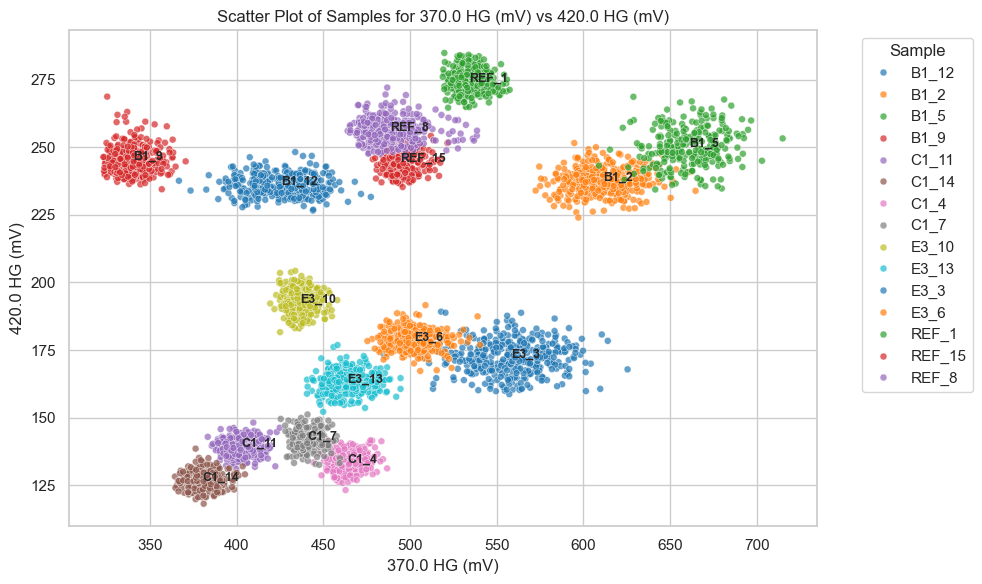

In [33]:
# Define the two frequencies to be used as axes
var1 = '370.0 HG (mV)'
var2 = '420.0 HG (mV)'

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=train_set_test, x=var1, y=var2, hue='Sample', palette='tab10', s=25, alpha=0.7)

# Add labels and title
plt.xlabel(f'{var1}')
plt.ylabel(f'{var2}')
plt.title(f'Scatter Plot of Samples for {var1} vs {var2}')

# Customize legend
plt.legend(title='Sample', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add sample names to clusters
for sample in train_set_test['Sample'].unique():
    sample_data = train_set_test[train_set_test['Sample'] == sample]
    cluster_center = sample_data[[var1, var2]].mean()
    plt.text(cluster_center[var1], cluster_center[var2], sample, fontsize=9, weight='bold')

# Show plot
plt.tight_layout()
plt.show()


In [ ]:
# Model Parameters
input_size = X_train.shape[1]
output_size = len(np.unique(y_train))
seed = set_seed(42)

input_size, output_size

# print(f'input_size: {input_size}, output_size: {output_size}')
# print(X_train, y_train)

(100, 7)